# 期末大作业——高频股票数据价格方向预测与策略生成
## 金融建模与量化投资课程


### <font color='black'>姓名 ： 杜德翔</font> 
### <font color='black'>学号 ： 2100022702</font> 
### <font color='black'>学院 ： 软件与微电子学院</font> 

### 若有兴趣，可以在Resset的测试数据集上用logit回归或机器学习（svm，各种decision tree模型）中的一种或多种方法，利用历史高频orderbook和价量数据预测下一个3秒的'买卖方向_Trdirec'（此为个人大作业方向4）

## 争议探究

根据查阅RESSET高频数据使用说明发现

Trdirec 买卖方向计算方法

第一步，如果 成交价>0.5*(前一笔买一价+前一笔卖一价)，则为买方主动成交；如果 成交价<0.5*(前一笔买一价+前一笔卖一价)，则为卖方主动成交；如果 成交价=0.5*(前一笔买一价+前一笔卖一价)，则进行第二步。

第二步，如果 成交价>0.5*(前第二笔买一价+前第二笔卖一价)，则为买方主动成交；如果 成交价<0.5*(前第二笔买一价+前第二笔卖一价)，则为卖方主动成交；如果 成交价=0.5*(前第二笔买一价+前第二笔卖一价)，则进行第三步。

第三步，如果 成交价>0.5*(前第三笔买一价+前第三笔卖一价)，则为买方主动成交；如果 成交价<0.5*(前第三笔买一价+前第三笔卖一价)，则为卖方主动成交；如果 成交价=0.5*(前第三笔买一价+前第三笔卖一价)，则判定为无法确定买卖方向。

## Trdirec_买卖方向 vs 交易价格变动方向

首先从定义来看，这个买卖方向是比较此刻买卖价格和上一时刻买卖单价格中值大小决定的，而不是每一时刻的成交价格变动方向。

另一方面，从数据集结构来看，这个Trdirec 买卖方向 在集合竞价时均为F，在连续竞价交易时为B或者S，进行分类学习时为二分类，而成交价格则有上升，不变，下降（-1,0,1）三个方向，在学习时为多分类，因此学习过程略有差异。

最后，从实际应用来看，这个方向上升下降并不能反映实际成交价格的上升和下降，因此可能更适用了解盘口价格方向变化而应用到做市，而不是预测成交价格的变动而制定交易策略。

因此，我决定从实际应用价值层面出发，首先对实际价格变动方向进行变动进行多个机器学习算法建模，并由此生成数条交易策略并回测，作为研究一。

然后，修正一下方法中的差异，再对数据集中Trdirec 买卖方向进行多种模型预测，作为研究二。

# 研究一：交易价格变动方向预测与策略生成

## 引言  

  很荣幸能够参加本学期金融建模与量化投资课程！感谢张老师和助教学长一学期辛苦的教学和工作，带我们走入金融建模与量化投资这个领域，学习了EXCEl与python中多种工具在金融领域的应用，并能够将课程所学课下动手实践解决实际问题。
  
  我本次研究就是通过多种机器学习算法（logistic回归、决策树、KNN、朴素贝叶斯、SVM、随机森林、Voting Ensemble、Adaboost、深度学习等多种方法）预测高频场景股价下一个3s的变动方向，并利用做出的预测生成可盈利的高频交易策略。

## 研究问题

  从“Modeling high-frequency limit order book dynamics with support vector machines——Alec N.Kercheval October 24, 2013”这篇文献中了解到，相对于日频数据，高频的股票数据价格方向具有更少的随机性从而更好预测。由于我国股市T+0制度、缺少撮合商统一交易所结算等原因限制，我国高频量化目前主要集中在期货市场，更加激发我想尝试利用学到的各种机器学习算法去预测高频场景A股市场的股价走向（向上，不变，向下）。而当能够预测股票价格变动的方向，便可因此构建策略，交易获利。

## 数据集

  RESSET测试数据集是tick级别的level2股票数据，可以用来进行高频股票数据价格方向的训练与预测：是万达股票在深交所的数据。共有100000条，包含了26个交易日早市和午市的level2快照数据，交易时间每3s更新一次。Features则主要包含了十裆买卖报价与需求量，成交价与成交量等 51个维度，具体如下：
  
  
  ['观测序号_nobs', '交易所标识()_Exchflg', '代码_Code', '代码与市场标识_Code_Mkt',
       '证券名称_Secunm', '修改时间_MTime', '行情时间_QTime', '行情日期_Qdate',
       '前收盘价(元)_PrevClPr', '开盘价(元)_Oppr', '最高价(元)_Hipr', '最低价(元)_Lopr',
       '成交价(元)_TPrice', '成交量(股)_TVolume', '成交额(元)_TSum', '成交笔数()_TDeals',
       '累计成交量_TVolume_accu', '累计成交额(元)_TSum_accu', '累计成交笔数()_TDeals_accu',
       '市盈率1()_PE1', '市盈率2()_PE2', '价格升跌1()_ChangePCT1', '价格升跌2()_ChangePCT2',
       '合约持仓量()_OpInterest', '买价1(元)_Bidpr1', '买价2(元)_Bidpr2', '买价3(元)_Bidpr3',
       '买价4(元)_Bidpr4', '买价5(元)_Bidpr5', '买入数量1(股)_Bidvol1',
       '买入数量2(股)_Bidvol2', '买入数量3(股)_Bidvol3', '买入数量4(股)_Bidvol4',
       '买入数量5(股)_Bidvol5', '卖价1(元)_Askpr1', '卖价2(元)_Askpr2', '卖价3(元)_Askpr3',
       '卖价4(元)_Askpr4', '卖价5(元)_Askpr5', '卖出数量1(股)_Askvol1',
       '卖出数量2(股)_Askvol2', '卖出数量3(股)_Askvol3', '卖出数量4(股)_Askvol4',
       '卖出数量5(股)_Askvol5', '买卖方向_Trdirec', '绝对买卖报价差(元)_Absspread',
       '相对买卖报价差(元)_Respread', '绝对有效买卖报价差(元)_Abseffspread',
       '相对有效买卖报价差(元)_Reeffspread', '深度1(元)_Depth1', '深度2(元)_Depth2']
       

## 方法：
    
   使用模型：
    
   Logistic回归、决策树分类、KNN分类、Naive Bayes分类、Linear SVM，Kernel SVM、集成模型（随机森林、Voting Classifier、AdaBoost）深度学习
    
    
   变量降维：
    
   lasso筛选、PCA分析
    
    
    
   使用Metrics：
   
   accuracy，f1score（macro加权），训练时间t，混淆矩阵
    
    
   调参：
   
   K折验证、gridsearch
   
   
   数据加工：
   
   规避未来数据的归一化处理、滞后项加速度项产生、新特征生成
   
   
   数据集处理：
   
   首先找出所有交易时段，同时剔除集合竞价交易时段，只保留连续竞价时段用于训练。
   将筛选合成的数据，按时间顺序滚动分割为给定数量的训练集与测试集，并以给定步长向前滚动，生成多组训练测试集。
   
   
   
   预测结果应用：
   
   交易策略编写与回测
   
  
  
## 研究过程：

  首先对数据进行导入并可视化展示，并对变量进行精简、清洗数据
  
  接下来是特征工程：将原始特征集的特征按照问题逻辑加工获得多种有效特征，截面加工后提取出滞后项与加速度项并作为新特征。
  
  然后对数据集进行划分，首先进行时间段划分，划分出每一段连续竞价的区间，这是模型可以应用的场景；其次对数据集进行合成，将大数据集按时间顺序滚动分割为给定数量的训练集与测试集，并以给定步长向前滚动，生成多组训练测试集。
 
  为加快收敛，避免量纲差异大对数据进行归一化处理，由于进行金融序列进行训练预测时，使用某一特征的最大最小、平均与方差相当于使用了未来数据，而这会导致模型失效，故采用使用前n期历史数据对本期数据进行归一化处理。
  
  由于经过如上加工产生的变量维度过高达到280条，分别使用Lasso进行变量筛选以及主成分分析进行数据降维，分别生成对应降维后的数据，用于后续训练使用。
  
  接下来，进行评价标准的建立，由于类别在样本不均衡且不同类别策略指导意义与计算资源消耗不同，本次研究除了常规accuracy外，还将f1score（macro加权），训练时间，混淆矩阵加入评价标准进行比较。同时编写统一模型训练评价接口函数，与混淆矩阵热力图函数，方便后续研究。
  
  然后，便是分别尝试使用各种机器学习模型进行调参（使用gridsearch 和k折验证），确定最优超参数进行训练，并记录结果，绘制热力图。先后尝试了Logistic回归、决策树分类、KNN分类、Naive Bayes分类、Linear SVM，Kernel SVM等方法。并尝试使用集成模型，如随机森林，集成了logistic、随机森林与SVM的Voting Classifier，以及以logistic回归作为元分类器的AdaBoost，最终还训练了三层神经网络进行训练与预测。
  
  在完成以上的训练与预测后，我对各种机器学习模型进行综合比较，并在原始数据、Lasso筛选后数据、PCA降维后数据三种情况下进行综合比较，最终确定使用Logistic回归效果最好。
 
 ## 研究结果与应用
 
  完成机器学习任务后，我对预测结果进行应用，针对预测出的价格变动序列，分别设计两种交易策略，得到两种交易策略在不同价格序列、初始资金、融券保证金比例等各种参数下的总资产变动序列，并将简单购入并持有策略作为bench Mark，与通过预测股价方向生成的两种策略进行多维度对比回测，从应用角度体现出本次高频股价变动方向学习的有效性和价值性。

# 1 数据预处理

## 1.1 数据导入与可视化

In [7]:
import numpy as np
import pandas as pd
import pandoc
from matplotlib import pyplot as plt


In [5]:
#获取万达股票在深交所数据
originDataSet = pd.read_csv("RESSET_STKHF2017_000002SZ_1.csv")

In [6]:
originDataSet

,观测序号_nobs,交易所标识()_Exchflg,代码_Code,代码与市场标识_Code_Mkt,证券名称_Secunm,修改时间_MTime,行情时间_QTime,行情日期_Qdate,前收盘价(元)_PrevClPr,开盘价(元)_Oppr,...,卖出数量4(股)_Askvol4,卖出数量5(股)_Askvol5,买卖方向_Trdirec,绝对买卖报价差(元)_Absspread,相对买卖报价差(元)_Respread,绝对有效买卖报价差(元)_Abseffspread,相对有效买卖报价差(元)_Reeffspread,深度1(元)_Depth1,深度2(元)_Depth2,Unnamed: 51
0,1.0,2,2,000002.SZ,万 科Ａ,09:15:08,2017-01-03 09:15:09,2017-01-03,20.55,NaN,...,NaN,NaN,F,0.00,0.000000,NaN,NaN,534560.00,534560.00,NaN
1,2.0,2,2,000002.SZ,万 科Ａ,09:15:17,2017-01-03 09:15:18,2017-01-03,20.55,NaN,...,NaN,NaN,F,0.00,0.000000,NaN,NaN,534560.00,534560.00,NaN
2,3.0,2,2,000002.SZ,万 科Ａ,09:15:26,2017-01-03 09:15:27,2017-01-03,20.55,NaN,...,NaN,NaN,F,0.00,0.000000,NaN,NaN,534560.00,534560.00,NaN
3,4.0,2,2,000002.SZ,万 科Ａ,09:15:44,2017-01-03 09:15:45,2017-01-03,20.55,NaN,...,NaN,NaN,F,0.00,0.000000,NaN,NaN,534560.00,534560.00,NaN
4,5.0,2,2,000002.SZ,万 科Ａ,09:16:05,2017-01-03 09:16:06,2017-01-03,20.55,NaN,...,NaN,NaN,F,0.00,0.000000,NaN,NaN,14332813.80,14332813.80,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996.0,2,2,000002.SZ,万 科Ａ,12:31:36,2017-02-15 11:11:48,2017-02-15,20.91,20.9,...,12200.0,8700.0,S,0.01,0.000481,0.01,0.000481,1500810.28,9150547.98,NaN
99996,99997.0,2,2,000002.SZ,万 科Ａ,12:31:39,2017-02-15 11:11:51,2017-02-15,20.91,20.9,...,12200.0,8700.0,S,0.01,0.000481,0.01,0.000481,1689799.28,9339501.98,NaN
99997,99998.0,2,2,000002.SZ,万 科Ａ,12:31:42,2017-02-15 11:11:54,2017-02-15,20.91,20.9,...,12200.0,8700.0,S,0.01,0.000481,0.01,0.000481,1502869.28,9152571.98,NaN
99998,99999.0,2,2,000002.SZ,万 科Ａ,12:31:44,2017-02-15 11:11:57,2017-02-15,20.91,20.9,...,12200.0,8700.0,S,0.01,0.000481,0.01,0.000481,1513259.28,9202365.98,NaN


In [4]:
originDataSet.columns

Index(['观测序号_nobs', '交易所标识()_Exchflg', '代码_Code', '代码与市场标识_Code_Mkt',
       '证券名称_Secunm', '修改时间_MTime', '行情时间_QTime', '行情日期_Qdate',
       '前收盘价(元)_PrevClPr', '开盘价(元)_Oppr', '最高价(元)_Hipr', '最低价(元)_Lopr',
       '成交价(元)_TPrice', '成交量(股)_TVolume', '成交额(元)_TSum', '成交笔数()_TDeals',
       '累计成交量_TVolume_accu', '累计成交额(元)_TSum_accu', '累计成交笔数()_TDeals_accu',
       '市盈率1()_PE1', '市盈率2()_PE2', '价格升跌1()_ChangePCT1', '价格升跌2()_ChangePCT2',
       '合约持仓量()_OpInterest', '买价1(元)_Bidpr1', '买价2(元)_Bidpr2', '买价3(元)_Bidpr3',
       '买价4(元)_Bidpr4', '买价5(元)_Bidpr5', '买入数量1(股)_Bidvol1',
       '买入数量2(股)_Bidvol2', '买入数量3(股)_Bidvol3', '买入数量4(股)_Bidvol4',
       '买入数量5(股)_Bidvol5', '卖价1(元)_Askpr1', '卖价2(元)_Askpr2', '卖价3(元)_Askpr3',
       '卖价4(元)_Askpr4', '卖价5(元)_Askpr5', '卖出数量1(股)_Askvol1',
       '卖出数量2(股)_Askvol2', '卖出数量3(股)_Askvol3', '卖出数量4(股)_Askvol4',
       '卖出数量5(股)_Askvol5', '买卖方向_Trdirec', '绝对买卖报价差(元)_Absspread',
       '相对买卖报价差(元)_Respread', '绝对有效买卖报价差(元)_Abseffspread',
       '相对有效买卖报价差(元)_Reeff

C:\Users\reborn\AppData\Local\Temp\ipykernel_25032\7114457.py:21: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax.stem(price,quantity,'b',label='order book at time t')
C:\Users\reborn\AppData\Local\Temp\ipykernel_25032\7114457.py:22: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax.stem(goingprice,volume,'r--',label='transaction in [t-1,t]')


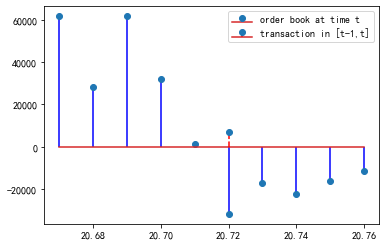

In [363]:
#画出盘口形态图，对数据集有更为直观的认识
columns_price = ['买价1(元)_Bidpr1', '买价2(元)_Bidpr2', '买价3(元)_Bidpr3', '买价4(元)_Bidpr4', '买价5(元)_Bidpr5', '卖价1(元)_Askpr1', '卖价2(元)_Askpr2', '卖价3(元)_Askpr3', '卖价4(元)_Askpr4', '卖价5(元)_Askpr5']
columns_quantity = ['买入数量1(股)_Bidvol1', '买入数量2(股)_Bidvol2', '买入数量3(股)_Bidvol3', '买入数量4(股)_Bidvol4', '买入数量5(股)_Bidvol5', '卖出数量1(股)_Askvol1', '卖出数量2(股)_Askvol2', '卖出数量3(股)_Askvol3', '卖出数量4(股)_Askvol4', '卖出数量5(股)_Askvol5']

backfilldata= originDataSet.set_index('行情时间_QTime').asfreq('3S', method='backfill').loc['2017-01-03 09:30:00':'2017-01-03 11:30:00',columns_price+columns_quantity]
originaldata= originDataSet.set_index('行情时间_QTime').asfreq('3S').loc['2017-01-03 09:30:00':'2017-01-03 11:30:00',['买卖方向_Trdirec','成交价(元)_TPrice','成交量(股)_TVolume', '成交额(元)_TSum', '成交笔数()_TDeals']]
ourdata = pd.merge(backfilldata,originaldata,how='outer',left_index=True, right_index=True)

buy_price_columns = ['买价1(元)_Bidpr1', '买价2(元)_Bidpr2', '买价3(元)_Bidpr3', '买价4(元)_Bidpr4', '买价5(元)_Bidpr5']
sell_price_columns= ['卖价1(元)_Askpr1', '卖价2(元)_Askpr2', '卖价3(元)_Askpr3', '卖价4(元)_Askpr4', '卖价5(元)_Askpr5']
buy_quantity_columns =['买入数量1(股)_Bidvol1', '买入数量2(股)_Bidvol2', '买入数量3(股)_Bidvol3', '买入数量4(股)_Bidvol4', '买入数量5(股)_Bidvol5']
sell_quantity_columns=['卖出数量1(股)_Askvol1', '卖出数量2(股)_Askvol2', '卖出数量3(股)_Askvol3', '卖出数量4(股)_Askvol4', '卖出数量5(股)_Askvol5']
goingprice_column='成交价(元)_TPrice'
volume_column='成交量(股)_TVolume'

def plot_orderbook(ddatetime, data):
    price = data.loc[ddatetime,buy_price_columns+sell_price_columns]
    quantity = pd.concat([data.loc[ddatetime,buy_quantity_columns], -1*data.loc[ddatetime,sell_quantity_columns]])
    goingprice = data.loc[ddatetime,goingprice_column]
    volume = data.loc[ddatetime,volume_column]
    fig,ax=plt.subplots()
    ax.stem(price,quantity,'b',label='order book at time t')
    ax.stem(goingprice,volume,'r--',label='transaction in [t-1,t]')
    legend = ax.legend(loc='upper right')
    plt.show()
    
plot_orderbook('2017-01-03 10:30:06', ourdata)

In [365]:
#交互式展示不同tick的盘口数据
interact(plot_orderbook, ddatetime=widgets.Dropdown(options=ourdata.index), data=fixed(ourdata));

interactive(children=(Dropdown(description='ddatetime', options=(Timestamp('2017-01-03 09:30:00', freq='3S'), …

## 1.2 数据集精简与清洗

In [5]:
#选取出后续分析可能使用的变量
columns_daily = ['前收盘价(元)_PrevClPr', '开盘价(元)_Oppr', '最高价(元)_Hipr', '最低价(元)_Lopr']
columns_price = ['买价1(元)_Bidpr1', '买价2(元)_Bidpr2', '买价3(元)_Bidpr3', '买价4(元)_Bidpr4', '买价5(元)_Bidpr5', '卖价1(元)_Askpr1', '卖价2(元)_Askpr2', '卖价3(元)_Askpr3', '卖价4(元)_Askpr4', '卖价5(元)_Askpr5']
columns_quantity = ['买入数量1(股)_Bidvol1', '买入数量2(股)_Bidvol2', '买入数量3(股)_Bidvol3', '买入数量4(股)_Bidvol4', '买入数量5(股)_Bidvol5', '卖出数量1(股)_Askvol1', '卖出数量2(股)_Askvol2', '卖出数量3(股)_Askvol3', '卖出数量4(股)_Askvol4', '卖出数量5(股)_Askvol5']
columns_trade = ['成交价(元)_TPrice', '成交量(股)_TVolume']
columns_direc = ['买卖方向_Trdirec']
# columns_price = [col for col in originDataSet.columns if '买价' in col or '卖价' in col]
# columns_quantity = [col for col in originDataSet.columns if '买入' in col or '卖出' in col]
# columns_trade = [col for col in originDataSet.columns if '成交' in col]


print(columns_price)
print(columns_quantity)
print(columns_trade)

['买价1(元)_Bidpr1', '买价2(元)_Bidpr2', '买价3(元)_Bidpr3', '买价4(元)_Bidpr4', '买价5(元)_Bidpr5', '卖价1(元)_Askpr1', '卖价2(元)_Askpr2', '卖价3(元)_Askpr3', '卖价4(元)_Askpr4', '卖价5(元)_Askpr5']
['买入数量1(股)_Bidvol1', '买入数量2(股)_Bidvol2', '买入数量3(股)_Bidvol3', '买入数量4(股)_Bidvol4', '买入数量5(股)_Bidvol5', '卖出数量1(股)_Askvol1', '卖出数量2(股)_Askvol2', '卖出数量3(股)_Askvol3', '卖出数量4(股)_Askvol4', '卖出数量5(股)_Askvol5']
['成交价(元)_TPrice', '成交量(股)_TVolume']


In [6]:
def organizeData(originDataSet,k):
    #将时间转换成时间类型
    originDataSet['行情时间_QTime'] = pd.to_datetime(originDataSet['行情时间_QTime'])
    #将时间列设置为键，并选取变量列
    dataSet = originDataSet.set_index('行情时间_QTime').loc[:,columns_price+columns_quantity+columns_trade+columns_daily+columns_direc]
    #删除买卖方向为空或异常的数据，并转化为0和1
    dataSet = dataSet.dropna(how='any', subset=["买卖方向_Trdirec"])
    dataSet = dataSet.loc[dataSet['买卖方向_Trdirec'].isin(["B","S"])]
    dataSet['买卖方向_Trdirec'] = dataSet['买卖方向_Trdirec'].map(lambda x: 0 if x=="B" else 1)
    #将下3*k秒成交价格变成y生成到上一行
    dataSet["未来价格"]=dataSet["成交价(元)_TPrice"].shift(-k)
    dataSet = dataSet.dropna(how='any', subset=["未来价格"])
    #获得价格变动方向
    dataSet["y"]=dataSet["未来价格"]-dataSet["成交价(元)_TPrice"]
    dataSet['y'] = dataSet['y'].map(lambda x: 0 if x==0 else ( 1 if x > 0 else -1 ))
    #将空白数据丢弃
    dataSet = dataSet.dropna(how='any')
    return dataSet

dataSet = organizeData(originDataSet,1)    
dataSet

,买价1(元)_Bidpr1,买价2(元)_Bidpr2,买价3(元)_Bidpr3,买价4(元)_Bidpr4,买价5(元)_Bidpr5,卖价1(元)_Askpr1,卖价2(元)_Askpr2,卖价3(元)_Askpr3,卖价4(元)_Askpr4,卖价5(元)_Askpr5,...,卖出数量5(股)_Askvol5,成交价(元)_TPrice,成交量(股)_TVolume,前收盘价(元)_PrevClPr,开盘价(元)_Oppr,最高价(元)_Hipr,最低价(元)_Lopr,买卖方向_Trdirec,未来价格,y
行情时间_QTime,,,,,,,,,,,,,,,,,,,,,
2017-01-03 09:30:06,20.56,20.55,20.54,20.53,20.52,20.59,20.60,20.64,20.65,20.66,...,2400.0,20.56,36600,20.55,20.55,20.59,20.55,0,20.56,0
2017-01-03 09:30:09,20.57,20.56,20.55,20.54,20.53,20.59,20.60,20.64,20.65,20.66,...,2400.0,20.56,8600,20.55,20.55,20.59,20.55,1,20.56,0
2017-01-03 09:30:12,20.57,20.56,20.55,20.54,20.53,20.59,20.60,20.64,20.65,20.66,...,2400.0,20.56,1000,20.55,20.55,20.59,20.55,1,20.56,0
2017-01-03 09:30:15,20.56,20.55,20.54,20.53,20.52,20.59,20.60,20.64,20.65,20.66,...,2400.0,20.56,20000,20.55,20.55,20.59,20.55,1,20.60,1
2017-01-03 09:30:18,20.59,20.56,20.55,20.54,20.53,20.60,20.64,20.65,20.66,20.68,...,4500.0,20.60,2100,20.55,20.55,20.60,20.55,0,20.59,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-15 11:11:45,20.77,20.76,20.75,20.74,20.73,20.78,20.79,20.80,20.81,20.82,...,8700.0,20.77,0,20.91,20.90,20.90,20.71,1,20.77,0
2017-02-15 11:11:48,20.77,20.76,20.75,20.74,20.73,20.78,20.79,20.80,20.81,20.82,...,8700.0,20.77,400,20.91,20.90,20.90,20.71,1,20.77,0
2017-02-15 11:11:51,20.77,20.76,20.75,20.74,20.73,20.78,20.79,20.80,20.81,20.82,...,8700.0,20.77,3100,20.91,20.90,20.90,20.71,1,20.77,0


In [7]:
# sum(dataSet['y']==-1)
# sum(dataSet['y']==0)

21215

## 1.3 数据集重命名

In [9]:
def renameData(dataSet):
    dataSet = dataSet.rename({'买价1(元)_Bidpr1':'bidPrice1','买价2(元)_Bidpr2':'bidPrice2',\
                                        '买价3(元)_Bidpr3':'bidPrice3','买价4(元)_Bidpr4':'bidPrice4','买价5(元)_Bidpr5':'bidPrice5'},axis='columns')
    dataSet = dataSet.rename({'卖价1(元)_Askpr1':'askPrice1','卖价2(元)_Askpr2':'askPrice2',\
                                        '卖价3(元)_Askpr3':'askPrice3', '卖价4(元)_Askpr4':'askPrice4', '卖价5(元)_Askpr5':'askPrice5'},axis='columns')
    dataSet = dataSet.rename({'买入数量1(股)_Bidvol1':'askVolume1', '买入数量2(股)_Bidvol2':'askVolume2',\
                                         '买入数量3(股)_Bidvol3':'askVolume3',  '买入数量4(股)_Bidvol4':'askVolume4', '买入数量5(股)_Bidvol5':'askVolume5'},axis='columns')
    dataSet = dataSet.rename({'卖出数量1(股)_Askvol1':'bidVolume1','卖出数量2(股)_Askvol2':'bidVolume2',\
                                        '卖出数量3(股)_Askvol3':'bidVolume3', '卖出数量4(股)_Askvol4':'bidVolume4', '卖出数量5(股)_Askvol5':'bidVolume5'},axis='columns')
    dataSet = dataSet.rename({'成交价(元)_TPrice':'TPrice','成交量(股)_TVolume':'TVolume'},axis='columns')
    dataSet = dataSet.rename({'买卖方向_Trdirec':'Trdirec'},axis='columns')
    dataSet = dataSet.rename({'前收盘价(元)_PrevClPr':'PrevClPr', '开盘价(元)_Oppr':'Oppr', '最高价(元)_Hipr':'Hipr', '最低价(元)_Lopr':'Lopr'},axis='columns')   


    return dataSet
dataSet = renameData(dataSet)
dataSet

,bidPrice1,bidPrice2,bidPrice3,bidPrice4,bidPrice5,askPrice1,askPrice2,askPrice3,askPrice4,askPrice5,...,bidVolume5,TPrice,TVolume,PrevClPr,Oppr,Hipr,Lopr,Trdirec,未来价格,y
行情时间_QTime,,,,,,,,,,,,,,,,,,,,,
2017-01-03 09:30:06,20.56,20.55,20.54,20.53,20.52,20.59,20.60,20.64,20.65,20.66,...,2400.0,20.56,36600,20.55,20.55,20.59,20.55,0,20.56,0
2017-01-03 09:30:09,20.57,20.56,20.55,20.54,20.53,20.59,20.60,20.64,20.65,20.66,...,2400.0,20.56,8600,20.55,20.55,20.59,20.55,1,20.56,0
2017-01-03 09:30:12,20.57,20.56,20.55,20.54,20.53,20.59,20.60,20.64,20.65,20.66,...,2400.0,20.56,1000,20.55,20.55,20.59,20.55,1,20.56,0
2017-01-03 09:30:15,20.56,20.55,20.54,20.53,20.52,20.59,20.60,20.64,20.65,20.66,...,2400.0,20.56,20000,20.55,20.55,20.59,20.55,1,20.60,1
2017-01-03 09:30:18,20.59,20.56,20.55,20.54,20.53,20.60,20.64,20.65,20.66,20.68,...,4500.0,20.60,2100,20.55,20.55,20.60,20.55,0,20.59,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-15 11:11:45,20.77,20.76,20.75,20.74,20.73,20.78,20.79,20.80,20.81,20.82,...,8700.0,20.77,0,20.91,20.90,20.90,20.71,1,20.77,0
2017-02-15 11:11:48,20.77,20.76,20.75,20.74,20.73,20.78,20.79,20.80,20.81,20.82,...,8700.0,20.77,400,20.91,20.90,20.90,20.71,1,20.77,0
2017-02-15 11:11:51,20.77,20.76,20.75,20.74,20.73,20.78,20.79,20.80,20.81,20.82,...,8700.0,20.77,3100,20.91,20.90,20.90,20.71,1,20.77,0


# 2 特征工程

## 2.1 特征信息生成

将原始数据集中的特征进行加工获得新特征：首先在同一时间截面进行加工，其次编写addLagging函数获得滞后项与加速度项

In [163]:
def featureEngineering(dataframe):
    ###V1: 十裆量价数据
    featV1 = dataframe[['askPrice1','askPrice2','askPrice3','askPrice4','askPrice5','askVolume1','askVolume2','askVolume3','askVolume4','askVolume5','bidPrice1','bidPrice2','bidPrice3','bidPrice4','bidPrice5','bidVolume1','bidVolume2','bidVolume3','bidVolume4','bidVolume5']]
    featV1 = np.array(featV1)

    ###V2: 买卖价差与中间值
    temp1 = featV1[:,0:5] - featV1[:,10:15]
    temp2 = (featV1[:,0:5] + featV1[:,10:15])*0.5
    featV2 = np.zeros([temp1.shape[0],temp1.shape[1]+temp2.shape[1]])
    featV2[:,0:temp1.shape[1]] = temp1
    featV2[:,temp1.shape[1]:] = temp2

    ###V3: 各种价差
    temp1 = featV1[:,4] - featV1[:,0]
    temp2 = featV1[:,10] - featV1[:,14]
    temp3 = abs(featV1[:,1:5] - featV1[:,0:4])
    temp4 = abs(featV1[:,11:15] - featV1[:,10:14])
    featV3 = np.zeros([temp1.shape[0],1+1+temp3.shape[1]+temp4.shape[1]])
    featV3[:,0] = temp1
    featV3[:,1] = temp2
    featV3[:,2:2+temp3.shape[1]] = temp3
    featV3[:,2+temp3.shape[1]:] = temp4

    ###V4: 价格与需求量均值
    temp1 = np.mean(featV1[:,0:5],1)
    temp2 = np.mean(featV1[:,10:15],1)
    temp3 = np.mean(featV1[:,5:10],1)
    temp4 = np.mean(featV1[:,15:],1)
    featV4 = np.zeros([temp1.shape[0],1+1+1+1])
    featV4[:,0] = temp1
    featV4[:,1] = temp2
    featV4[:,2] = temp3
    featV4[:,3] = temp4

    ###V5: 累计价差，量差，与二者乘积差
    temp1 = np.sum(featV2[:,0:5],1)
    temp2 = np.sum(featV1[:,5:10] - featV1[:,15:],1)
    temp3 = featV1[:,0]*featV1[:,5] - featV1[:,10]*featV1[:,15]
    temp4 = np.sum((featV1[:,0:5]*featV1[:,5:10] - featV1[:,10:15]*featV1[:,15:]),1)
    featV5 = np.zeros([temp1.shape[0],1+1+1+1])
    featV5[:,0] = temp1
    featV5[:,1] = temp2
    featV5[:,2] = temp3
    featV5[:,3] = temp4
    
    ##Trade-price Set
    ###V6: trade price related features： 交易价格本身与 open, high,low,close的价差，绝对有效价差 
    columns_daily = ['PrevClPr', 'Oppr', 'Hipr', 'Lopr']
    columns_trade_price = ['TPrice']
    price = dataframe[columns_daily+columns_trade_price]
    price = np.array(price)
    temp1 = price[:,-1] - price[:,0]
    temp2 = price[:,-1] - price[:,1]
    temp3 = price[:,-1] - price[:,2]
    temp4 = price[:,-1] - price[:,3]
    Abseffspread = price[:,-1] - featV2[:,5]
    tprice = price[:,-1]
    featV6 = np.zeros([temp1.shape[0],1+1+1+1+1+1]) 
    featV6[:,0] = temp1
    featV6[:,1] = temp2
    featV6[:,2] = temp3
    featV6[:,3] = temp4
    featV6[:,4] = Abseffspread
    featV6[:,5] = tprice
    
    ##Other features
    ###V7: other features：交易量，盘口交易趋势 下一刻交易方向  
    columns_trade_volume = [ 'TVolume']
    columns_direc = ['Trdirec','y'] 
    featV7 = dataframe[columns_trade_volume+columns_direc]
    featV7 = np.array(featV7)
    
    ##combining the features
    feat = np.zeros([featV1.shape[0],sum([featV1.shape[1],featV2.shape[1],featV3.shape[1],featV4.shape[1],featV5.shape[1],featV6.shape[1],featV7.shape[1]])])
    feat[:,:featV1.shape[1]] = featV1[:,:]
    feat[:,featV1.shape[1]:featV1.shape[1]+featV2.shape[1]] = featV2[:,:]
    feat[:,featV1.shape[1]+featV2.shape[1]:featV1.shape[1]+featV2.shape[1]+featV3.shape[1]] = featV3[:,:]
    feat[:,featV1.shape[1]+featV2.shape[1]+featV3.shape[1]:featV1.shape[1]+featV2.shape[1]+featV3.shape[1]+featV4.shape[1]] = featV4[:,:]
    feat[:,featV1.shape[1]+featV2.shape[1]+featV3.shape[1]+featV4.shape[1]:featV1.shape[1]+featV2.shape[1]+featV3.shape[1]+featV4.shape[1]+featV5.shape[1]] = featV5[:,:]
    feat[:,featV1.shape[1]+featV2.shape[1]+featV3.shape[1]+featV4.shape[1]+featV5.shape[1]:featV1.shape[1]+featV2.shape[1]+featV3.shape[1]+featV4.shape[1]+featV5.shape[1]+featV6.shape[1]] = featV6
    feat[:,featV1.shape[1]+featV2.shape[1]+featV3.shape[1]+featV4.shape[1]+featV5.shape[1]+featV6.shape[1]:] = featV7[:,:]
    #print(feat[68])
    
    return feat

feat = featureEngineering(dataSet)

In [164]:
feat.shape

(98117, 57)

In [165]:
feat

array([[2.059e+01, 2.060e+01, 2.064e+01, ..., 3.660e+04, 0.000e+00,
        0.000e+00],
       [2.059e+01, 2.060e+01, 2.064e+01, ..., 8.600e+03, 1.000e+00,
        0.000e+00],
       [2.059e+01, 2.060e+01, 2.064e+01, ..., 1.000e+03, 1.000e+00,
        0.000e+00],
       ...,
       [2.078e+01, 2.079e+01, 2.080e+01, ..., 3.100e+03, 1.000e+00,
        0.000e+00],
       [2.078e+01, 2.079e+01, 2.080e+01, ..., 9.000e+03, 1.000e+00,
        0.000e+00],
       [2.078e+01, 2.079e+01, 2.080e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

## 2.2 滞后项生成

可以通过addLagging函数获得滞后项与加速度项，ignore参数为尾部不参与作差的特征个数：注意滞后项默认ignore为1，最后一个为预测值y，加速度项ignore为原始变量维度，因为对原始特征求残差获得的就是滞后项，会有重复。

In [15]:
#增加k阶滞后，同时不对末位ignore个特征作差而是直接加到最后
test1 = np.array([[0,1,2,0],[3,4,5,1],[6,7,8,1],[9,10,11,0],[11,12,13,1]])
def addLagK(k,feat,ignore=1):
    feat_k = feat
    for i in range(1,k+1):
        feat_i = feat[i:,:-ignore]-feat[0:-i,:-ignore]
        feat_k =  np.concatenate((feat_i,feat_k[1:,:]),axis=1)

    return feat_k
print(addLagK(2,test1))
print(addLagK(1,addLagK(2,test1)))
print(addLagK(1,addLagK(2,test1),test1.shape[1]))

[[ 6  6  6  3  3  3  6  7  8  1]
 [ 6  6  6  3  3  3  9 10 11  0]
 [ 5  5  5  2  2  2 11 12 13  1]]
[[ 0  0  0  0  0  0  3  3  3  6  6  6  3  3  3  9 10 11  0]
 [-1 -1 -1 -1 -1 -1  2  2  2  5  5  5  2  2  2 11 12 13  1]]
[[ 0  0  0  0  0  0  6  6  6  3  3  3  9 10 11  0]
 [-1 -1 -1 -1 -1 -1  5  5  5  2  2  2 11 12 13  1]]


In [185]:
#增加两阶滞后项，一阶加速度项
data = pd.DataFrame(data=None,columns=dataSet.columns)
num = dataSet.shape[1]
data = featureEngineering(data)
data = addLagK(1,addLagK(2,data),num)
data

array([], shape=(0, 309), dtype=float64)

# 3. 数据集划分

需要了解到数据集中包含了多个交易日期，同时每个日期包含上午下午两个时段上午时段9:30-11:30，下午时段13:00-15:00。具体得，每个交易日的9：15-9：25为开盘集合竞价时间。 9：30-11：30、13：00-14：57为连续竞价时间。 14：57-15：00为收盘集合竞价时间。我们只对连续竞价时价格方向进行预测，即只研究每个交易日9：30-11：30、13：00-14：57时间段的数据。

另一方面，我们要注意到集合竞价与连续竞价的区别：

集合竟价是将数笔委托报价或一时段内的全部委托报价集中在一起，根据不高于申买价和不低于申卖价的原则产生一个成交价格，且在这个价格下成交的股票数量最大，并将这个价格作为全部成交委托的交易价格，一般是在9点25的时候成交。



连续竞价则遵循如下规则：

交易次序的规则：
1.价格优先— — 较高价格买进申报优先于较低价格买进申报， 较低价格卖出申报优先于较高价格卖出申报；
2.时间优先— — 买卖方向、价格相同的， 先申报者优先於后申报者。

成交价格的规则：
1.最高买入申报与最低卖出申报价位相同，以该价格为成交价，并形成实时价格，该行情为中性盘。
2.买入申报价格高于即时揭示的最低卖出申报价格时，以即时揭示的最低卖出申报价格为成交价（即卖一价格）。
3.卖出申报价格低于即时揭示的最高买入申报价格时，以即时揭示的最高买入申报价格为成交价（即买一价格）。


## 3.1 时间段划分

In [10]:
#获取数据集中所有日期
def getDates(dataSet):
    df = dataSet.index.map(lambda x:x.strftime('%Y-%m-%d'))
    #df= dataSet['行情日期_Qdate']
    npdates = np.unique(np.array(df))
    return npdates

npdates = getDates(dataSet)
npdates

array(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
       '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-13',
       '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19',
       '2017-01-20', '2017-01-23', '2017-01-24', '2017-01-25',
       '2017-01-26', '2017-02-03', '2017-02-06', '2017-02-07',
       '2017-02-08', '2017-02-09', '2017-02-10', '2017-02-13',
       '2017-02-14', '2017-02-15'], dtype=object)

In [11]:
#获得所有连续竞价的交易时段
def getTerms(npdates):
    morning = [" 09:30:00"," 11:30:00"]
    afternoon = [" 13:00:00"," 14:57:00"]
    terms=[]
    for date in npdates:
        morning_term = [date+morning[0],date+morning[1]]
        afternoon_term = [date+afternoon[0],date+afternoon[1]]
        terms.append(morning_term)
        terms.append(afternoon_term)
    return terms

terms = getTerms(npdates)
terms

[['2017-01-03 09:30:00', '2017-01-03 11:30:00'],
 ['2017-01-03 13:00:00', '2017-01-03 14:57:00'],
 ['2017-01-04 09:30:00', '2017-01-04 11:30:00'],
 ['2017-01-04 13:00:00', '2017-01-04 14:57:00'],
 ['2017-01-05 09:30:00', '2017-01-05 11:30:00'],
 ['2017-01-05 13:00:00', '2017-01-05 14:57:00'],
 ['2017-01-06 09:30:00', '2017-01-06 11:30:00'],
 ['2017-01-06 13:00:00', '2017-01-06 14:57:00'],
 ['2017-01-09 09:30:00', '2017-01-09 11:30:00'],
 ['2017-01-09 13:00:00', '2017-01-09 14:57:00'],
 ['2017-01-10 09:30:00', '2017-01-10 11:30:00'],
 ['2017-01-10 13:00:00', '2017-01-10 14:57:00'],
 ['2017-01-11 09:30:00', '2017-01-11 11:30:00'],
 ['2017-01-11 13:00:00', '2017-01-11 14:57:00'],
 ['2017-01-13 09:30:00', '2017-01-13 11:30:00'],
 ['2017-01-13 13:00:00', '2017-01-13 14:57:00'],
 ['2017-01-16 09:30:00', '2017-01-16 11:30:00'],
 ['2017-01-16 13:00:00', '2017-01-16 14:57:00'],
 ['2017-01-17 09:30:00', '2017-01-17 11:30:00'],
 ['2017-01-17 13:00:00', '2017-01-17 14:57:00'],
 ['2017-01-18 09:30:

## 3.2 数据集合成

将每个连续竞价时间段的数据从dataSet中取出，进行特征处理与滞后处理，再将他们重新合成一个大数据集

将大数据集进行按时间顺序滚动分割为训练集（长度为sizeTrain）与测试集（长度为sizeTest），以步长stride向前滚动，当最后剩余不够一个步长时，只走步长取余

将数据集变为训练集为5000，测试集为100，步长为100的多组训练-测试集对

In [186]:
##将每个连续竞价时间段的数据从dataSet中取出，进行特征处理与滞后处理，再将他们重新合成一个大数据集
def getData(dataSet,terms,lagging):
    data = pd.DataFrame(data=None,columns=dataSet.columns)
    data = featureEngineering(data)
    num = data.shape[1]
#     data = addLagK(lagging,data)
    data = addLagK(1,addLagK(lagging,data),num)
    for term in terms:
        term_data = addLagK(1,addLagK(lagging,featureEngineering(dataSet.loc[term[0]:term[1],:])),num)
        data =  np.concatenate((data,term_data),axis=0)
    return data    
        
data = getData(dataSet,terms,2)    
data.shape

(97955, 281)

In [187]:
#将数据集进行按时间顺序滚动分割为训练集（长度为sizeTrain）与测试集（长度为sizeTest），以步长stride向前滚动，当最后剩余不够一个步长时，只走步长取余
def getTrainTest(data,sizeTrain,sizeTest,stride):
    pairs =[]
    if (data.shape[0]-sizeTrain-sizeTest)<0:
        print("大小不够")
        return pairs
    pairNumber = (data.shape[0]-sizeTrain-sizeTest)//stride
    stump = (data.shape[0]-sizeTrain-sizeTest)%stride
#     print(pairNumber)
#     print(stump)
    for i in range(pairNumber+2):
        if i != pairNumber+1:
            train = np.array(data[i*stride:i*stride+sizeTrain,:])
            test = np.array(data[i*stride+sizeTrain:i*stride+sizeTrain+sizeTest,:])
            pairs.append([train,test])
        #当最后剩余不够一个步长时，只走步长取余
        elif stump!=0:
            train = np.array(data[(i-1)*stride+stump:(i-1)*stride+sizeTrain+stump,:])
            test = np.array(data[(i-1)*stride+sizeTrain+stump:(i-1)*stride+sizeTrain+sizeTest+stump,:])
            pairs.append([train,test])
#         print([train,test])
        
    return pairs
getTrainTest(test1,2,2,2)

[[array([[0, 1, 2, 0],
         [3, 4, 5, 1]]),
  array([[ 6,  7,  8,  1],
         [ 9, 10, 11,  0]])],
 [array([[3, 4, 5, 1],
         [6, 7, 8, 1]]),
  array([[ 9, 10, 11,  0],
         [11, 12, 13,  1]])]]

In [188]:
# 将数据集变为训练集为5000，测试集为100，步长为100的多组训练-测试集对
pairs = np.array(getTrainTest(data,5000,100,100))
pairs.shape

C:\Users\reborn\AppData\Local\Temp\ipykernel_25032\527050395.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pairs = np.array(getTrainTest(data,5000,100,100))


(930, 2)

# 4. 归一化处理

在通常机器学习中，为了加快收敛，避免量纲大的变量主导模型等原因，我们会对每一维度的特征针对数据集进行纵向归一化或者标准化处理。

然而要考虑到，在使用金融时序数据进行预测时，我们不可以使用未来的信息，那样就会导致模型失效。而归一化或标准化都会将未来的数据项的信息（最大最小，均值方差）加入到过去的数据项中，我们不能使用原来的方法进行归一化处理。但不进行归一化处理又会出现模型收敛慢，受量纲影响的问题。因此我们应该使用历史数据进行归一化处理。

解决方法：将从数据集之前n个数据中寻找最大最小值，并以此进行归一化处理，这样虽然无法保证处理后数据仍然在0-1之间，但可以基本保证在0-1附近，不会出现严重量纲差异。

In [367]:
#
test = np.array([[0,1],[7,9]])
#对训练集进行归一化处理(参考之前的训练集最后n个元素)
def normTrain(Train,Train_prev,n):
    ##normalizing the feature
    minTrain = Train_prev[-n:,:].min(axis=0)
    #print(minFeat)
    maxTrain = Train_prev[-n:,:].max(axis=0)
    #print(maxFeat)
    normTrain = (Train - minTrain)/(maxTrain-minTrain)
    return normTrain
print(normTrain(test,test,2))

[[0. 0.]
 [1. 1.]]


In [369]:
#对测试集进行归一化处理(参考训练集最后n个元素)
def normTest(Test,Train,n):
    ##normalizing the feature
    minTrain = Train[-n:,:].min(axis=0)
    #print(minFeat)
    maxTrain = Train[-n:,:].max(axis=0)
    normTest = (Test - minTrain)/(maxTrain-minTrain)
    return normTest

In [368]:
#对训练集测试集进行归一化处理
def norm(Train,Test,Train_prev):
    trainNorm= normTrain(Train,Train_prev,Train_prev.shape[0])
    testNorm = normTest(Test,Train,Train.shape[0])
    return trainNorm,testNorm
print(norm(test1[:-2],test1[-2:],test1[-2:]))

(array([[-4.5, -4.5, -4.5,  0. ],
       [-3. , -3. , -3. ,  1. ],
       [-1.5, -1.5, -1.5,  1. ]]), array([[1.5       , 1.5       , 1.5       , 0.        ],
       [1.83333333, 1.83333333, 1.83333333, 1.        ]]))


In [370]:
#将数据集前面的解释变量x和预测值y分开
def splitXY(npData):
    x = npData[:,:-1]
    y = npData[:,-1]
    return x,y


In [371]:
data.shape

(97955, 281)

In [372]:
train,test,train_prev = pairs[-1,0],pairs[-1,1], pairs[-2,0]
test

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  5.0000e+02,
         1.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  1.9000e+03,
         1.0000e+00,  0.0000e+00],
       [-1.0000e-02,  0.0000e+00,  0.0000e+00, ...,  4.4992e+04,
         1.0000e+00, -1.0000e+00],
       ...,
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  3.1000e+03,
         1.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  9.0000e+03,
         1.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
         1.0000e+00,  0.0000e+00]])

In [375]:
X_train,  y_train = splitXY(train)
X_test, y_test = splitXY(test)
X_train_prev,  _ = splitXY(train_prev)
X_train,X_test = norm(X_train,X_test,X_train_prev)

# 5. 变量筛选

In [384]:
X_test.shape

(100, 280)

特征数量过多，会降低模型训练速度，以及针对无关噪声可能产生过拟合效应。

可以从两个方面进行降维：

使用Lasso回归进行变量筛选，调节惩罚系数lambda，留下合适数量的变量。

使用主成分分析进行维度重组，选择方差最大的正交方向，增加模型方差解释力。

## 5.1 Lasso筛选

In [376]:
from sklearn.linear_model import Lasso
# 变量筛选

lasso = Lasso(0.001)  #调用Lasso()函数，设置λ的值为0.01

lasso.fit(X_train,y_train)

print('Lasso回归系数为：',np.round(lasso.coef_,5))  #输出结果，保留五位小数

## 计算相关系数非零的个数

print('相关系数非零个数为：',np.sum(lasso.coef_ != 0))

mask = lasso.coef_ != 0  #返回一个相关系数是否为零的布尔数组

print('相关系数是否不为零：',mask)


X_lasso_train = X_train[:, mask]  #返回相关系数非零的数据
X_lasso_test = X_test[:, mask]
print('输出数据的维度为：',X_lasso_train.shape)  #查看输出数据的维度


Lasso回归系数为： [-0.      -0.      -0.      -0.      -0.       0.       0.      -0.
 -0.       0.      -0.      -0.      -0.      -0.      -0.       0.
  0.      -0.       0.      -0.       0.       0.       0.       0.
  0.      -0.      -0.      -0.      -0.      -0.       0.       0.
  0.       0.       0.       0.       0.      -0.       0.      -0.
 -0.      -0.       0.      -0.       0.       0.       0.       0.
 -0.      -0.      -0.       0.       0.      -0.       0.      -0.00443
 -0.      -0.      -0.      -0.      -0.      -0.      -0.      -0.
  0.       0.      -0.      -0.      -0.      -0.      -0.      -0.
  0.      -0.      -0.      -0.       0.       0.       0.       0.
  0.      -0.      -0.      -0.      -0.      -0.       0.       0.
  0.      -0.       0.       0.       0.      -0.      -0.       0.
 -0.      -0.      -0.      -0.       0.       0.      -0.       0.
 -0.      -0.      -0.      -0.      -0.      -0.       0.       0.
 -0.      -0.      -0.      -0.

## 5.2 PCA降维

In [378]:
from sklearn.decomposition import PCA


pca = PCA(n_components = 22).fit(X_train)
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

explained_ratio = pca.explained_variance_ratio_.sum()
print(explained_ratio)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print("主成分分析合成解释变量个数为："+str(d))

0.9537536403729798
主成分分析合成解释变量个数为：22


# 6. 分类评价指标 （Evaluation Metrics for Classification）

## 6.1 本次研究使用Metrics

由于数据集中，不同类别比例不同，大部分为价格不变，且只有增加对上涨和下跌的查准与查全，这样的模型才能有效支持量化策略的生成，因而不能靠accuracy作为唯一评价指标，还应考虑f1_score,这里采用的是macro加权，同时还用混淆矩阵直观展现不同类别间查准查全，以及模型训练所用时间t。

accuracy_score(y_true,y_pre) : 精度

f1_score(y_true, y_pred, labels=None, pos_label=1, average=‘binary’, sample_weight=None): F1值 F1 = 2 * (precision * recall) / (precision + recall) precision(查准率)=TP/(TP+FP) recall(查全率)=TP/(TP+FN) 这里多个类型的f1_score 则采用了macro的取平均方法。

confusion_matrix(y_true, y_pred, labels=None, sample_weight=None):通过计算混淆矩阵来评估分类的准确性 返回混淆矩阵


time 模型训练所用时间


In [179]:
#Evaluation Metrics
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_auc_score

## 6.2 模型适配器

In [180]:
import time
#通过传入模型类型，训练集与测试集，即可进行训练，并返回所使用metrics字典，以及训练好的模型trainedModel预测值y_pred
def getMultiLearningResult(model,X_train,y_train,X_test,y_test):
    # Training
    start_time = time.time()
    trainedModel = model.fit(X_train, y_train)
    t = time.time() - start_time
    
    #accuracy = logreg.score(X_test, y_test)
    y_pred = trainedModel.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred,average = "macro")
    
    print("time:", t)
    print(trainedModel.__class__.__name__+" Model's Training set score: {:.3f}".format(trainedModel.score(X_train, y_train)))
    print(trainedModel.__class__.__name__+" Model's Test set score: {:.3f}".format(trainedModel.score(X_test, y_test)))
    
    return {'accuracy': accuracy, 'time': t,  'f1': f1, 'confusion': confusion, 'trainedModel': trainedModel,"y_pred":y_pred}

    
    
    

## 6.3 绘制热力图

In [181]:
import seaborn as sns
%matplotlib inline

def drawConfusion(conf_array):    
    #将 confusion matrix加上行列名转换为dataframe格式
    row_indices = ["Price Up_True", "Price Stationary_True", "Price Down_True"]
    column_names = ["Price Up_Predict", "Price Stationary_True", "Price Down_Predict"]
    conf_df = pd.DataFrame(conf_array, index=row_indices, columns=column_names)
    print("The DataFrame of the Confusion Matrix generated is:")
    print(conf_df)
    #绘制热力图形式的confusion matrix
    return sns.heatmap(conf_df,cmap = 'coolwarm')

In [379]:
X_train.shape

(5000, 280)

In [380]:
X_test.shape

(100, 280)

In [381]:
y_test.shape

(100,)

In [382]:
y_test

array([ 0.,  0., -1.,  1.,  0., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -1.,  0.,  1., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  1., -1.,  1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0., -1.,  1.,  0.,
        0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  0.,
        1., -1.,  1.,  0.,  0.,  0.,  1., -1.,  0.,  1.,  0.,  0.,  0.,
       -1.,  1.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

# 7. 模型训练

## 7.1 Logistic回归

In [383]:
from sklearn.linear_model import LogisticRegression
#LogisticRegression分类
def logReg(X_train,y_train,X_test,y_test):

    logreg = LogisticRegression(class_weight={-1: 0.3,0: 0.2, 1: 0.4})
    
    result = getMultiLearningResult(logreg,X_train,y_train,X_test,y_test)
    logreg = result["trainedModel"]
    
#     print("\nlr.coef_:", logreg.coef_)
#     print("lr.intercept_:", logreg.intercept_)
    
    return result


LogReg = logReg(X_train,y_train,X_test,y_test)
LogReg

time: 0.19182777404785156
LogisticRegression Model's Training set score: 0.558
LogisticRegression Model's Test set score: 0.580


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'accuracy': 0.58,
 'time': 0.19182777404785156,
 'f1': 0.5568181818181818,
 'confusion': array([[10,  5,  0],
        [19, 35, 14],
        [ 0,  4, 13]], dtype=int64),
 'trainedModel': LogisticRegression(class_weight={-1: 0.3, 0: 0.2, 1: 0.4}),
 'y_pred': array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         1.,  0., -1.,  1., -1., -1.,  0.,  0.,  0.,  0.,  1.,  1., -1.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  1.,  0.,
         0.,  0.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,
         1., -1.,  1.,  0.,  0.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,
        -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  0.,  0.,
         0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                        10                      5   
Price Stationary_True                19                     35   
Price Down_True                       0                      4   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                  14  
Price Down_True                        13  


<AxesSubplot:>

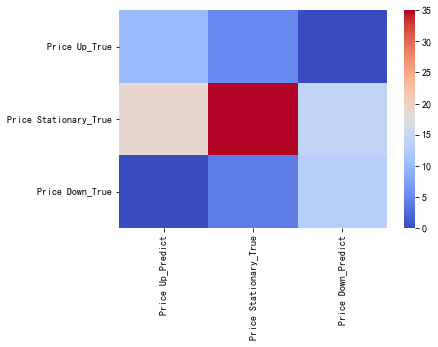

In [385]:
drawConfusion(LogReg["confusion"])

In [386]:
LogRegLasso = logReg(X_lasso_train,y_train,X_lasso_test,y_test)
LogRegLasso

time: 0.12154388427734375
LogisticRegression Model's Training set score: 0.554
LogisticRegression Model's Test set score: 0.610


{'accuracy': 0.61,
 'time': 0.12154388427734375,
 'f1': 0.5422824399202352,
 'confusion': array([[ 7,  8,  0],
        [15, 44,  9],
        [ 0,  7, 10]], dtype=int64),
 'trainedModel': LogisticRegression(class_weight={-1: 0.3, 0: 0.2, 1: 0.4}),
 'y_pred': array([ 1.,  1.,  0.,  1., -1., -1.,  1.,  0., -1., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1., -1.,  1.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1.,  1., -1., -1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  1.,  0.,
         0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0., -1., -1.,  0.,  1.,
         1., -1.,  1.,  0.,  0.,  0.,  0., -1.,  1.,  0., -1., -1.,  0.,
         0.,  1., -1., -1.,  0.,  0.,  1., -1., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         7                      8   
Price Stationary_True                15                     44   
Price Down_True                       0                      7   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   9  
Price Down_True                        10  


<AxesSubplot:>

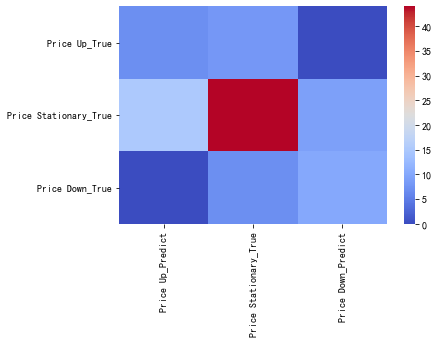

In [387]:
drawConfusion(LogRegLasso["confusion"])

In [388]:
LogRegPCA = logReg(X_pca_train,y_train,X_pca_test,y_test)
LogRegPCA

time: 0.06457304954528809
LogisticRegression Model's Training set score: 0.547
LogisticRegression Model's Test set score: 0.620


{'accuracy': 0.62,
 'time': 0.06457304954528809,
 'f1': 0.5847188592951306,
 'confusion': array([[10,  5,  0],
        [17, 40, 11],
        [ 0,  5, 12]], dtype=int64),
 'trainedModel': LogisticRegression(class_weight={-1: 0.3, 0: 0.2, 1: 0.4}),
 'y_pred': array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1.,  1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  1.,  0.,
         0.,  0.,  1., -1.,  1.,  1.,  1.,  0.,  0., -1., -1., -1.,  1.,
         1., -1.,  1.,  0.,  0.,  0.,  1., -1.,  1.,  1., -1., -1., -1.,
        -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                        10                      5   
Price Stationary_True                17                     40   
Price Down_True                       0                      5   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                  11  
Price Down_True                        12  


<AxesSubplot:>

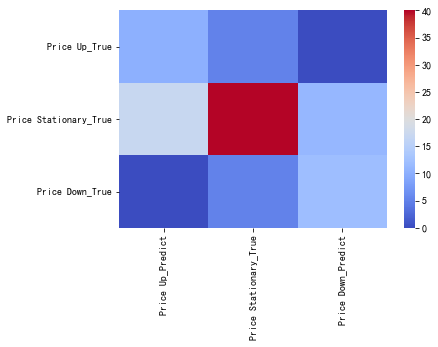

In [389]:
drawConfusion(LogRegPCA["confusion"])

## 7.2 DecisionTree

In [390]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


#决策树调参
def decTreeTuning(X_train,y_train,X_test,y_test):
    # max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    # min_samples_split: The minimum number of samples required to split an internal node.
    # min_samples_leaf: The minimum number of samples required to be at a leaf node
    # max_leaf_nodes: The maximum number of leaf nodes
    tree = DecisionTreeClassifier(random_state = 0)
    param_DT = {"max_depth": [10,15],
           "min_samples_split": [10,20,50],}
    grid_tree = GridSearchCV(tree,param_DT,cv=5)
    
    
    result = getMultiLearningResult(grid_tree,X_train,y_train,X_test,y_test)
    grid_tree = result["trainedModel"]
    
    print("\ntree.best_params:",grid_tree.best_params_)
    
    return result

decTreeTuning(X_lasso_train,y_train,X_lasso_test,y_test)

time: 0.3199894428253174
GridSearchCV Model's Training set score: 0.688
GridSearchCV Model's Test set score: 0.610

tree.best_params: {'max_depth': 10, 'min_samples_split': 20}


{'accuracy': 0.61,
 'time': 0.3199894428253174,
 'f1': 0.4671883916197929,
 'confusion': array([[ 5, 10,  0],
        [10, 51,  7],
        [ 0, 12,  5]], dtype=int64),
 'trainedModel': GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
              param_grid={'max_depth': [10, 15],
                          'min_samples_split': [10, 20, 50]}),
 'y_pred': array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -1., -1., -1.,
        -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

In [391]:
#决策树分类
def decTree(X_train,y_train,X_test,y_test):
    # max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    # min_samples_split: The minimum number of samples required to split an internal node.
    # min_samples_leaf: The minimum number of samples required to be at a leaf node
    # max_leaf_nodes: The maximum number of leaf nodes
    tree = DecisionTreeClassifier(random_state = 0,max_depth=10,min_samples_split=20)    
    result = getMultiLearningResult(tree,X_train,y_train,X_test,y_test)
    tree = result["trainedModel"]

    
    return result


DecTree ={}
DecTree = decTree(X_train,y_train,X_test,y_test)
DecTree

time: 0.2120068073272705
DecisionTreeClassifier Model's Training set score: 0.756
DecisionTreeClassifier Model's Test set score: 0.550


{'accuracy': 0.55,
 'time': 0.2120068073272705,
 'f1': 0.3667098333765,
 'confusion': array([[ 4, 11,  0],
        [11, 49,  8],
        [ 0, 15,  2]], dtype=int64),
 'trainedModel': DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=0),
 'y_pred': array([ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0., -1.,  1.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         1.,  0.,  0., -1.,  1.,  1.,  0.,  0.,  0., -1., -1.,  0.,  1.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., -1., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         4                     11   
Price Stationary_True                11                     49   
Price Down_True                       0                     15   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   8  
Price Down_True                         2  


<AxesSubplot:>

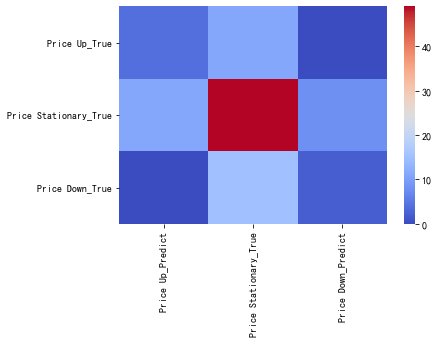

In [392]:
drawConfusion(DecTree["confusion"])

In [393]:
DecTreeLasso = decTree(X_lasso_train,y_train,X_lasso_test,y_test)
DecTreeLasso

time: 0.012001991271972656
DecisionTreeClassifier Model's Training set score: 0.688
DecisionTreeClassifier Model's Test set score: 0.610


{'accuracy': 0.61,
 'time': 0.012001991271972656,
 'f1': 0.4671883916197929,
 'confusion': array([[ 5, 10,  0],
        [10, 51,  7],
        [ 0, 12,  5]], dtype=int64),
 'trainedModel': DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=0),
 'y_pred': array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -1., -1., -1.,
        -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         5                     10   
Price Stationary_True                10                     51   
Price Down_True                       0                     12   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   7  
Price Down_True                         5  


<AxesSubplot:>

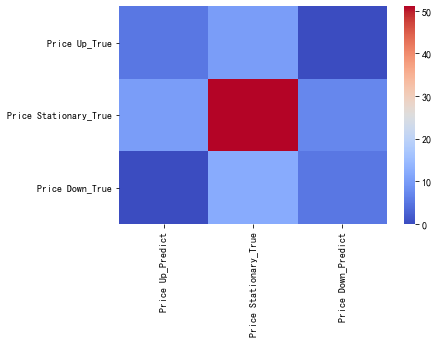

In [394]:
drawConfusion(DecTreeLasso["confusion"])

In [395]:
DecTreePCA = decTree(X_pca_train,y_train,X_pca_test,y_test)
DecTreePCA

time: 0.06399989128112793
DecisionTreeClassifier Model's Training set score: 0.717
DecisionTreeClassifier Model's Test set score: 0.620


{'accuracy': 0.62,
 'time': 0.06399989128112793,
 'f1': 0.4897542261867631,
 'confusion': array([[10,  5,  0],
        [16, 49,  3],
        [ 0, 14,  3]], dtype=int64),
 'trainedModel': DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=0),
 'y_pred': array([ 1.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0., -1., -1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0., -1.,  0., -1., -1., -1.,  1., -1.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0., -1., -1.,  0.,
        -1.,  0., -1., -1.,  0., -1.,  0., -1., -1.,  0., -1.,  0.,  0.,
        -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                        10                      5   
Price Stationary_True                16                     49   
Price Down_True                       0                     14   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   3  
Price Down_True                         3  


<AxesSubplot:>

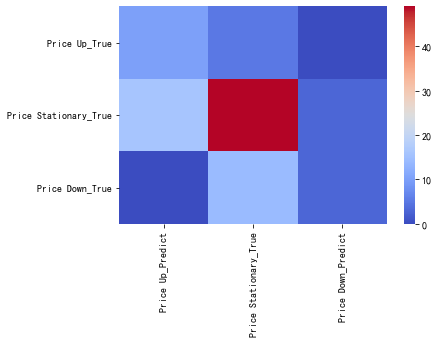

In [396]:
drawConfusion(DecTreePCA["confusion"])

## 7.3 KNN分类

In [397]:
from sklearn.neighbors import KNeighborsClassifier


#KNN调参
def kNNTuning(X_train,y_train,X_test,y_test):
    #n_neighbors: The nearest n neighbors to decide its class
    knn = KNeighborsClassifier()
    param_DT = {"n_neighbors": [20,30]}
    grid_knn = GridSearchCV(knn,param_DT,cv=5)
        
    result = getMultiLearningResult(grid_knn,X_train,y_train,X_test,y_test)
    grid_knn = result["trainedModel"]
    
    print("\nknn.best_params:",grid_knn.best_params_)
    
    return result
    
kNNTuning(X_train,y_train,X_test,y_test)



time: 0.7387585639953613
GridSearchCV Model's Training set score: 0.622
GridSearchCV Model's Test set score: 0.650

knn.best_params: {'n_neighbors': 30}


{'accuracy': 0.65,
 'time': 0.7387585639953613,
 'f1': 0.4243533372945138,
 'confusion': array([[ 4, 11,  0],
        [ 6, 59,  3],
        [ 0, 15,  2]], dtype=int64),
 'trainedModel': GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
              param_grid={'n_neighbors': [20, 30]}),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0., -1.,  0.,  1.,  0.,  0.,  0., -1., -1.,  0.,  0.,
         1., -1.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0., -1.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

In [398]:
### KNN分类
def kNN(X_train,y_train,X_test,y_test):
    #n_neighbors: The nearest n neighbors to decide its class
    knn = KNeighborsClassifier(n_neighbors=30)
      
    result = getMultiLearningResult(knn,X_train,y_train,X_test,y_test)
    grid_knn = result["trainedModel"]

    
    return result
    





KNN = kNN(X_train,y_train,X_test,y_test)
KNN

time: 0.002000093460083008
KNeighborsClassifier Model's Training set score: 0.622
KNeighborsClassifier Model's Test set score: 0.650


{'accuracy': 0.65,
 'time': 0.002000093460083008,
 'f1': 0.4243533372945138,
 'confusion': array([[ 4, 11,  0],
        [ 6, 59,  3],
        [ 0, 15,  2]], dtype=int64),
 'trainedModel': KNeighborsClassifier(n_neighbors=30),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0., -1.,  0.,  1.,  0.,  0.,  0., -1., -1.,  0.,  0.,
         1., -1.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0., -1.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         4                     11   
Price Stationary_True                 6                     59   
Price Down_True                       0                     15   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   3  
Price Down_True                         2  


<AxesSubplot:>

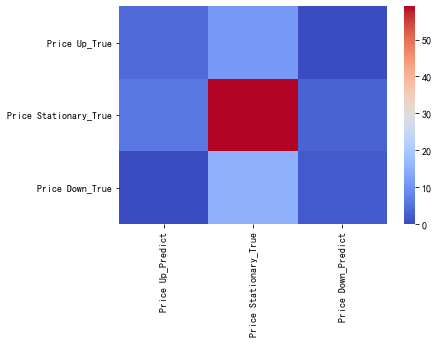

In [399]:
drawConfusion(KNN["confusion"])

In [400]:
KNNLasso = kNN(X_lasso_train,y_train,X_lasso_test,y_test)
KNNLasso

time: 0.014999866485595703
KNeighborsClassifier Model's Training set score: 0.631
KNeighborsClassifier Model's Test set score: 0.670


{'accuracy': 0.67,
 'time': 0.014999866485595703,
 'f1': 0.44132601179581044,
 'confusion': array([[ 9,  6,  0],
        [ 9, 58,  1],
        [ 0, 17,  0]], dtype=int64),
 'trainedModel': KNeighborsClassifier(n_neighbors=30),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         9                      6   
Price Stationary_True                 9                     58   
Price Down_True                       0                     17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   1  
Price Down_True                         0  


<AxesSubplot:>

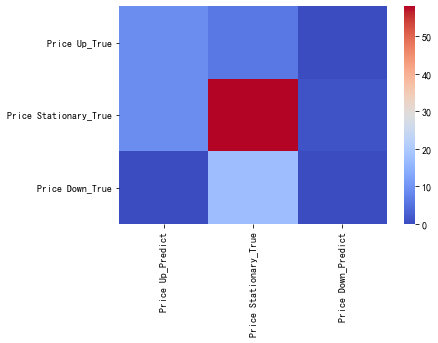

In [401]:
drawConfusion(KNNLasso["confusion"])

In [402]:
KNNPCA = kNN(X_pca_train,y_train,X_pca_test,y_test)
KNNPCA

time: 0.0009992122650146484
KNeighborsClassifier Model's Training set score: 0.621
KNeighborsClassifier Model's Test set score: 0.650


{'accuracy': 0.65,
 'time': 0.0009992122650146484,
 'f1': 0.4243533372945138,
 'confusion': array([[ 4, 11,  0],
        [ 6, 59,  3],
        [ 0, 15,  2]], dtype=int64),
 'trainedModel': KNeighborsClassifier(n_neighbors=30),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0., -1.,  0.,  1.,  0.,  0.,  0., -1., -1.,  0.,  0.,
         1., -1.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0., -1.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         4                     11   
Price Stationary_True                 6                     59   
Price Down_True                       0                     15   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   3  
Price Down_True                         2  


<AxesSubplot:>

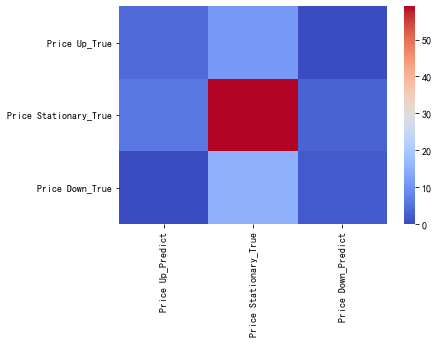

In [403]:
drawConfusion(KNNPCA["confusion"])

## 7.4 Naive Bayes分类

In [404]:
#导入NB模型，并对训练集进行训练
from sklearn.naive_bayes import BernoulliNB

def naiveBayes(X_train,y_train,X_test,y_test):
    nb = BernoulliNB()
    result = getMultiLearningResult(nb,X_train,y_train,X_test,y_test)
    nb = result["trainedModel"]
    return result



NB ={}
NB = naiveBayes(X_train,y_train,X_test,y_test)
NB


time: 0.011079072952270508
BernoulliNB Model's Training set score: 0.535
BernoulliNB Model's Test set score: 0.560


{'accuracy': 0.56,
 'time': 0.011079072952270508,
 'f1': 0.4561403508771929,
 'confusion': array([[ 5, 10,  0],
        [10, 44, 14],
        [ 0, 10,  7]], dtype=int64),
 'trainedModel': BernoulliNB(),
 'y_pred': array([ 1.,  1.,  0.,  1., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0., -1.,  1.,  1.,  1.,  1., -1.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  0.,  0.,  1.,
         1., -1.,  1.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         5                     10   
Price Stationary_True                10                     44   
Price Down_True                       0                     10   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                  14  
Price Down_True                         7  


<AxesSubplot:>

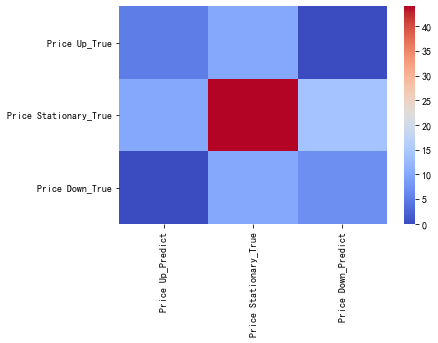

In [405]:
drawConfusion(NB["confusion"])

In [406]:
NBLasso = naiveBayes(X_lasso_train,y_train,X_lasso_test,y_test)
NBLasso

time: 0.0069277286529541016
BernoulliNB Model's Training set score: 0.561
BernoulliNB Model's Test set score: 0.590


{'accuracy': 0.59,
 'time': 0.0069277286529541016,
 'f1': 0.3618874773139746,
 'confusion': array([[ 7,  8,  0],
        [16, 52,  0],
        [ 0, 17,  0]], dtype=int64),
 'trainedModel': BernoulliNB(),
 'y_pred': array([ 0.,  0.,  0.,  0., -1., -1.,  0.,  0., -1., -1.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1., -1.,  0.,
         0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1., -1.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         7                      8   
Price Stationary_True                16                     52   
Price Down_True                       0                     17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         0  


<AxesSubplot:>

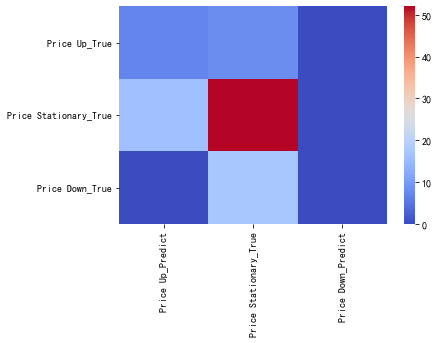

In [407]:
drawConfusion(NBLasso["confusion"])

In [408]:
NBPCA = naiveBayes(X_pca_train,y_train,X_pca_test,y_test)
NBPCA

time: 0.003999948501586914
BernoulliNB Model's Training set score: 0.503
BernoulliNB Model's Test set score: 0.540


{'accuracy': 0.54,
 'time': 0.003999948501586914,
 'f1': 0.44523210993799234,
 'confusion': array([[ 5, 10,  0],
        [16, 42, 10],
        [ 0, 10,  7]], dtype=int64),
 'trainedModel': BernoulliNB(),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0., -1., -1., -1.,  0.,  0.,  1.,  0.,
         0., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0., -1., -1.,  1.,
         1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0., -1., -1.,
        -1.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0., -1., -1.,  0.,  0.,
         0., -1., -1.,  0.,  0.,  1.,  1.,  1.,  1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         5                     10   
Price Stationary_True                16                     42   
Price Down_True                       0                     10   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                  10  
Price Down_True                         7  


<AxesSubplot:>

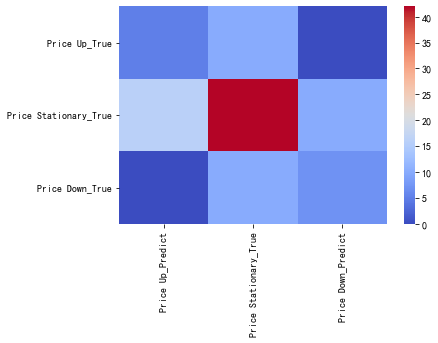

In [409]:
drawConfusion(NBPCA["confusion"])

## 7.5 SVM

### 7.5.1 Linear SVM

In [410]:
from sklearn.svm import LinearSVC

def linearSVMTuning(X_train,y_train,X_test,y_test):
    #define a list of parameters
    params_svc = {'C': [1,10]}
    linear_svc = LinearSVC()
    grid_svc = GridSearchCV(linear_svc, params_svc, cv=3, n_jobs=-1,scoring = 'f1_macro', return_train_score=True)
    
    
    result = getMultiLearningResult(grid_svc,X_train,y_train,X_test,y_test)
    grid_svc = result["trainedModel"]
    
    print(grid_svc.best_params_)
    return result





linearSVMTuning(X_train,y_train,X_test,y_test)


time: 13.434575080871582
GridSearchCV Model's Training set score: 0.318
GridSearchCV Model's Test set score: 0.308
{'C': 10}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'accuracy': 0.69,
 'time': 13.434575080871582,
 'f1': 0.30849412286538036,
 'confusion': array([[ 0, 15,  0],
        [ 0, 68,  0],
        [ 0, 16,  1]], dtype=int64),
 'trainedModel': GridSearchCV(cv=3, estimator=LinearSVC(), n_jobs=-1, param_grid={'C': [1, 10]},
              return_train_score=True, scoring='f1_macro'),
 'y_pred': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [411]:
from sklearn.svm import LinearSVC

def linearSVM(X_train,y_train,X_test,y_test):
    linear_svc = LinearSVC(C=1)
   
        
    result = getMultiLearningResult(linear_svc,X_train,y_train,X_test,y_test)
    linear_svc = result["trainedModel"]
    
    return result




LinearSVM ={}
LinearSVM= linearSVM(X_train,y_train,X_test,y_test)
LinearSVM

time: 4.302230358123779
LinearSVC Model's Training set score: 0.623
LinearSVC Model's Test set score: 0.590


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'accuracy': 0.59,
 'time': 4.302230358123779,
 'f1': 0.3711823161024735,
 'confusion': array([[ 3, 12,  0],
        [11, 54,  3],
        [ 0, 15,  2]], dtype=int64),
 'trainedModel': LinearSVC(C=1),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  1.,
         0., -1.,  1.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1., -1., -1.,
         0.,  0., -1., -1.,  0.,  0.,  0., -1., -1., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         3                     12   
Price Stationary_True                11                     54   
Price Down_True                       0                     15   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   3  
Price Down_True                         2  


<AxesSubplot:>

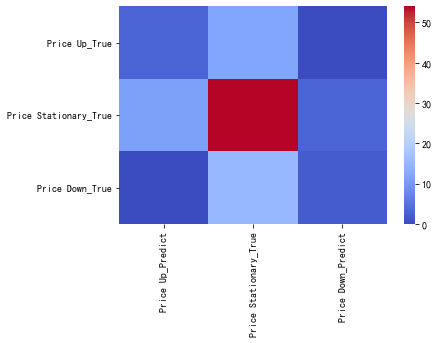

In [412]:
drawConfusion(LinearSVM["confusion"])

In [413]:
LinearSVMLasso = linearSVM(X_lasso_train,y_train,X_lasso_test,y_test)
LinearSVMLasso

time: 0.07999944686889648
LinearSVC Model's Training set score: 0.604
LinearSVC Model's Test set score: 0.690


{'accuracy': 0.69,
 'time': 0.07999944686889648,
 'f1': 0.37509738046547864,
 'confusion': array([[ 1, 14,  0],
        [ 0, 66,  2],
        [ 0, 15,  2]], dtype=int64),
 'trainedModel': LinearSVC(C=1),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         1                     14   
Price Stationary_True                 0                     66   
Price Down_True                       0                     15   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   2  
Price Down_True                         2  


<AxesSubplot:>

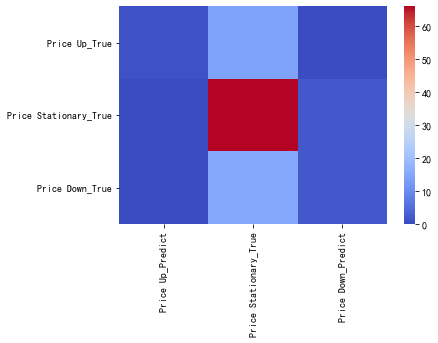

In [414]:
drawConfusion(LinearSVMLasso["confusion"])

In [415]:
LinearSVMPCA = linearSVM(X_pca_train,y_train,X_pca_test,y_test)
LinearSVMPCA

time: 0.2426929473876953
LinearSVC Model's Training set score: 0.599
LinearSVC Model's Test set score: 0.680


{'accuracy': 0.68,
 'time': 0.2426929473876953,
 'f1': 0.3082919914953933,
 'confusion': array([[ 1, 14,  0],
        [ 1, 67,  0],
        [ 0, 17,  0]], dtype=int64),
 'trainedModel': LinearSVC(C=1),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         1                     14   
Price Stationary_True                 1                     67   
Price Down_True                       0                     17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         0  


<AxesSubplot:>

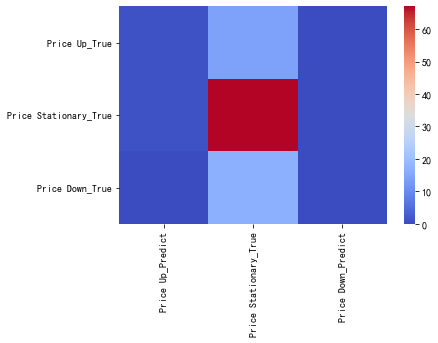

In [416]:
drawConfusion(LinearSVMPCA["confusion"])

### 7.5.2 Kernel SVM

In [417]:
from sklearn.svm import SVC

def kernelSVMTuning(X_train,y_train,X_test,y_test):
    
    svc_kernel = SVC(kernel = 'rbf')
    #define a list of parameters
    param_svc_kernel = {'C': [20,30,30],'gamma':[0.01,0.05,0.1]}
    #apply grid search
    grid_svc_kernel = GridSearchCV(svc_kernel, param_svc_kernel, cv=5, n_jobs=-1, scoring='f1_macro')
    
    
    result = getMultiLearningResult(grid_svc_kernel,X_train,y_train,X_test,y_test)
    grid_svc_kernel = result["trainedModel"]
    
    print(grid_svc_kernel.best_params_)
    return result




kernelSVMTuning(X_train,y_train,X_test,y_test)


time: 39.01170349121094
GridSearchCV Model's Training set score: 0.580
GridSearchCV Model's Test set score: 0.368
{'C': 20, 'gamma': 0.1}


{'accuracy': 0.63,
 'time': 39.01170349121094,
 'f1': 0.3676658402824731,
 'confusion': array([[ 5, 10,  0],
        [ 9, 58,  1],
        [ 0, 17,  0]], dtype=int64),
 'trainedModel': GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
              param_grid={'C': [20, 30, 30], 'gamma': [0.01, 0.05, 0.1]},
              scoring='f1_macro'),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1., -1.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

In [418]:
from sklearn.svm import SVC

def kernelSVM(X_train,y_train,X_test,y_test):
    
    svc_kernel = SVC(kernel = 'rbf',C= 20, gamma= 0.1)
 
    
    result = getMultiLearningResult(svc_kernel,X_train,y_train,X_test,y_test)
    grid_svc_kernel = result["trainedModel"]

    return result



KernelSVM= kernelSVM(X_train,y_train,X_test,y_test)
KernelSVM



time: 1.3117189407348633
SVC Model's Training set score: 0.684
SVC Model's Test set score: 0.630


{'accuracy': 0.63,
 'time': 1.3117189407348633,
 'f1': 0.3676658402824731,
 'confusion': array([[ 5, 10,  0],
        [ 9, 58,  1],
        [ 0, 17,  0]], dtype=int64),
 'trainedModel': SVC(C=20, gamma=0.1),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1., -1.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         5                     10   
Price Stationary_True                 9                     58   
Price Down_True                       0                     17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   1  
Price Down_True                         0  


<AxesSubplot:>

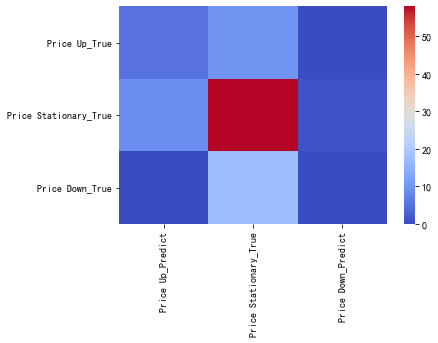

In [419]:
drawConfusion(KernelSVM["confusion"])

In [420]:
KernelSVMLasso= kernelSVM(X_lasso_train,y_train,X_lasso_test,y_test)
KernelSVMLasso

time: 0.5502064228057861
SVC Model's Training set score: 0.616
SVC Model's Test set score: 0.700


{'accuracy': 0.7,
 'time': 0.5502064228057861,
 'f1': 0.3806910569105691,
 'confusion': array([[ 1, 14,  0],
        [ 0, 67,  1],
        [ 0, 15,  2]], dtype=int64),
 'trainedModel': SVC(C=20, gamma=0.1),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         1                     14   
Price Stationary_True                 0                     67   
Price Down_True                       0                     15   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   1  
Price Down_True                         2  


<AxesSubplot:>

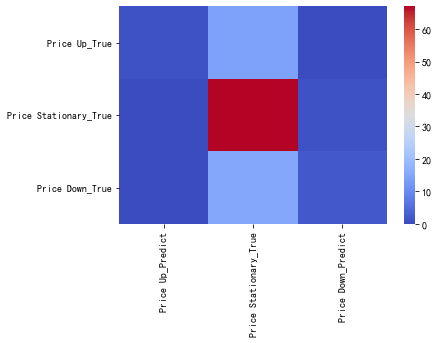

In [421]:
drawConfusion(KernelSVMLasso["confusion"])

In [422]:
KernelSVMPCA = kernelSVM(X_pca_train,y_train,X_pca_test,y_test)
KernelSVMPCA

time: 0.6467127799987793
SVC Model's Training set score: 0.653
SVC Model's Test set score: 0.660


{'accuracy': 0.66,
 'time': 0.6467127799987793,
 'f1': 0.3494565217391305,
 'confusion': array([[ 3, 12,  0],
        [ 5, 63,  0],
        [ 0, 17,  0]], dtype=int64),
 'trainedModel': SVC(C=20, gamma=0.1),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         3                     12   
Price Stationary_True                 5                     63   
Price Down_True                       0                     17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         0  


<AxesSubplot:>

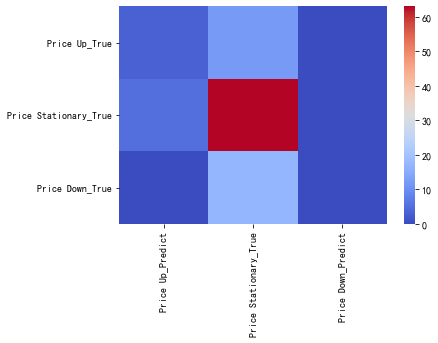

In [423]:
drawConfusion(KernelSVMPCA["confusion"])

##  Ensemble Models

## 7.6 Random Forest

In [424]:
from sklearn.ensemble import RandomForestClassifier

def randomForest(X_train,y_train,X_test,y_test):
    
    rnd_clf = RandomForestClassifier(n_estimators=500, max_depth = 10,min_samples_split = 20, n_jobs=-1, random_state=42)
    # max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    # min_samples_split: The minimum number of samples required to split an internal node.
    # min_samples_leaf: The minimum number of samples required to be at a leaf node
    # max_leaf_nodes: The maximum number of leaf nodes

    result = getMultiLearningResult(rnd_clf,X_train,y_train,X_test,y_test)
    rnd_clf = result["trainedModel"]
        
    return result



RandomForest ={}
RandomForest = randomForest(X_train,y_train,X_test,y_test)
RandomForest




time: 0.8524351119995117
RandomForestClassifier Model's Training set score: 0.767
RandomForestClassifier Model's Test set score: 0.660


{'accuracy': 0.66,
 'time': 0.8524351119995117,
 'f1': 0.30126467931345985,
 'confusion': array([[ 1, 14,  0],
        [ 2, 65,  1],
        [ 0, 17,  0]], dtype=int64),
 'trainedModel': RandomForestClassifier(max_depth=10, min_samples_split=20, n_estimators=500,
                        n_jobs=-1, random_state=42),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         1                     14   
Price Stationary_True                 2                     65   
Price Down_True                       0                     17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   1  
Price Down_True                         0  


<AxesSubplot:>

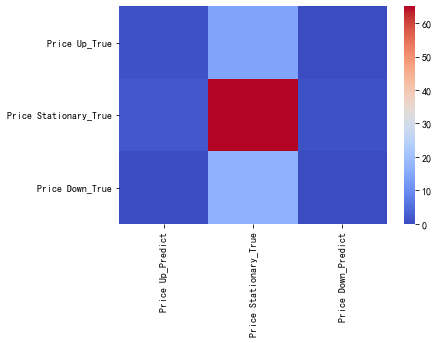

In [425]:
drawConfusion(RandomForest["confusion"])

In [426]:
RandomForestLasso = randomForest(X_lasso_train,y_train,X_lasso_test,y_test)
RandomForestLasso

time: 0.5956578254699707
RandomForestClassifier Model's Training set score: 0.702
RandomForestClassifier Model's Test set score: 0.650


{'accuracy': 0.65,
 'time': 0.5956578254699707,
 'f1': 0.41387073347857667,
 'confusion': array([[ 5, 10,  0],
        [ 7, 59,  2],
        [ 0, 16,  1]], dtype=int64),
 'trainedModel': RandomForestClassifier(max_depth=10, min_samples_split=20, n_estimators=500,
                        n_jobs=-1, random_state=42),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  1.,  0.,  0.,  0., -1., -1.,  0.,  0.,
         1., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1., -1.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         5                     10   
Price Stationary_True                 7                     59   
Price Down_True                       0                     16   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   2  
Price Down_True                         1  


<AxesSubplot:>

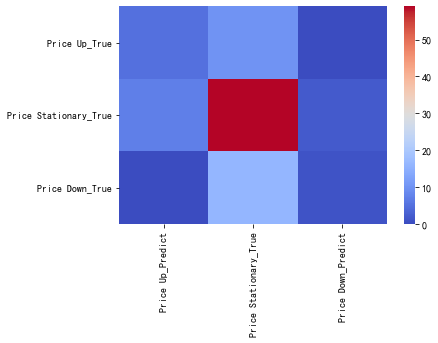

In [427]:
drawConfusion(RandomForestLasso["confusion"])

In [428]:
RandomForestPCA = randomForest(X_pca_train,y_train,X_pca_test,y_test)
RandomForestPCA

time: 0.804009199142456
RandomForestClassifier Model's Training set score: 0.760
RandomForestClassifier Model's Test set score: 0.710


{'accuracy': 0.71,
 'time': 0.804009199142456,
 'f1': 0.45124938755512006,
 'confusion': array([[ 7,  8,  0],
        [ 4, 64,  0],
        [ 0, 17,  0]], dtype=int64),
 'trainedModel': RandomForestClassifier(max_depth=10, min_samples_split=20, n_estimators=500,
                        n_jobs=-1, random_state=42),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,
        -1.,  0.,  0., -1.,  0., -1.,  0.,  0., -1.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         7                      8   
Price Stationary_True                 4                     64   
Price Down_True                       0                     17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         0  


<AxesSubplot:>

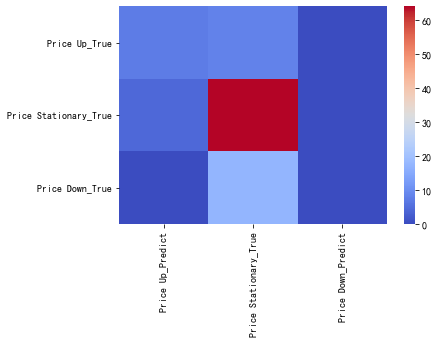

In [429]:
drawConfusion(RandomForestPCA["confusion"])

## 7.7 Voting Classifier

In [430]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def voting(X_train,y_train,X_test,y_test):
    
    log_clf = LogisticRegression(solver="liblinear", random_state=42)
    rnd_clf = RandomForestClassifier(n_estimators=50, random_state=42)
    svm_clf = SVC(gamma="auto",  probability=True,random_state=42)
    
    voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting='hard')

    # If ‘hard’, uses predicted class labels for majority rule voting. 
    # Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.
    
    result = getMultiLearningResult(voting_clf,X_train,y_train,X_test,y_test)
    voting_clf = result["trainedModel"]
    
    for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
        
    return result
    


Voting ={}
Voting = voting(X_train,y_train,X_test,y_test)
Voting


time: 8.409696817398071
VotingClassifier Model's Training set score: 0.648
VotingClassifier Model's Test set score: 0.660
LogisticRegression 0.59
RandomForestClassifier 0.63
SVC 0.68
VotingClassifier 0.66


{'accuracy': 0.66,
 'time': 8.409696817398071,
 'f1': 0.3494565217391305,
 'confusion': array([[ 3, 12,  0],
        [ 5, 63,  0],
        [ 0, 17,  0]], dtype=int64),
 'trainedModel': VotingClassifier(estimators=[('lr',
                               LogisticRegression(random_state=42,
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(n_estimators=50,
                                                      random_state=42)),
                              ('svc',
                               SVC(gamma='auto', probability=True,
                                   random_state=42))]),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         3                     12   
Price Stationary_True                 5                     63   
Price Down_True                       0                     17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         0  


<AxesSubplot:>

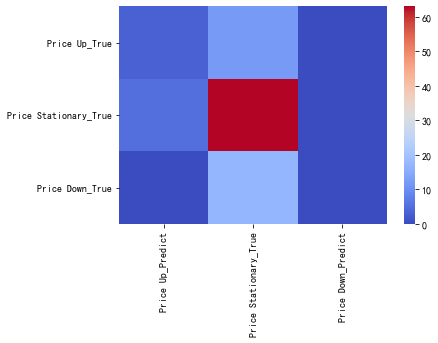

In [431]:
drawConfusion(Voting["confusion"])

In [432]:
VotingLasso = voting(X_lasso_train,y_train,X_lasso_test,y_test)
VotingLasso

time: 2.9848928451538086
VotingClassifier Model's Training set score: 0.615
VotingClassifier Model's Test set score: 0.690
LogisticRegression 0.69
RandomForestClassifier 0.56
SVC 0.68
VotingClassifier 0.69


{'accuracy': 0.69,
 'time': 2.9848928451538086,
 'f1': 0.34746145667198297,
 'confusion': array([[ 1, 14,  0],
        [ 0, 67,  1],
        [ 0, 16,  1]], dtype=int64),
 'trainedModel': VotingClassifier(estimators=[('lr',
                               LogisticRegression(random_state=42,
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(n_estimators=50,
                                                      random_state=42)),
                              ('svc',
                               SVC(gamma='auto', probability=True,
                                   random_state=42))]),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         1                     14   
Price Stationary_True                 0                     67   
Price Down_True                       0                     16   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   1  
Price Down_True                         1  


<AxesSubplot:>

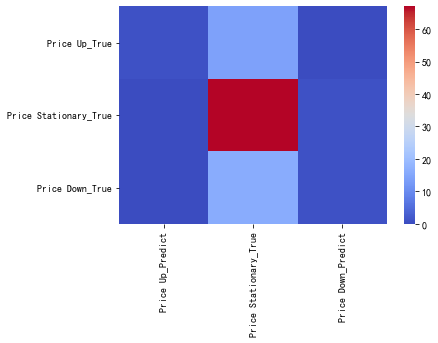

In [433]:
drawConfusion(VotingLasso["confusion"])

In [434]:
VotingPCA = voting(X_pca_train,y_train,X_pca_test,y_test)
VotingPCA

time: 3.537837028503418
VotingClassifier Model's Training set score: 0.624
VotingClassifier Model's Test set score: 0.700
LogisticRegression 0.68
RandomForestClassifier 0.68
SVC 0.68
VotingClassifier 0.7


{'accuracy': 0.7,
 'time': 3.537837028503418,
 'f1': 0.38346883468834686,
 'confusion': array([[ 2, 13,  0],
        [ 1, 67,  0],
        [ 0, 16,  1]], dtype=int64),
 'trainedModel': VotingClassifier(estimators=[('lr',
                               LogisticRegression(random_state=42,
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(n_estimators=50,
                                                      random_state=42)),
                              ('svc',
                               SVC(gamma='auto', probability=True,
                                   random_state=42))]),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         2                     13   
Price Stationary_True                 1                     67   
Price Down_True                       0                     16   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         1  


<AxesSubplot:>

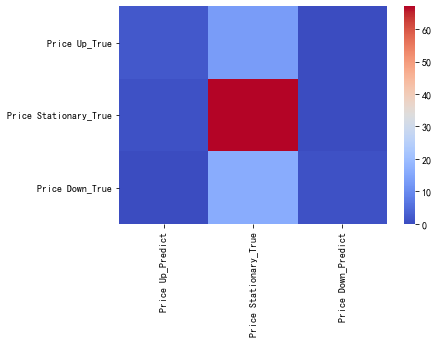

In [435]:
drawConfusion(VotingPCA["confusion"])

## 7.8  AdaBoost

In [436]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

def adaBoost(X_train,y_train,X_test,y_test):
    
    ada_clf = AdaBoostClassifier(
        LogisticRegression(class_weight={-1: 0.3,0: 0.2, 1: 0.4}), n_estimators=500,algorithm="SAMME.R", learning_rate=0.01, random_state=42)    
    result = getMultiLearningResult(ada_clf,X_train,y_train,X_test,y_test)
    ada_clf = result["trainedModel"]
        
    return result


AdaBoost = adaBoost(X_train,y_train,X_test,y_test)
AdaBoost



time: 16.73745059967041
AdaBoostClassifier Model's Training set score: 0.594
AdaBoostClassifier Model's Test set score: 0.680


{'accuracy': 0.68,
 'time': 16.73745059967041,
 'f1': 0.2698412698412698,
 'confusion': array([[ 0, 15,  0],
        [ 0, 68,  0],
        [ 0, 17,  0]], dtype=int64),
 'trainedModel': AdaBoostClassifier(base_estimator=LogisticRegression(class_weight={-1: 0.3,
                                                                    0: 0.2,
                                                                    1: 0.4}),
                    learning_rate=0.01, n_estimators=500, random_state=42),
 'y_pred': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         0                     15   
Price Stationary_True                 0                     68   
Price Down_True                       0                     17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         0  


<AxesSubplot:>

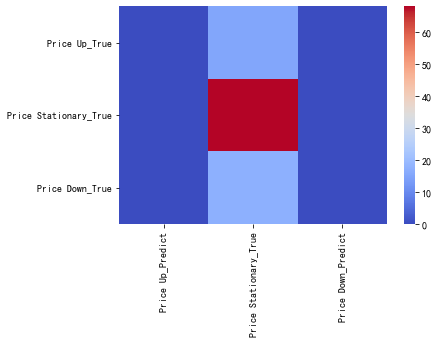

In [437]:
drawConfusion(AdaBoost["confusion"])

In [438]:
AdaBoostLasso = adaBoost(X_lasso_train,y_train,X_lasso_test,y_test)
AdaBoostLasso

time: 9.115317583084106
AdaBoostClassifier Model's Training set score: 0.594
AdaBoostClassifier Model's Test set score: 0.680


{'accuracy': 0.68,
 'time': 9.115317583084106,
 'f1': 0.2698412698412698,
 'confusion': array([[ 0, 15,  0],
        [ 0, 68,  0],
        [ 0, 17,  0]], dtype=int64),
 'trainedModel': AdaBoostClassifier(base_estimator=LogisticRegression(class_weight={-1: 0.3,
                                                                    0: 0.2,
                                                                    1: 0.4}),
                    learning_rate=0.01, n_estimators=500, random_state=42),
 'y_pred': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         0                     15   
Price Stationary_True                 0                     68   
Price Down_True                       0                     17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         0  


<AxesSubplot:>

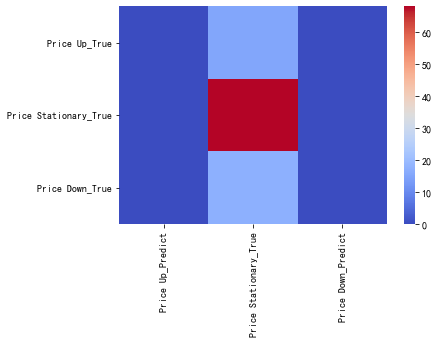

In [439]:
drawConfusion(AdaBoostLasso["confusion"])

In [440]:
AdaBoostPCA = adaBoost(X_pca_train,y_train,X_pca_test,y_test)
AdaBoostPCA

time: 8.481768369674683
AdaBoostClassifier Model's Training set score: 0.594
AdaBoostClassifier Model's Test set score: 0.680


{'accuracy': 0.68,
 'time': 8.481768369674683,
 'f1': 0.2698412698412698,
 'confusion': array([[ 0, 15,  0],
        [ 0, 68,  0],
        [ 0, 17,  0]], dtype=int64),
 'trainedModel': AdaBoostClassifier(base_estimator=LogisticRegression(class_weight={-1: 0.3,
                                                                    0: 0.2,
                                                                    1: 0.4}),
                    learning_rate=0.01, n_estimators=500, random_state=42),
 'y_pred': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         0                     15   
Price Stationary_True                 0                     68   
Price Down_True                       0                     17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         0  


<AxesSubplot:>

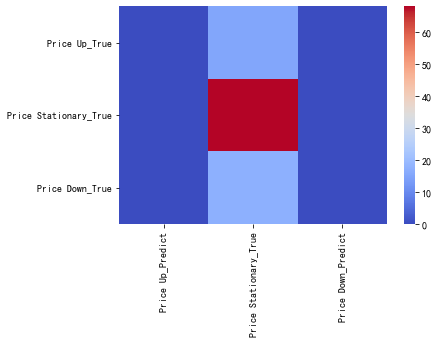

In [441]:
drawConfusion(AdaBoostPCA["confusion"])

## 7.9 Deep Learning

In [110]:
#引入对应的包
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

input_unit_size = X_test.shape[1]
num_classes = 3
# one-hot representation
y_train_encode = utils.to_categorical(y_train, num_classes)
y_test_encode = utils.to_categorical(y_test, num_classes)

# 构建好神经网络结构，其中丢失率可调
def create_network(dropout_rate=0.3):
    
    # Start neural network
    network = models.Sequential()
    network.add(layers.Dense(500, input_dim=input_unit_size, activation='relu'))
    network.add(layers.Dropout(dropout_rate))
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=64, activation='relu', input_shape=(input_unit_size,)))
    # Add a dropout layer for previous hidden layer
    network.add(layers.Dropout(dropout_rate))
    
    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=num_classes, activation='softmax'))

    # Compile neural network
    network.compile(loss='categorical_crossentropy', # categorical_crossentropy
                    optimizer='adadelta', # Optimizer
                    metrics=["accuracy","categorical_accuracy"]) # Accuracy performance metric
    
    # Return compiled network
    return network



create_network()

In [111]:
#设置不同的dropout rate 和learning_rate
from keras.wrappers.scikit_learn import KerasClassifier


# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_network)

# Create hyperparameter space
dropout_rate = [0.2,0.3,0.4,0.5,0.6]

# Create hyperparameter options
hyperparameters = dict(dropout_rate=dropout_rate)

C:\Users\reborn\AppData\Local\Temp\ipykernel_25032\1363783624.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neural_network = KerasClassifier(build_fn=create_network)


In [112]:

from sklearn.model_selection import GridSearchCV
import time

def deepLearning(X_train,y_train_encode,X_test,y_test,neural_network,hyperparameters):
    # Create grid search，三折
    grid = GridSearchCV(estimator=neural_network, cv=3, param_grid=hyperparameters)

    # Training
    start_time = time.time()
    grid_result = grid.fit(X_train, # Features
                          y_train_encode, # Target vector
#                           epochs=20, # epochs
                          verbose=1) 
    t = time.time() - start_time
    
    #accuracy = logreg.score(X_test, y_test)
    y_pred = grid_result.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred,average = "macro")
    
    #grid_search选出最优超参数
    print(grid_result.best_params_)
    print("time:", t)
    
    return {'accuracy': accuracy, 'time': t,  'f1': f1, 'confusion': confusion, 'trainedModel': grid_result,"y_pred":y_pred}    

DeepLearning = deepLearning(X_train,y_train_encode,X_test,y_test,neural_network,hyperparameters)
    

DeepLearning

4/4 [==============================] - 0s 1ms/step
{'dropout_rate': 0.2}
time: 13.280563116073608


{'accuracy': 0.64,
 'time': 13.280563116073608,
 'f1': 0.32903225806451614,
 'confusion': array([[ 0, 12,  3],
        [ 0, 61,  7],
        [ 0, 14,  3]], dtype=int64),
 'trainedModel': GridSearchCV(cv=3,
              estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000002667F9690A0>,
              param_grid={'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6]}),
 'y_pred': array([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         0                     12   
Price Stationary_True                 0                     61   
Price Down_True                       0                     14   

                       Price Down_Predict  
Price Up_True                           3  
Price Stationary_True                   7  
Price Down_True                         3  


<AxesSubplot:>

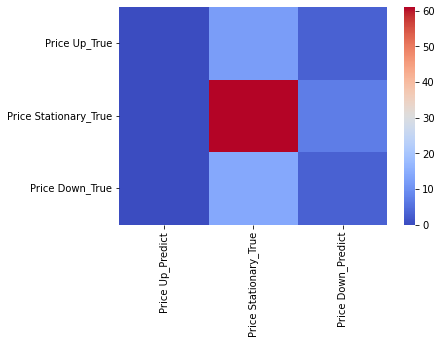

In [155]:
drawConfusion(DeepLearning["confusion"])

# 8. 机器学习模型综合比较

## 8.1 原始特征综合比较

In [442]:
#LogReg DecTree KNN NB LinearSVM KernelSVM RandomForest Voting AdaBoost DeepLearning

metrics = {"accuracy","time","f1","confusion"}
dat = {
    'Logistic Regression':{key: value for key, value in LogReg.items() if key in metrics},
    'Decision Tree':{key: value for key, value in DecTree.items() if key in metrics},
    'KNN':{key: value for key, value in KNN.items() if key in metrics},
    'Naive Bayesian':{key: value for key, value in NB.items() if key in metrics},
    'Linear SVM':{key: value for key, value in LinearSVM.items() if key in metrics},
    'Kernel SVM':{key: value for key, value in KernelSVM.items() if key in metrics},
    'Random Forest':{key: value for key, value in RandomForest.items() if key in metrics},
    'Voting Ensemble':{key: value for key, value in Voting.items() if key in metrics},
    'AdaBoost':{key: value for key, value in AdaBoost.items() if key in metrics},
    'Deep Learning':{key: value for key, value in DeepLearning.items() if key in metrics},
} 

pd.DataFrame(dat)





,Logistic Regression,Decision Tree,KNN,Naive Bayesian,Linear SVM,Kernel SVM,Random Forest,Voting Ensemble,AdaBoost,Deep Learning
accuracy,0.58,0.55,0.65,0.56,0.59,0.63,0.66,0.66,0.68,0.64
time,0.191828,0.212007,0.002,0.011079,4.30223,1.311719,0.852435,8.409697,16.737451,13.280563
f1,0.556818,0.36671,0.424353,0.45614,0.371182,0.367666,0.301265,0.349457,0.269841,0.329032
confusion,"[[10, 5, 0], [19, 35, 14], [0, 4, 13]]","[[4, 11, 0], [11, 49, 8], [0, 15, 2]]","[[4, 11, 0], [6, 59, 3], [0, 15, 2]]","[[5, 10, 0], [10, 44, 14], [0, 10, 7]]","[[3, 12, 0], [11, 54, 3], [0, 15, 2]]","[[5, 10, 0], [9, 58, 1], [0, 17, 0]]","[[1, 14, 0], [2, 65, 1], [0, 17, 0]]","[[3, 12, 0], [5, 63, 0], [0, 17, 0]]","[[0, 15, 0], [0, 68, 0], [0, 17, 0]]","[[0, 12, 3], [0, 61, 7], [0, 14, 3]]"


## 8.2 Lasso筛选后特征综合比较

In [443]:
#LogReg DecTree KNN NB LinearSVM KernelSVM RandomForest Voting AdaBoost DeepLearning

metrics = {"accuracy","time","f1","confusion"}
dat_lasso = {
    'Logistic Regression ( Lasso Selection )':{key: value for key, value in LogRegLasso.items() if key in metrics},
    'Decision Tree ( Lasso Selection )':{key: value for key, value in DecTreeLasso.items() if key in metrics},
    'KNN ( Lasso Selection )':{key: value for key, value in KNNLasso.items() if key in metrics},
    'Naive Bayesian ( Lasso Selection )':{key: value for key, value in NBLasso.items() if key in metrics},
    'Linear SVM ( Lasso Selection )':{key: value for key, value in LinearSVMLasso.items() if key in metrics},
    'Kernel SVM ( Lasso Selection )':{key: value for key, value in KernelSVMLasso.items() if key in metrics},
    'Random Forest ( Lasso Selection )':{key: value for key, value in RandomForestLasso.items() if key in metrics},
    'Voting Ensemble ( Lasso Selection )':{key: value for key, value in VotingLasso.items() if key in metrics},
    'AdaBoost ( Lasso Selection )':{key: value for key, value in AdaBoostLasso.items() if key in metrics}
} 

pd.DataFrame(dat_lasso)

,Logistic Regression ( Lasso Selection ),Decision Tree ( Lasso Selection ),KNN ( Lasso Selection ),Naive Bayesian ( Lasso Selection ),Linear SVM ( Lasso Selection ),Kernel SVM ( Lasso Selection ),Random Forest ( Lasso Selection ),Voting Ensemble ( Lasso Selection ),AdaBoost ( Lasso Selection )
accuracy,0.61,0.61,0.67,0.59,0.69,0.7,0.65,0.69,0.68
time,0.121544,0.012002,0.015,0.006928,0.079999,0.550206,0.595658,2.984893,9.115318
f1,0.542282,0.467188,0.441326,0.361887,0.375097,0.380691,0.413871,0.347461,0.269841
confusion,"[[7, 8, 0], [15, 44, 9], [0, 7, 10]]","[[5, 10, 0], [10, 51, 7], [0, 12, 5]]","[[9, 6, 0], [9, 58, 1], [0, 17, 0]]","[[7, 8, 0], [16, 52, 0], [0, 17, 0]]","[[1, 14, 0], [0, 66, 2], [0, 15, 2]]","[[1, 14, 0], [0, 67, 1], [0, 15, 2]]","[[5, 10, 0], [7, 59, 2], [0, 16, 1]]","[[1, 14, 0], [0, 67, 1], [0, 16, 1]]","[[0, 15, 0], [0, 68, 0], [0, 17, 0]]"


## 8.3 PCA降维后特征综合比较

In [444]:
#LogReg DecTree KNN NB LinearSVM KernelSVM RandomForest Voting AdaBoost DeepLearning


metrics = {"accuracy","time","f1","confusion"}
dat_pca = {
    'Logistic Regression':{key: value for key, value in LogRegPCA.items() if key in metrics},
    'Decision Tree':{key: value for key, value in DecTreePCA.items() if key in metrics},
    'KNN':{key: value for key, value in KNNPCA.items() if key in metrics},
    'Naive Bayesian':{key: value for key, value in NBPCA.items() if key in metrics},
    'Linear SVM':{key: value for key, value in LinearSVMPCA.items() if key in metrics},
    'Kernel SVM':{key: value for key, value in KernelSVMPCA.items() if key in metrics},
    'Random Forest':{key: value for key, value in RandomForestPCA.items() if key in metrics},
    'Voting Ensemble':{key: value for key, value in VotingPCA.items() if key in metrics},
    'AdaBoost':{key: value for key, value in AdaBoostPCA.items() if key in metrics}
} 

pd.DataFrame(dat_pca)

,Logistic Regression,Decision Tree,KNN,Naive Bayesian,Linear SVM,Kernel SVM,Random Forest,Voting Ensemble,AdaBoost
accuracy,0.62,0.62,0.65,0.54,0.68,0.66,0.71,0.7,0.68
time,0.064573,0.064,0.000999,0.004,0.242693,0.646713,0.804009,3.537837,8.481768
f1,0.584719,0.489754,0.424353,0.445232,0.308292,0.349457,0.451249,0.383469,0.269841
confusion,"[[10, 5, 0], [17, 40, 11], [0, 5, 12]]","[[10, 5, 0], [16, 49, 3], [0, 14, 3]]","[[4, 11, 0], [6, 59, 3], [0, 15, 2]]","[[5, 10, 0], [16, 42, 10], [0, 10, 7]]","[[1, 14, 0], [1, 67, 0], [0, 17, 0]]","[[3, 12, 0], [5, 63, 0], [0, 17, 0]]","[[7, 8, 0], [4, 64, 0], [0, 17, 0]]","[[2, 13, 0], [1, 67, 0], [0, 16, 1]]","[[0, 15, 0], [0, 68, 0], [0, 17, 0]]"


从模型上进行比较：经过对比可以发现，Logistic回归的整体效果是最好的，f1值最高，且时间相对较短。接下来就是Naive Bayesian，KNN和Decision Tree这些简单模型，表现都还行，且时间较短。相反的，SVM表现很一般，几个集成模型和深度学习模型都耗时长且效果差。

从不同变量筛选方式来看，两个方法效果都比较好，都缩短了时间：PCA筛选后除了Linear SVM的f1下降较为明显下降外，其余均未明显下降，甚至决策树，Voting,和Random Forest都有明显提升。Lasso筛选后除了Naive Bayesian的f1下降较为明显下降外，其余均未明显下降，甚至决策树，Voting,和Random Forest,KNN等都有明显提升。

从多个维度整体来看，表现最好的是原始数据训练得到的Logistic Regression模型，我们下阶段就以此模型进行股票价格预测并生成策略。

# 9. 策略生成

## 9.1 获得股价与预测序列

In [445]:
train,test = pairs[-1,0],pairs[-1,1]

In [446]:
#获得股票价格序列
price_sequence = test[:,-4]
price_sequence

array([20.74, 20.74, 20.74, 20.73, 20.74, 20.74, 20.73, 20.73, 20.74,
       20.74, 20.74, 20.74, 20.74, 20.74, 20.74, 20.74, 20.73, 20.73,
       20.75, 20.74, 20.74, 20.74, 20.74, 20.75, 20.75, 20.75, 20.75,
       20.75, 20.76, 20.75, 20.76, 20.76, 20.76, 20.76, 20.76, 20.76,
       20.75, 20.75, 20.76, 20.76, 20.76, 20.76, 20.76, 20.76, 20.76,
       20.76, 20.76, 20.75, 20.76, 20.76, 20.75, 20.76, 20.76, 20.76,
       20.76, 20.77, 20.76, 20.76, 20.76, 20.76, 20.76, 20.77, 20.77,
       20.77, 20.76, 20.76, 20.77, 20.76, 20.77, 20.77, 20.77, 20.77,
       20.78, 20.77, 20.77, 20.78, 20.78, 20.78, 20.78, 20.77, 20.78,
       20.78, 20.78, 20.78, 20.77, 20.78, 20.78, 20.78, 20.78, 20.77,
       20.77, 20.77, 20.77, 20.77, 20.77, 20.77, 20.77, 20.77, 20.77,
       20.77])

In [447]:
price_sequence.shape

(100,)

In [448]:
#Logistic Regression模型的预测序列
prediction_sequence = LogReg["y_pred"]
prediction_sequence.astype(int)
prediction_sequence 

array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
        1.,  0., -1.,  1., -1., -1.,  0.,  0.,  0.,  0.,  1.,  1., -1.,
        0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  1.,  0.,
        0.,  0.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,
        1., -1.,  1.,  0.,  0.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,
       -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  0.,  0.,
        0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  0.])

In [449]:
prediction_sequence.shape 

(100,)

Text(0, 0.5, 'Trading Price')

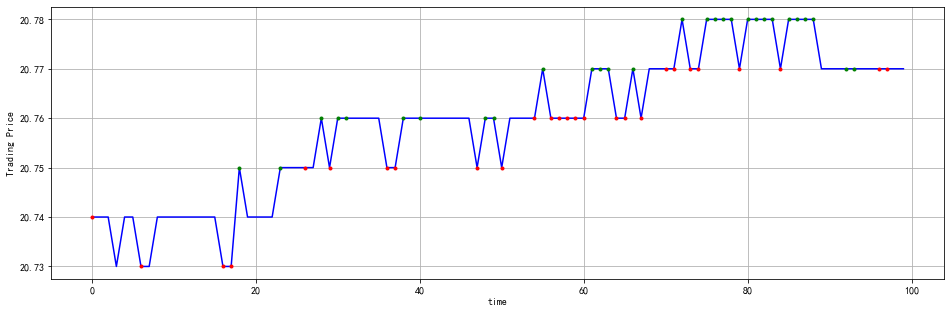

In [460]:
#这里画出了预测结果，蓝线是测试集中的交易价格时间序列，红点表示模型预测下一时刻方向向上，
#绿点表示模型预测下一时刻方向向下，没有画点表示预测方向不变。
numTest = len(price_sequence)

pUpTest = np.where(prediction_sequence==1)[0]
pDownTest = np.where(prediction_sequence==-1)[0]
pStatTest = np.where(prediction_sequence==0)[0]

plt.figure(figsize=(16,5))
plt.plot(range(numTest),price_sequence,'b-',pUpTest,price_sequence[pUpTest],'r.',pDownTest,price_sequence[pDownTest],'g.')
plt.grid()
plt.xlabel('time')
plt.ylabel('Trading Price')

## 9.2 不同策略生成价值序列

### 9.2.1 策略一——相反信号区间买入或卖空

给定初始资金，价格与预测序列与融券保证金比例，得到对应价值序列

持有本金，知道遇见1，则全部买入股票，一直持有知道下一个-1信号或期末卖出；
如果是-1，则按保证金比率全部融券卖空，直到遇见下一个1信号或期末卖出；
如果是0，则什么也不做。

这个方法相对交易次数少，可以减少交易费用，开始得到信号建仓，之后得到相反有利信号才平仓。

In [451]:
def getStrategySequence_1(capital,price_sequence,prediction_sequence,short_rate = 0.5):
    length = len(price_sequence)-2
    start_idx = 0
    end_idx = 0
    shares = 0
    account_sequence = np.zeros(length+2)
    account_sequence[0]=capital#初始为本金
    while (start_idx<=length):
        if(prediction_sequence[start_idx]>0):
            print(str(start_idx)+"买入")
            account_sequence[start_idx] = capital#此时开始买入
            shares += capital/price_sequence[start_idx]
            capital = 0
            end_idx = start_idx+1
            while(end_idx<= length and prediction_sequence[end_idx] != -1 ):
                account_sequence[end_idx] = shares*price_sequence[end_idx]#多头股票，价格随股票变化
                end_idx += 1
            if(prediction_sequence[end_idx] == -1):
                capital = shares*price_sequence[end_idx]
            else:
                capital = shares*price_sequence[-1]
            print(str(end_idx)+"卖出")
            account_sequence[end_idx] = capital #股票均卖出，账上为现金
            start_idx = end_idx+1 
            shares = 0 #清空股票    
        elif(prediction_sequence[start_idx]<0):
            print(str(start_idx)+"卖空")
            account_sequence[start_idx] = capital#此时开始卖空
            shares -= capital/(short_rate*price_sequence[start_idx])#按照保证金比例融券卖空,shares为负数
            capital += price_sequence[start_idx]*(-shares)
            end_idx = start_idx+1
            while(end_idx<= length and prediction_sequence[end_idx] != 1 ):
                account_sequence[end_idx] = capital+shares*price_sequence[end_idx]#空头股票，价格随股票变化
                end_idx += 1
            if(prediction_sequence[end_idx] == 1):
                capital += shares*price_sequence[end_idx]
            else:
                capital += shares*price_sequence[-1]
            print(str(end_idx)+"赎回")
            account_sequence[end_idx] = capital #股票均赎回，账上为现金
            start_idx = end_idx+1 
            shares = 0 #清空股票    
        else:
            account_sequence[start_idx] = capital #空仓未进行任何操作
            start_idx +=1#空仓预测不变不操作
    return account_sequence     

strategy1 = getStrategySequence_1(100,price_sequence,prediction_sequence)
strategy1 

0买入
18卖出
23卖空
26赎回
28卖空
29赎回
30卖空
36赎回
37买入
38卖出
40卖空
47赎回
48卖空
50赎回
54买入
55卖出
56买入
61卖出
62卖空
64赎回
65买入
66卖出
67买入
72卖出
73买入
75卖出
76卖空
79赎回
80卖空
84赎回
85卖空
96赎回
97买入
99卖出


array([100.        , 100.        , 100.        ,  99.95178399,
       100.        , 100.        ,  99.95178399,  99.95178399,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
        99.95178399,  99.95178399, 100.04821601, 100.04821601,
       100.04821601, 100.04821601, 100.04821601, 100.04821601,
       100.04821601, 100.04821601, 100.04821601, 100.04821601,
       100.04821601, 100.14460157, 100.14460157, 100.14460157,
       100.14460157, 100.14460157, 100.14460157, 100.14460157,
       100.24107999, 100.24107999, 100.28938895, 100.28938895,
       100.28938895, 100.28938895, 100.28938895, 100.28938895,
       100.28938895, 100.28938895, 100.28938895, 100.38600686,
       100.38600686, 100.38600686, 100.48271785, 100.48271785,
       100.48271785, 100.48271785, 100.48271785, 100.53111993,
       100.53111993, 100.53111993, 100.53111993, 100.53111993,
       100.53111993, 100.57954532, 100.57954532, 100.57

### 9.2.2 策略二——根据信号立刻做1期买入或卖空交易

给定初始资金，价格与预测序列与融券保证金比例，得到对应价值序列

持有本金，知道遇见1，则全部买入股票，并在下一期卖出；
如果是-1，则按保证金比率全部融券卖空，并在下一期赎回；
如果是0，则什么也不做。

这个方法相对交易较多，会产生较高交易费用，但得到信号就立刻交易，如果预测准确赚的也更多。

In [453]:
def getStrategySequence_2(capital,price_sequence,prediction_sequence,short_rate = 0.5):
    length = len(price_sequence)-2
    account_sequence = np.zeros(length+2)
    account_sequence[0]=capital#初始为本金
    for idx, val in enumerate(prediction_sequence[:-1]):
        if val > 0:
            print(str(idx)+"买入")
            capital = capital/price_sequence[idx]*price_sequence[idx+1]
        elif val < 0:
            print(str(idx)+"卖空")
            capital = capital+capital/(short_rate*price_sequence[idx])*(price_sequence[idx]-price_sequence[idx+1])
        account_sequence[idx+1]=capital
    return account_sequence
strategy2 = getStrategySequence_2(100,price_sequence,prediction_sequence)
strategy2

0买入
6买入
16买入
17买入
18卖空
23卖空
26买入
28卖空
29买入
30卖空
31卖空
36买入
37买入
38卖空
40卖空
47买入
48卖空
49卖空
50买入
54买入
55卖空
56买入
57买入
58买入
59买入
60买入
61卖空
62卖空
63卖空
64买入
65买入
66卖空
67买入
70买入
71买入
72卖空
73买入
74买入
75卖空
76卖空
77卖空
78卖空
79买入
80卖空
81卖空
82卖空
83卖空
84买入
85卖空
86卖空
87卖空
88卖空
92卖空
93卖空
96买入
97买入


array([100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.09647853, 100.19295707,
       100.19295707, 100.19295707, 100.19295707, 100.19295707,
       100.19295707, 100.19295707, 100.19295707, 100.19295707,
       100.19295707, 100.28948207, 100.33781435, 100.33781435,
       100.33781435, 100.33781435, 100.33781435, 100.33781435,
       100.33781435, 100.33781435, 100.38616993, 100.38616993,
       100.38616993, 100.38616993, 100.38616993, 100.38616993,
       100.38616993, 100.38616993, 100.38616993, 100.38616993,
       100.4345488 , 100.4345488 , 100.53130656, 100.57975538,
       100.57975538, 100.57975538, 100.57975538, 100.6282042 ,
       100.72510185, 100.72510185, 100.72510185, 100.72510185,
       100.72510185, 100.77362068, 100.77362068, 100.77

### 9.2.3 基准线——简单买入并持有

给定初始资金，价格序列，得到对应价值序列

期初初始资金全部买入股票，期末卖出

这个方法不需预测信息，简单买入持有，作为评价基准。

In [452]:
def getHoldingSequence(capital,price_sequence):
    return price_sequence*(capital/price_sequence[0])
benmark = getHoldingSequence(100,price_sequence)
benmark

array([100.        , 100.        , 100.        ,  99.95178399,
       100.        , 100.        ,  99.95178399,  99.95178399,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
        99.95178399,  99.95178399, 100.04821601, 100.        ,
       100.        , 100.        , 100.        , 100.04821601,
       100.04821601, 100.04821601, 100.04821601, 100.04821601,
       100.09643202, 100.04821601, 100.09643202, 100.09643202,
       100.09643202, 100.09643202, 100.09643202, 100.09643202,
       100.04821601, 100.04821601, 100.09643202, 100.09643202,
       100.09643202, 100.09643202, 100.09643202, 100.09643202,
       100.09643202, 100.09643202, 100.09643202, 100.04821601,
       100.09643202, 100.09643202, 100.04821601, 100.09643202,
       100.09643202, 100.09643202, 100.09643202, 100.14464802,
       100.09643202, 100.09643202, 100.09643202, 100.09643202,
       100.09643202, 100.14464802, 100.14464802, 100.14

# 10. 策略效果与回测

## 10.1 累计收益曲线

In [454]:
#从价格序列得到收益率序列
def getReturnRate(price_series):
    rate_series = (price_series[1:]-price_series[:-1])/price_series[:-1]
    return rate_series
getReturnRate(strategy2)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.64785335e-04,  9.63855422e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.41834867e-16,  0.00000000e+00,
        9.63391137e-04,  4.81927711e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.81927711e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.81927711e-04,
        0.00000000e+00,  9.63391137e-04,  4.81927711e-04,  0.00000000e+00,
        0.00000000e+00,  

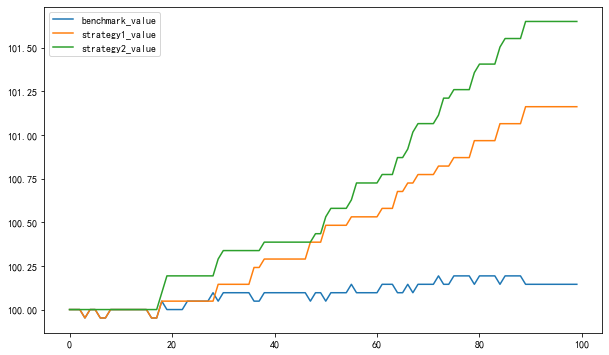

In [455]:
# 绘制3个策略价格曲线
plt.figure(figsize=(10,6))
plt.plot(benmark, label='benchmark_value')
plt.plot(strategy1, label='strategy1_value')
plt.plot(strategy2, label='strategy2_value')
         
plt.legend()
plt.show()

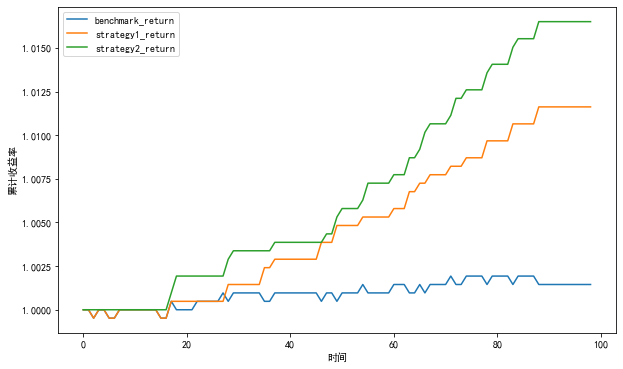

In [456]:
# 绘制3个策略累计收益曲线
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10,6))
plt.plot((getReturnRate(benmark)+1).cumprod(), label='benchmark_return')
plt.plot((getReturnRate(strategy1)+1).cumprod(), label='strategy1_return')
plt.plot((getReturnRate(strategy2)+1).cumprod(), label='strategy2_return')
plt.xlabel('时间')
plt.ylabel('累计收益率')
plt.legend()
plt.show()

可以看到收益：策略2>策略1>买入并持有策略。
本次回测未考虑交易费用，主要用于示范股价方向预测的策略有效性，策略2交易次数较多，实际情况下可能收益率会被手续费吃掉很多。

## 10.2 其他回测指标

In [457]:
# 定义函数求各项回测指标
def ratio(rateSeries):
    data = pd.DataFrame(rateSeries)
    
    day_seconds = ((2+1)*60+57)*60
    interval_seconds = 3
    t = day_seconds//interval_seconds

    
    # 累积收益率        
    strategy_cum = (data + 1).cumprod()
    # 日化收益率      
    return_avg = data.mean()* t 
    # 日化波动率
    volatility = data.std() * t ** 0.5
    # 单次最大收益
    profit_max = data.max()
    # 单次最大损失
    loss_max = data.min()
    # 每日夏普比率               
    ir = return_avg / volatility
    # 上涨次数
    num_of_up = data[data > 0].count()
    # 下跌次数
    num_of_down = data[data < 0].count()
    # 胜率
    win_rate = float(num_of_up) / (num_of_up + num_of_down)
    # 上涨时平均收益率
    gain_of_up = data[data > 0].mean()
    # 下跌时平均收益率        
    loss_of_down = data[data < 0].mean()
    # 盈亏比
    profit_loss_ratio = -(gain_of_up / loss_of_down)
    # 最大回撤
    drawdown = ((strategy_cum.cummax() - strategy_cum)/strategy_cum.cummax()).max()
    
    # 创建DataFrame
    merge_dt_dict = {'Information Ratio':ir,
                 'Cumulative Return':float((strategy_cum).tail(1)[0]),
                'Daily return':return_avg,
                'Daily Volatility':volatility, 'Maximum Profit':profit_max, 
                              'Maximum Loss':loss_max, 'Number of Up Periods': num_of_up, 'Number of Down Periods':num_of_down, 'Win Rate':win_rate, 'Avg Gain in Up Periods':gain_of_up, 
                              'Avg Loss in Down Periods':loss_of_down, 'Profit and Loss Ratio':profit_loss_ratio, 'Maximum Drawdown':  drawdown    
                    }

    data_df = pd.DataFrame(merge_dt_dict)
    # 返回DataFrame
    return data_df
ratio(getReturnRate(strategy2))


,Information Ratio,Cumulative Return,Daily return,Daily Volatility,Maximum Profit,Maximum Loss,Number of Up Periods,Number of Down Periods,Win Rate,Avg Gain in Up Periods,Avg Loss in Down Periods,Profit and Loss Ratio,Maximum Drawdown
0,35.160366,1.016503,0.783987,0.022297,0.000965,-1.404081e-16,25,1,0.961538,0.000655,-1.404081e-16,4.664804e+12,2.193877e-16


In [458]:
res = []
res.append(ratio(getReturnRate(benmark))) 
res.append(ratio(getReturnRate(strategy1))) 
res.append(ratio(getReturnRate(strategy2))) 

backtest = pd.concat(res,axis=0,join='inner')
backtest.index = ["benmark","strategy1","strategy2"]
backtest

,Information Ratio,Cumulative Return,Daily return,Daily Volatility,Maximum Profit,Maximum Loss,Number of Up Periods,Number of Down Periods,Win Rate,Avg Gain in Up Periods,Avg Loss in Down Periods,Profit and Loss Ratio,Maximum Drawdown
benmark,3.505449,1.001446,0.069400,0.019798,0.000965,-4.821601e-04,17,15,0.531250,0.000510,-4.816339e-04,1.059385e+00,4.821601e-04
strategy1,25.436125,1.011620,0.553412,0.021757,0.000965,-4.821601e-04,22,6,0.785714,0.000591,-2.410800e-04,2.452051e+00,4.821601e-04
strategy2,35.160366,1.016503,0.783987,0.022297,0.000965,-1.404081e-16,25,1,0.961538,0.000655,-1.404081e-16,4.664804e+12,2.193877e-16


在忽略交易费用基础上：
买入并持有策略日化收益率达到了6.9%，相对一般股票而言也很高，且日化波动率和最大回撤极低，夏普比为3.5。胜率超过53%，略超过一半，体现了该股票本身价格的上升。只有开始和结束两次换仓，节省了手续费。

策略2拥有相当不错的收益率，日化收益率达到了78.39%，且波动率和最大回撤极低，夏普比很高达到了35.16。胜率超过96%，即总体而言预测正确的概率约为96%，体现了模型对高频股价预测的有效性。但是也存在很大的问题：共有52次换仓，每日换仓将导致巨大的手续费，这将极大冲抵收益。

策略1也有相当不错的收益率，日化收益率达到了55.34%，且日化波动率和最大回撤极低，夏普比很高达到了25.43。胜率超过78%，即总体而言预测正确的概率约为78%，体现了模型对高频股价预测的有效性。且换仓次数相对策略2大幅减小：共有34次换仓，优于策略2。属于一种适中的策略

通过对以上策略的对比我们可以发现，训练所获得的模型极大程度帮助我们制定了优秀的交易策略，该模型不仅预测有效还很有应用价值。

# 研究二：买卖方向_Trdirec变动方向预测

## 引言  

  我本次研究就是通过多种机器学习算法（logistic回归、决策树、KNN、朴素贝叶斯、SVM、随机森林、Voting Ensemble、Adaboost等多种方法）预测高频场景股价下一个3s的变动方向，并利用做出的预测生成可盈利的高频交易策略。

## 研究问题

  从“Modeling high-frequency limit order book dynamics with support vector machines——Alec N.Kercheval October 24, 2013”这篇文献中了解到，相对于日频数据，高频的股票数据价格方向具有更少的随机性从而更好预测。由于我国股市T+0制度、缺少撮合商统一交易所结算等原因限制，我国高频量化目前主要集中在期货市场，更加激发我想尝试利用学到的各种机器学习算法去预测高频场景A股市场的买卖方向（向上B，向下S）。而当能够预测股票价格变动的方向，便可因此构建策略，交易获利。

## 数据集

  RESSET测试数据集是tick级别的level2股票数据，可以用来进行高频股票数据价格方向的训练与预测：是万达股票在深交所的数据。共有100000条，包含了26个交易日早市和午市的level2快照数据，交易时间每3s更新一次。Features则主要包含了十裆买卖报价与需求量，成交价与成交量等 51个维度，具体如下：
  
  
  ['观测序号_nobs', '交易所标识()_Exchflg', '代码_Code', '代码与市场标识_Code_Mkt',
       '证券名称_Secunm', '修改时间_MTime', '行情时间_QTime', '行情日期_Qdate',
       '前收盘价(元)_PrevClPr', '开盘价(元)_Oppr', '最高价(元)_Hipr', '最低价(元)_Lopr',
       '成交价(元)_TPrice', '成交量(股)_TVolume', '成交额(元)_TSum', '成交笔数()_TDeals',
       '累计成交量_TVolume_accu', '累计成交额(元)_TSum_accu', '累计成交笔数()_TDeals_accu',
       '市盈率1()_PE1', '市盈率2()_PE2', '价格升跌1()_ChangePCT1', '价格升跌2()_ChangePCT2',
       '合约持仓量()_OpInterest', '买价1(元)_Bidpr1', '买价2(元)_Bidpr2', '买价3(元)_Bidpr3',
       '买价4(元)_Bidpr4', '买价5(元)_Bidpr5', '买入数量1(股)_Bidvol1',
       '买入数量2(股)_Bidvol2', '买入数量3(股)_Bidvol3', '买入数量4(股)_Bidvol4',
       '买入数量5(股)_Bidvol5', '卖价1(元)_Askpr1', '卖价2(元)_Askpr2', '卖价3(元)_Askpr3',
       '卖价4(元)_Askpr4', '卖价5(元)_Askpr5', '卖出数量1(股)_Askvol1',
       '卖出数量2(股)_Askvol2', '卖出数量3(股)_Askvol3', '卖出数量4(股)_Askvol4',
       '卖出数量5(股)_Askvol5', '买卖方向_Trdirec', '绝对买卖报价差(元)_Absspread',
       '相对买卖报价差(元)_Respread', '绝对有效买卖报价差(元)_Abseffspread',
       '相对有效买卖报价差(元)_Reeffspread', '深度1(元)_Depth1', '深度2(元)_Depth2']
       

## 方法：
    
   使用模型：
    
   Logistic回归、决策树分类、KNN分类、Naive Bayes分类、Linear SVM，Kernel SVM、集成模型（随机森林、Voting Classifier、AdaBoost）深度学习
    
    
   变量降维：
    
   lasso筛选、PCA分析
    
    
    
   使用Metrics：
   
   accuracy，f1score（macro加权），训练时间t，混淆矩阵
    
    
   调参：
   
   K折验证、gridsearch
   
   
   数据加工：
   
   规避未来数据的归一化处理、滞后项加速度项产生、新特征生成
   
   
   数据集处理：
   
   首先找出所有交易时段，同时剔除集合竞价交易时段，只保留连续竞价时段用于训练。
   将筛选合成的数据，按时间顺序滚动分割为给定数量的训练集与测试集，并以给定步长向前滚动，生成多组训练测试集。
   
   
   预测结果应用：
   
   交易策略编写与回测
   
  
  
## 研究过程：

  首先对数据进行导入并可视化展示，并对变量进行精简、清洗数据
  
  接下来是特征工程：将原始特征集的特征按照问题逻辑加工获得多种有效特征，截面加工后提取出滞后项与加速度项并作为新特征。
  
  然后对数据集进行划分，首先进行时间段划分，划分出每一段连续竞价的区间，这是模型可以应用的场景；其次对数据集进行合成，将大数据集按时间顺序滚动分割为给定数量的训练集与测试集，并以给定步长向前滚动，生成多组训练测试集。
 
  为加快收敛，避免量纲差异大对数据进行归一化处理，由于进行金融序列进行训练预测时，使用某一特征的最大最小、平均与方差相当于使用了未来数据，而这会导致模型失效，故采用使用前n期历史数据对本期数据进行归一化处理。
  
  由于经过如上加工产生的变量维度过高达到280条，分别使用Lasso进行变量筛选以及主成分分析进行数据降维，分别生成对应降维后的数据，用于后续训练使用。
  
  接下来，进行评价标准的建立，由于类别在样本不均衡且不同类别策略指导意义与计算资源消耗不同，本次研究除了常规accuracy外，还将f1score（macro加权），训练时间，混淆矩阵加入评价标准进行比较。同时编写统一模型训练评价接口函数，与混淆矩阵热力图函数，方便后续研究。
  
  然后，便是分别尝试使用各种机器学习模型进行调参（使用gridsearch 和k折验证），确定最优超参数进行训练，并记录结果，绘制热力图。先后尝试了Logistic回归、决策树分类、KNN分类、Naive Bayes分类、Linear SVM，Kernel SVM等方法。并尝试使用集成模型，如随机森林，集成了logistic、随机森林与SVM的Voting Classifier，以及以logistic回归作为元分类器的AdaBoost，最终还训练了三层神经网络进行训练与预测。


 ## 研究结果
 
  在完成以上的训练与预测后，我对各种机器学习模型进行综合比较，并在原始数据、Lasso筛选后数据、PCA降维后数据三种情况下进行综合比较，最终确定使用randomForest回归效果最好。


# 1 数据预处理

## 1.1 数据导入与可视化

In [1]:
import numpy as np
import pandas as pd
import pandoc
from matplotlib import pyplot as plt


In [2]:
#获取万达股票在深交所数据
originDataSet = pd.read_csv("RESSET_STKHF2017_000002SZ_1.csv")

In [3]:
originDataSet

,观测序号_nobs,交易所标识()_Exchflg,代码_Code,代码与市场标识_Code_Mkt,证券名称_Secunm,修改时间_MTime,行情时间_QTime,行情日期_Qdate,前收盘价(元)_PrevClPr,开盘价(元)_Oppr,...,卖出数量4(股)_Askvol4,卖出数量5(股)_Askvol5,买卖方向_Trdirec,绝对买卖报价差(元)_Absspread,相对买卖报价差(元)_Respread,绝对有效买卖报价差(元)_Abseffspread,相对有效买卖报价差(元)_Reeffspread,深度1(元)_Depth1,深度2(元)_Depth2,Unnamed: 51
0,1.0,2,2,000002.SZ,万 科Ａ,09:15:08,2017-01-03 09:15:09,2017-01-03,20.55,NaN,...,NaN,NaN,F,0.00,0.000000,NaN,NaN,534560.00,534560.00,NaN
1,2.0,2,2,000002.SZ,万 科Ａ,09:15:17,2017-01-03 09:15:18,2017-01-03,20.55,NaN,...,NaN,NaN,F,0.00,0.000000,NaN,NaN,534560.00,534560.00,NaN
2,3.0,2,2,000002.SZ,万 科Ａ,09:15:26,2017-01-03 09:15:27,2017-01-03,20.55,NaN,...,NaN,NaN,F,0.00,0.000000,NaN,NaN,534560.00,534560.00,NaN
3,4.0,2,2,000002.SZ,万 科Ａ,09:15:44,2017-01-03 09:15:45,2017-01-03,20.55,NaN,...,NaN,NaN,F,0.00,0.000000,NaN,NaN,534560.00,534560.00,NaN
4,5.0,2,2,000002.SZ,万 科Ａ,09:16:05,2017-01-03 09:16:06,2017-01-03,20.55,NaN,...,NaN,NaN,F,0.00,0.000000,NaN,NaN,14332813.80,14332813.80,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996.0,2,2,000002.SZ,万 科Ａ,12:31:36,2017-02-15 11:11:48,2017-02-15,20.91,20.9,...,12200.0,8700.0,S,0.01,0.000481,0.01,0.000481,1500810.28,9150547.98,NaN
99996,99997.0,2,2,000002.SZ,万 科Ａ,12:31:39,2017-02-15 11:11:51,2017-02-15,20.91,20.9,...,12200.0,8700.0,S,0.01,0.000481,0.01,0.000481,1689799.28,9339501.98,NaN
99997,99998.0,2,2,000002.SZ,万 科Ａ,12:31:42,2017-02-15 11:11:54,2017-02-15,20.91,20.9,...,12200.0,8700.0,S,0.01,0.000481,0.01,0.000481,1502869.28,9152571.98,NaN
99998,99999.0,2,2,000002.SZ,万 科Ａ,12:31:44,2017-02-15 11:11:57,2017-02-15,20.91,20.9,...,12200.0,8700.0,S,0.01,0.000481,0.01,0.000481,1513259.28,9202365.98,NaN


In [4]:
originDataSet.columns

Index(['观测序号_nobs', '交易所标识()_Exchflg', '代码_Code', '代码与市场标识_Code_Mkt',
       '证券名称_Secunm', '修改时间_MTime', '行情时间_QTime', '行情日期_Qdate',
       '前收盘价(元)_PrevClPr', '开盘价(元)_Oppr', '最高价(元)_Hipr', '最低价(元)_Lopr',
       '成交价(元)_TPrice', '成交量(股)_TVolume', '成交额(元)_TSum', '成交笔数()_TDeals',
       '累计成交量_TVolume_accu', '累计成交额(元)_TSum_accu', '累计成交笔数()_TDeals_accu',
       '市盈率1()_PE1', '市盈率2()_PE2', '价格升跌1()_ChangePCT1', '价格升跌2()_ChangePCT2',
       '合约持仓量()_OpInterest', '买价1(元)_Bidpr1', '买价2(元)_Bidpr2', '买价3(元)_Bidpr3',
       '买价4(元)_Bidpr4', '买价5(元)_Bidpr5', '买入数量1(股)_Bidvol1',
       '买入数量2(股)_Bidvol2', '买入数量3(股)_Bidvol3', '买入数量4(股)_Bidvol4',
       '买入数量5(股)_Bidvol5', '卖价1(元)_Askpr1', '卖价2(元)_Askpr2', '卖价3(元)_Askpr3',
       '卖价4(元)_Askpr4', '卖价5(元)_Askpr5', '卖出数量1(股)_Askvol1',
       '卖出数量2(股)_Askvol2', '卖出数量3(股)_Askvol3', '卖出数量4(股)_Askvol4',
       '卖出数量5(股)_Askvol5', '买卖方向_Trdirec', '绝对买卖报价差(元)_Absspread',
       '相对买卖报价差(元)_Respread', '绝对有效买卖报价差(元)_Abseffspread',
       '相对有效买卖报价差(元)_Reeff

## 1.2 数据集精简与清洗

In [5]:
#选取出后续分析可能使用的变量
columns_daily = ['前收盘价(元)_PrevClPr', '开盘价(元)_Oppr', '最高价(元)_Hipr', '最低价(元)_Lopr']
columns_price = ['买价1(元)_Bidpr1', '买价2(元)_Bidpr2', '买价3(元)_Bidpr3', '买价4(元)_Bidpr4', '买价5(元)_Bidpr5', '卖价1(元)_Askpr1', '卖价2(元)_Askpr2', '卖价3(元)_Askpr3', '卖价4(元)_Askpr4', '卖价5(元)_Askpr5']
columns_quantity = ['买入数量1(股)_Bidvol1', '买入数量2(股)_Bidvol2', '买入数量3(股)_Bidvol3', '买入数量4(股)_Bidvol4', '买入数量5(股)_Bidvol5', '卖出数量1(股)_Askvol1', '卖出数量2(股)_Askvol2', '卖出数量3(股)_Askvol3', '卖出数量4(股)_Askvol4', '卖出数量5(股)_Askvol5']
columns_trade = ['成交价(元)_TPrice', '成交量(股)_TVolume']
columns_direc = ['买卖方向_Trdirec']
# columns_price = [col for col in originDataSet.columns if '买价' in col or '卖价' in col]
# columns_quantity = [col for col in originDataSet.columns if '买入' in col or '卖出' in col]
# columns_trade = [col for col in originDataSet.columns if '成交' in col]


print(columns_price)
print(columns_quantity)
print(columns_trade)

['买价1(元)_Bidpr1', '买价2(元)_Bidpr2', '买价3(元)_Bidpr3', '买价4(元)_Bidpr4', '买价5(元)_Bidpr5', '卖价1(元)_Askpr1', '卖价2(元)_Askpr2', '卖价3(元)_Askpr3', '卖价4(元)_Askpr4', '卖价5(元)_Askpr5']
['买入数量1(股)_Bidvol1', '买入数量2(股)_Bidvol2', '买入数量3(股)_Bidvol3', '买入数量4(股)_Bidvol4', '买入数量5(股)_Bidvol5', '卖出数量1(股)_Askvol1', '卖出数量2(股)_Askvol2', '卖出数量3(股)_Askvol3', '卖出数量4(股)_Askvol4', '卖出数量5(股)_Askvol5']
['成交价(元)_TPrice', '成交量(股)_TVolume']


In [7]:
def organizeData2(originDataSet,k):
    #将时间转换成时间类型
    originDataSet['行情时间_QTime'] = pd.to_datetime(originDataSet['行情时间_QTime'])
    #将时间列设置为键，并选取变量列
    dataSet = originDataSet.set_index('行情时间_QTime').loc[:,columns_price+columns_quantity+columns_trade+columns_daily+columns_direc]
    #删除买卖方向为空或异常的数据，并转化为0和1
    dataSet = dataSet.dropna(how='any', subset=["买卖方向_Trdirec"])
    dataSet = dataSet.loc[dataSet['买卖方向_Trdirec'].isin(["B","S"])]
    dataSet['买卖方向_Trdirec'] = dataSet['买卖方向_Trdirec'].map(lambda x: 0 if x=="B" else 1)
    #将下一秒买卖方向变成y生成到上一行
    dataSet["y"]=dataSet["买卖方向_Trdirec"].shift(-1)
    dataSet = dataSet.dropna(how='any', subset=["y"])
    #将空白数据填0
    dataSet = dataSet.dropna(how='any')

    return dataSet

dataSet2 = organizeData2(originDataSet,1)    
dataSet2

,买价1(元)_Bidpr1,买价2(元)_Bidpr2,买价3(元)_Bidpr3,买价4(元)_Bidpr4,买价5(元)_Bidpr5,卖价1(元)_Askpr1,卖价2(元)_Askpr2,卖价3(元)_Askpr3,卖价4(元)_Askpr4,卖价5(元)_Askpr5,...,卖出数量4(股)_Askvol4,卖出数量5(股)_Askvol5,成交价(元)_TPrice,成交量(股)_TVolume,前收盘价(元)_PrevClPr,开盘价(元)_Oppr,最高价(元)_Hipr,最低价(元)_Lopr,买卖方向_Trdirec,y
行情时间_QTime,,,,,,,,,,,,,,,,,,,,,
2017-01-03 09:30:06,20.56,20.55,20.54,20.53,20.52,20.59,20.60,20.64,20.65,20.66,...,400.0,2400.0,20.56,36600,20.55,20.55,20.59,20.55,0,1.0
2017-01-03 09:30:09,20.57,20.56,20.55,20.54,20.53,20.59,20.60,20.64,20.65,20.66,...,3200.0,2400.0,20.56,8600,20.55,20.55,20.59,20.55,1,1.0
2017-01-03 09:30:12,20.57,20.56,20.55,20.54,20.53,20.59,20.60,20.64,20.65,20.66,...,3200.0,2400.0,20.56,1000,20.55,20.55,20.59,20.55,1,1.0
2017-01-03 09:30:15,20.56,20.55,20.54,20.53,20.52,20.59,20.60,20.64,20.65,20.66,...,3200.0,2400.0,20.56,20000,20.55,20.55,20.59,20.55,1,0.0
2017-01-03 09:30:18,20.59,20.56,20.55,20.54,20.53,20.60,20.64,20.65,20.66,20.68,...,2400.0,4500.0,20.60,2100,20.55,20.55,20.60,20.55,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-15 11:11:45,20.77,20.76,20.75,20.74,20.73,20.78,20.79,20.80,20.81,20.82,...,12200.0,8700.0,20.77,0,20.91,20.90,20.90,20.71,1,1.0
2017-02-15 11:11:48,20.77,20.76,20.75,20.74,20.73,20.78,20.79,20.80,20.81,20.82,...,12200.0,8700.0,20.77,400,20.91,20.90,20.90,20.71,1,1.0
2017-02-15 11:11:51,20.77,20.76,20.75,20.74,20.73,20.78,20.79,20.80,20.81,20.82,...,12200.0,8700.0,20.77,3100,20.91,20.90,20.90,20.71,1,1.0


## 1.3 数据集重命名

In [9]:
def renameData(dataSet):
    dataSet = dataSet.rename({'买价1(元)_Bidpr1':'bidPrice1','买价2(元)_Bidpr2':'bidPrice2',\
                                        '买价3(元)_Bidpr3':'bidPrice3','买价4(元)_Bidpr4':'bidPrice4','买价5(元)_Bidpr5':'bidPrice5'},axis='columns')
    dataSet = dataSet.rename({'卖价1(元)_Askpr1':'askPrice1','卖价2(元)_Askpr2':'askPrice2',\
                                        '卖价3(元)_Askpr3':'askPrice3', '卖价4(元)_Askpr4':'askPrice4', '卖价5(元)_Askpr5':'askPrice5'},axis='columns')
    dataSet = dataSet.rename({'买入数量1(股)_Bidvol1':'askVolume1', '买入数量2(股)_Bidvol2':'askVolume2',\
                                         '买入数量3(股)_Bidvol3':'askVolume3',  '买入数量4(股)_Bidvol4':'askVolume4', '买入数量5(股)_Bidvol5':'askVolume5'},axis='columns')
    dataSet = dataSet.rename({'卖出数量1(股)_Askvol1':'bidVolume1','卖出数量2(股)_Askvol2':'bidVolume2',\
                                        '卖出数量3(股)_Askvol3':'bidVolume3', '卖出数量4(股)_Askvol4':'bidVolume4', '卖出数量5(股)_Askvol5':'bidVolume5'},axis='columns')
    dataSet = dataSet.rename({'成交价(元)_TPrice':'TPrice','成交量(股)_TVolume':'TVolume'},axis='columns')
    dataSet = dataSet.rename({'买卖方向_Trdirec':'Trdirec'},axis='columns')
    dataSet = dataSet.rename({'前收盘价(元)_PrevClPr':'PrevClPr', '开盘价(元)_Oppr':'Oppr', '最高价(元)_Hipr':'Hipr', '最低价(元)_Lopr':'Lopr'},axis='columns')   


    return dataSet
dataSet2 = renameData(dataSet2)
dataSet2

,bidPrice1,bidPrice2,bidPrice3,bidPrice4,bidPrice5,askPrice1,askPrice2,askPrice3,askPrice4,askPrice5,...,bidVolume4,bidVolume5,TPrice,TVolume,PrevClPr,Oppr,Hipr,Lopr,Trdirec,y
行情时间_QTime,,,,,,,,,,,,,,,,,,,,,
2017-01-03 09:30:06,20.56,20.55,20.54,20.53,20.52,20.59,20.60,20.64,20.65,20.66,...,400.0,2400.0,20.56,36600,20.55,20.55,20.59,20.55,0,1.0
2017-01-03 09:30:09,20.57,20.56,20.55,20.54,20.53,20.59,20.60,20.64,20.65,20.66,...,3200.0,2400.0,20.56,8600,20.55,20.55,20.59,20.55,1,1.0
2017-01-03 09:30:12,20.57,20.56,20.55,20.54,20.53,20.59,20.60,20.64,20.65,20.66,...,3200.0,2400.0,20.56,1000,20.55,20.55,20.59,20.55,1,1.0
2017-01-03 09:30:15,20.56,20.55,20.54,20.53,20.52,20.59,20.60,20.64,20.65,20.66,...,3200.0,2400.0,20.56,20000,20.55,20.55,20.59,20.55,1,0.0
2017-01-03 09:30:18,20.59,20.56,20.55,20.54,20.53,20.60,20.64,20.65,20.66,20.68,...,2400.0,4500.0,20.60,2100,20.55,20.55,20.60,20.55,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-15 11:11:45,20.77,20.76,20.75,20.74,20.73,20.78,20.79,20.80,20.81,20.82,...,12200.0,8700.0,20.77,0,20.91,20.90,20.90,20.71,1,1.0
2017-02-15 11:11:48,20.77,20.76,20.75,20.74,20.73,20.78,20.79,20.80,20.81,20.82,...,12200.0,8700.0,20.77,400,20.91,20.90,20.90,20.71,1,1.0
2017-02-15 11:11:51,20.77,20.76,20.75,20.74,20.73,20.78,20.79,20.80,20.81,20.82,...,12200.0,8700.0,20.77,3100,20.91,20.90,20.90,20.71,1,1.0


# 2 特征工程

## 2.1 特征信息生成

将原始数据集中的特征进行加工获得新特征：首先在同一时间截面进行加工，其次编写addLagging函数获得滞后项与加速度项

In [10]:
def featureEngineering(dataframe):
    ###V1: 十裆量价数据
    featV1 = dataframe[['askPrice1','askPrice2','askPrice3','askPrice4','askPrice5','askVolume1','askVolume2','askVolume3','askVolume4','askVolume5','bidPrice1','bidPrice2','bidPrice3','bidPrice4','bidPrice5','bidVolume1','bidVolume2','bidVolume3','bidVolume4','bidVolume5']]
    featV1 = np.array(featV1)

    ###V2: 买卖价差与中间值
    temp1 = featV1[:,0:5] - featV1[:,10:15]
    temp2 = (featV1[:,0:5] + featV1[:,10:15])*0.5
    featV2 = np.zeros([temp1.shape[0],temp1.shape[1]+temp2.shape[1]])
    featV2[:,0:temp1.shape[1]] = temp1
    featV2[:,temp1.shape[1]:] = temp2

    ###V3: 各种价差
    temp1 = featV1[:,4] - featV1[:,0]
    temp2 = featV1[:,10] - featV1[:,14]
    temp3 = abs(featV1[:,1:5] - featV1[:,0:4])
    temp4 = abs(featV1[:,11:15] - featV1[:,10:14])
    featV3 = np.zeros([temp1.shape[0],1+1+temp3.shape[1]+temp4.shape[1]])
    featV3[:,0] = temp1
    featV3[:,1] = temp2
    featV3[:,2:2+temp3.shape[1]] = temp3
    featV3[:,2+temp3.shape[1]:] = temp4

    ###V4: 价格与需求量均值
    temp1 = np.mean(featV1[:,0:5],1)
    temp2 = np.mean(featV1[:,10:15],1)
    temp3 = np.mean(featV1[:,5:10],1)
    temp4 = np.mean(featV1[:,15:],1)
    featV4 = np.zeros([temp1.shape[0],1+1+1+1])
    featV4[:,0] = temp1
    featV4[:,1] = temp2
    featV4[:,2] = temp3
    featV4[:,3] = temp4

    ###V5: 累计价差，量差，与二者乘积差
    temp1 = np.sum(featV2[:,0:5],1)
    temp2 = np.sum(featV1[:,5:10] - featV1[:,15:],1)
    temp3 = featV1[:,0]*featV1[:,5] - featV1[:,10]*featV1[:,15]
    temp4 = np.sum((featV1[:,0:5]*featV1[:,5:10] - featV1[:,10:15]*featV1[:,15:]),1)
    featV5 = np.zeros([temp1.shape[0],1+1+1+1])
    featV5[:,0] = temp1
    featV5[:,1] = temp2
    featV5[:,2] = temp3
    featV5[:,3] = temp4
    
    ##Trade-price Set
    ###V6: trade price related features： 交易价格本身与 open, high,low,close的价差，绝对有效价差 
    columns_daily = ['PrevClPr', 'Oppr', 'Hipr', 'Lopr']
    columns_trade_price = ['TPrice']
    price = dataframe[columns_daily+columns_trade_price]
    price = np.array(price)
    temp1 = price[:,-1] - price[:,0]
    temp2 = price[:,-1] - price[:,1]
    temp3 = price[:,-1] - price[:,2]
    temp4 = price[:,-1] - price[:,3]
    Abseffspread = price[:,-1] - featV2[:,5]
    tprice = price[:,-1]
    featV6 = np.zeros([temp1.shape[0],1+1+1+1+1+1]) 
    featV6[:,0] = temp1
    featV6[:,1] = temp2
    featV6[:,2] = temp3
    featV6[:,3] = temp4
    featV6[:,4] = Abseffspread
    featV6[:,5] = tprice
    
    ##Other features
    ###V7: other features：交易量，盘口交易趋势 下一刻交易方向  
    columns_trade_volume = [ 'TVolume']
    columns_direc = ['Trdirec','y'] 
    featV7 = dataframe[columns_trade_volume+columns_direc]
    featV7 = np.array(featV7)
    
    ##combining the features
    feat = np.zeros([featV1.shape[0],sum([featV1.shape[1],featV2.shape[1],featV3.shape[1],featV4.shape[1],featV5.shape[1],featV6.shape[1],featV7.shape[1]])])
    feat[:,:featV1.shape[1]] = featV1[:,:]
    feat[:,featV1.shape[1]:featV1.shape[1]+featV2.shape[1]] = featV2[:,:]
    feat[:,featV1.shape[1]+featV2.shape[1]:featV1.shape[1]+featV2.shape[1]+featV3.shape[1]] = featV3[:,:]
    feat[:,featV1.shape[1]+featV2.shape[1]+featV3.shape[1]:featV1.shape[1]+featV2.shape[1]+featV3.shape[1]+featV4.shape[1]] = featV4[:,:]
    feat[:,featV1.shape[1]+featV2.shape[1]+featV3.shape[1]+featV4.shape[1]:featV1.shape[1]+featV2.shape[1]+featV3.shape[1]+featV4.shape[1]+featV5.shape[1]] = featV5[:,:]
    feat[:,featV1.shape[1]+featV2.shape[1]+featV3.shape[1]+featV4.shape[1]+featV5.shape[1]:featV1.shape[1]+featV2.shape[1]+featV3.shape[1]+featV4.shape[1]+featV5.shape[1]+featV6.shape[1]] = featV6
    feat[:,featV1.shape[1]+featV2.shape[1]+featV3.shape[1]+featV4.shape[1]+featV5.shape[1]+featV6.shape[1]:] = featV7[:,:]
    #print(feat[68])
    
    return feat

feat2 = featureEngineering(dataSet2)

In [11]:
feat2.shape

(98117, 57)

In [12]:
feat2

array([[2.059e+01, 2.060e+01, 2.064e+01, ..., 3.660e+04, 0.000e+00,
        1.000e+00],
       [2.059e+01, 2.060e+01, 2.064e+01, ..., 8.600e+03, 1.000e+00,
        1.000e+00],
       [2.059e+01, 2.060e+01, 2.064e+01, ..., 1.000e+03, 1.000e+00,
        1.000e+00],
       ...,
       [2.078e+01, 2.079e+01, 2.080e+01, ..., 3.100e+03, 1.000e+00,
        1.000e+00],
       [2.078e+01, 2.079e+01, 2.080e+01, ..., 9.000e+03, 1.000e+00,
        1.000e+00],
       [2.078e+01, 2.079e+01, 2.080e+01, ..., 0.000e+00, 1.000e+00,
        1.000e+00]])

## 2.2 滞后项生成

可以通过addLagging函数获得滞后项与加速度项，ignore参数为尾部不参与作差的特征个数：注意滞后项默认ignore为1，最后一个为预测值y，加速度项ignore为原始变量维度，因为对原始特征求残差获得的就是滞后项，会有重复。

In [14]:
#增加k阶滞后，同时不对末位ignore个特征作差而是直接加到最后
test1 = np.array([[0,1,2,0],[3,4,5,1],[6,7,8,1],[9,10,11,0],[11,12,13,1]])
def addLagK(k,feat,ignore=1):
    feat_k = feat
    for i in range(1,k+1):
        feat_i = feat[i:,:-ignore]-feat[0:-i,:-ignore]
        feat_k =  np.concatenate((feat_i,feat_k[1:,:]),axis=1)

    return feat_k
print(addLagK(2,test1))
print(addLagK(1,addLagK(2,test1)))
print(addLagK(1,addLagK(2,test1),test1.shape[1]))

[[ 6  6  6  3  3  3  6  7  8  1]
 [ 6  6  6  3  3  3  9 10 11  0]
 [ 5  5  5  2  2  2 11 12 13  1]]
[[ 0  0  0  0  0  0  3  3  3  6  6  6  3  3  3  9 10 11  0]
 [-1 -1 -1 -1 -1 -1  2  2  2  5  5  5  2  2  2 11 12 13  1]]
[[ 0  0  0  0  0  0  6  6  6  3  3  3  9 10 11  0]
 [-1 -1 -1 -1 -1 -1  5  5  5  2  2  2 11 12 13  1]]


# 3. 数据集划分

需要了解到数据集中包含了多个交易日期，同时每个日期包含上午下午两个时段上午时段9:30-11:30，下午时段13:00-15:00。具体得，每个交易日的9：15-9：25为开盘集合竞价时间。 9：30-11：30、13：00-14：57为连续竞价时间。 14：57-15：00为收盘集合竞价时间。我们只对连续竞价时价格方向进行预测，即只研究每个交易日9：30-11：30、13：00-14：57时间段的数据。

另一方面，我们要注意到集合竞价与连续竞价的区别：

集合竟价是将数笔委托报价或一时段内的全部委托报价集中在一起，根据不高于申买价和不低于申卖价的原则产生一个成交价格，且在这个价格下成交的股票数量最大，并将这个价格作为全部成交委托的交易价格，一般是在9点25的时候成交。



连续竞价则遵循如下规则：

交易次序的规则：
1.价格优先— — 较高价格买进申报优先于较低价格买进申报， 较低价格卖出申报优先于较高价格卖出申报；
2.时间优先— — 买卖方向、价格相同的， 先申报者优先於后申报者。

成交价格的规则：
1.最高买入申报与最低卖出申报价位相同，以该价格为成交价，并形成实时价格，该行情为中性盘。
2.买入申报价格高于即时揭示的最低卖出申报价格时，以即时揭示的最低卖出申报价格为成交价（即卖一价格）。
3.卖出申报价格低于即时揭示的最高买入申报价格时，以即时揭示的最高买入申报价格为成交价（即买一价格）。


## 3.1 时间段划分

In [16]:
#获取数据集中所有日期
def getDates(dataSet):
    df = dataSet.index.map(lambda x:x.strftime('%Y-%m-%d'))
    #df= dataSet['行情日期_Qdate']
    npdates = np.unique(np.array(df))
    return npdates

npdates = getDates(dataSet2)
npdates

array(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
       '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-13',
       '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19',
       '2017-01-20', '2017-01-23', '2017-01-24', '2017-01-25',
       '2017-01-26', '2017-02-03', '2017-02-06', '2017-02-07',
       '2017-02-08', '2017-02-09', '2017-02-10', '2017-02-13',
       '2017-02-14', '2017-02-15'], dtype=object)

In [17]:
#获得所有连续竞价的交易时段
def getTerms(npdates):
    morning = [" 09:30:00"," 11:30:00"]
    afternoon = [" 13:00:00"," 14:57:00"]
    terms=[]
    for date in npdates:
        morning_term = [date+morning[0],date+morning[1]]
        afternoon_term = [date+afternoon[0],date+afternoon[1]]
        terms.append(morning_term)
        terms.append(afternoon_term)
    return terms

terms = getTerms(npdates)
terms

[['2017-01-03 09:30:00', '2017-01-03 11:30:00'],
 ['2017-01-03 13:00:00', '2017-01-03 14:57:00'],
 ['2017-01-04 09:30:00', '2017-01-04 11:30:00'],
 ['2017-01-04 13:00:00', '2017-01-04 14:57:00'],
 ['2017-01-05 09:30:00', '2017-01-05 11:30:00'],
 ['2017-01-05 13:00:00', '2017-01-05 14:57:00'],
 ['2017-01-06 09:30:00', '2017-01-06 11:30:00'],
 ['2017-01-06 13:00:00', '2017-01-06 14:57:00'],
 ['2017-01-09 09:30:00', '2017-01-09 11:30:00'],
 ['2017-01-09 13:00:00', '2017-01-09 14:57:00'],
 ['2017-01-10 09:30:00', '2017-01-10 11:30:00'],
 ['2017-01-10 13:00:00', '2017-01-10 14:57:00'],
 ['2017-01-11 09:30:00', '2017-01-11 11:30:00'],
 ['2017-01-11 13:00:00', '2017-01-11 14:57:00'],
 ['2017-01-13 09:30:00', '2017-01-13 11:30:00'],
 ['2017-01-13 13:00:00', '2017-01-13 14:57:00'],
 ['2017-01-16 09:30:00', '2017-01-16 11:30:00'],
 ['2017-01-16 13:00:00', '2017-01-16 14:57:00'],
 ['2017-01-17 09:30:00', '2017-01-17 11:30:00'],
 ['2017-01-17 13:00:00', '2017-01-17 14:57:00'],
 ['2017-01-18 09:30:

## 3.2 数据集合成

将每个连续竞价时间段的数据从dataSet中取出，进行特征处理与滞后处理，再将他们重新合成一个大数据集

将大数据集进行按时间顺序滚动分割为训练集（长度为sizeTrain）与测试集（长度为sizeTest），以步长stride向前滚动，当最后剩余不够一个步长时，只走步长取余

将数据集变为训练集为5000，测试集为100，步长为100的多组训练-测试集对

In [20]:
##将每个连续竞价时间段的数据从dataSet中取出，进行特征处理与滞后处理，再将他们重新合成一个大数据集
def getData(dataSet,terms,lagging):
    data = pd.DataFrame(data=None,columns=dataSet.columns)
    data = featureEngineering(data)
    num = data.shape[1]
#     data = addLagK(lagging,data)
    data = addLagK(1,addLagK(lagging,data),num)
    for term in terms:
        term_data = addLagK(1,addLagK(lagging,featureEngineering(dataSet.loc[term[0]:term[1],:])),num)
        data =  np.concatenate((data,term_data),axis=0)
    return data    
        
data2 = getData(dataSet2,terms,2)    
data2.shape

(97955, 281)

In [21]:
#将数据集进行按时间顺序滚动分割为训练集（长度为sizeTrain）与测试集（长度为sizeTest），以步长stride向前滚动，当最后剩余不够一个步长时，只走步长取余
def getTrainTest(data,sizeTrain,sizeTest,stride):
    pairs =[]
    if (data.shape[0]-sizeTrain-sizeTest)<0:
        print("大小不够")
        return pairs
    pairNumber = (data.shape[0]-sizeTrain-sizeTest)//stride
    stump = (data.shape[0]-sizeTrain-sizeTest)%stride
#     print(pairNumber)
#     print(stump)
    for i in range(pairNumber+2):
        if i != pairNumber+1:
            train = np.array(data[i*stride:i*stride+sizeTrain,:])
            test = np.array(data[i*stride+sizeTrain:i*stride+sizeTrain+sizeTest,:])
            pairs.append([train,test])
        #当最后剩余不够一个步长时，只走步长取余
        elif stump!=0:
            train = np.array(data[(i-1)*stride+stump:(i-1)*stride+sizeTrain+stump,:])
            test = np.array(data[(i-1)*stride+sizeTrain+stump:(i-1)*stride+sizeTrain+sizeTest+stump,:])
            pairs.append([train,test])
#         print([train,test])
        
    return pairs
getTrainTest(test1,2,2,2)

[[array([[0, 1, 2, 0],
         [3, 4, 5, 1]]),
  array([[ 6,  7,  8,  1],
         [ 9, 10, 11,  0]])],
 [array([[3, 4, 5, 1],
         [6, 7, 8, 1]]),
  array([[ 9, 10, 11,  0],
         [11, 12, 13,  1]])]]

In [22]:
# 将数据集变为训练集为5000，测试集为100，步长为100的多组训练-测试集对
pairs2 = np.array(getTrainTest(data2,5000,100,100))
pairs2.shape

C:\Users\reborn\AppData\Local\Temp\ipykernel_38704\1016075726.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pairs2 = np.array(getTrainTest(data2,5000,100,100))


(930, 2)

# 4. 归一化处理

在通常机器学习中，为了加快收敛，避免量纲大的变量主导模型等原因，我们会对每一维度的特征针对数据集进行纵向归一化或者标准化处理。

然而要考虑到，在使用金融时序数据进行预测时，我们不可以使用未来的信息，那样就会导致模型失效。而归一化或标准化都会将未来的数据项的信息（最大最小，均值方差）加入到过去的数据项中，我们不能使用原来的方法进行归一化处理。但不进行归一化处理又会出现模型收敛慢，受量纲影响的问题。因此我们应该使用历史数据进行归一化处理。

解决方法：将从数据集之前n个数据中寻找最大最小值，并以此进行归一化处理，这样虽然无法保证处理后数据仍然在0-1之间，但可以基本保证在0-1附近，不会出现严重量纲差异。

In [23]:
#
test = np.array([[0,1],[7,9]])
#对训练集进行归一化处理(参考之前的训练集最后n个元素)
def normTrain(Train,Train_prev,n):
    ##normalizing the feature
    minTrain = Train_prev[-n:,:].min(axis=0)
    #print(minFeat)
    maxTrain = Train_prev[-n:,:].max(axis=0)
    #print(maxFeat)
    normTrain = (Train - minTrain)/(maxTrain-minTrain)
    return normTrain
print(normTrain(test,test,2))

[[0. 0.]
 [1. 1.]]


In [24]:
#对测试集进行归一化处理(参考训练集最后n个元素)
def normTest(Test,Train,n):
    ##normalizing the feature
    minTrain = Train[-n:,:].min(axis=0)
    #print(minFeat)
    maxTrain = Train[-n:,:].max(axis=0)
    normTest = (Test - minTrain)/(maxTrain-minTrain)
    return normTest

In [25]:
#对训练集测试集进行归一化处理
def norm(Train,Test,Train_prev):
    trainNorm= normTrain(Train,Train_prev,Train_prev.shape[0])
    testNorm = normTest(Test,Train,Train.shape[0])
    return trainNorm,testNorm
print(norm(test1[:-2],test1[-2:],test1[-2:]))

(array([[-4.5, -4.5, -4.5,  0. ],
       [-3. , -3. , -3. ,  1. ],
       [-1.5, -1.5, -1.5,  1. ]]), array([[1.5       , 1.5       , 1.5       , 0.        ],
       [1.83333333, 1.83333333, 1.83333333, 1.        ]]))


In [26]:
#将数据集前面的解释变量x和预测值y分开
def splitXY(npData):
    x = npData[:,:-1]
    y = npData[:,-1]
    return x,y


In [27]:
data2.shape

(97955, 281)

In [28]:
train2,test2,train_prev2 = pairs2[-1,0],pairs2[-1,1], pairs2[-2,0]
test2

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  5.0000e+02,
         1.0000e+00,  1.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  1.9000e+03,
         1.0000e+00,  1.0000e+00],
       [-1.0000e-02,  0.0000e+00,  0.0000e+00, ...,  4.4992e+04,
         1.0000e+00,  1.0000e+00],
       ...,
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  3.1000e+03,
         1.0000e+00,  1.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  9.0000e+03,
         1.0000e+00,  1.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
         1.0000e+00,  1.0000e+00]])

In [30]:
X_train2,  y_train2 = splitXY(train2)
X_test2, y_test2 = splitXY(test2)
X_train_prev2,  _ = splitXY(train_prev2)
X_train2,X_test2 = norm(X_train2,X_test2,X_train_prev2)

# 5. 变量筛选

In [31]:
X_test2.shape

(100, 280)

特征数量过多，会降低模型训练速度，以及针对无关噪声可能产生过拟合效应。

可以从两个方面进行降维：

使用Lasso回归进行变量筛选，调节惩罚系数lambda，留下合适数量的变量。

使用主成分分析进行维度重组，选择方差最大的正交方向，增加模型方差解释力。

## 5.1 Lasso筛选

In [33]:
from sklearn.linear_model import Lasso
# 变量筛选

lasso = Lasso(0.001)  #调用Lasso()函数，设置λ的值为0.01

lasso.fit(X_train2,y_train2)

print('Lasso回归系数为：',np.round(lasso.coef_,5))  #输出结果，保留五位小数

## 计算相关系数非零的个数

print('相关系数非零个数为：',np.sum(lasso.coef_ != 0))

mask = lasso.coef_ != 0  #返回一个相关系数是否为零的布尔数组

print('相关系数是否不为零：',mask)


X_lasso_train2 = X_train2[:, mask]  #返回相关系数非零的数据
X_lasso_test2 = X_test2[:, mask]
print('输出数据的维度为：',X_lasso_train2.shape)  #查看输出数据的维度


Lasso回归系数为： [ 0.       0.       0.       0.       0.      -0.      -0.      -0.
 -0.       0.       0.       0.       0.       0.       0.      -0.
 -0.      -0.      -0.       0.       0.      -0.      -0.      -0.
 -0.       0.       0.       0.       0.       0.       0.      -0.
  0.       0.      -0.      -0.      -0.       0.       0.       0.
  0.       0.      -0.       0.      -0.      -0.      -0.      -0.
  0.       0.       0.       0.      -0.       0.       0.       0.
  0.       0.       0.       0.       0.      -0.      -0.       0.
 -0.       0.       0.       0.       0.       0.       0.       0.
 -0.      -0.      -0.       0.       0.      -0.      -0.      -0.
 -0.       0.       0.       0.       0.       0.      -0.      -0.
 -0.       0.       0.      -0.       0.      -0.       0.      -0.
  0.       0.      -0.       0.      -0.      -0.      -0.      -0.
  0.       0.       0.       0.       0.       0.      -0.      -0.
  0.       0.       0.       0.     

## 5.2 PCA降维

In [34]:
from sklearn.decomposition import PCA


pca = PCA(n_components = 22).fit(X_train2)
X_pca_train2 = pca.transform(X_train2)
X_pca_test2 = pca.transform(X_test2)

explained_ratio = pca.explained_variance_ratio_.sum()
print(explained_ratio)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print("主成分分析合成解释变量个数为："+str(d))

0.9537536431870067
主成分分析合成解释变量个数为：22


# 6. 分类评价指标 （Evaluation Metrics for Classification）

## 6.1 本次研究使用Metrics

由于数据集中，不同类别比例不同，大部分为价格不变，且只有增加对上涨和下跌的查准与查全，这样的模型才能有效支持量化策略的生成，因而不能靠accuracy作为唯一评价指标，还应考虑f1_score以及roc_auc_score，同时还用混淆矩阵直观展现不同类别间查准查全，以及模型训练所用时间t。

accuracy_score(y_true,y_pre) : 精度

roc_auc_score(y_true, y_score, average=‘macro’, sample_weight=None)：计算ROC曲线下的面积就是AUC的值，the larger the better roc_auc_score可以直接根据真实值和预测值计算auc值，省略计算roc的过程。

f1_score(y_true, y_pred, labels=None, pos_label=1, average=‘binary’, sample_weight=None): F1值 F1 = 2 * (precision * recall) / (precision + recall) precision(查准率)=TP/(TP+FP) recall(查全率)=TP/(TP+FN) 这里多个类型的f1_score 则采用了macro的取平均方法。

confusion_matrix(y_true, y_pred, labels=None, sample_weight=None):通过计算混淆矩阵来评估分类的准确性 返回混淆矩阵


time 模型训练所用时间


In [35]:
#Evaluation Metrics
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_auc_score

## 6.2 模型适配器

In [43]:
import time
#通过传入模型类型，训练集与测试集，即可进行训练，并返回所使用metrics字典，以及训练好的模型trainedModel预测值y_pred
def getLearningResult(model,X_train,y_train,X_test,y_test):
    # Training
    start_time = time.time()
    trainedModel = model.fit(X_train, y_train)
    t = time.time() - start_time
    
    
    y_pred = trainedModel.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred,average = "macro")
    
    print("time:", t)
    print(trainedModel.__class__.__name__+" Model's Training set score: {:.3f}".format(trainedModel.score(X_train, y_train)))
    print(trainedModel.__class__.__name__+" Model's Test set score: {:.3f}".format(trainedModel.score(X_test, y_test)))
    
    return {'accuracy': accuracy, 'time': t, 'roc_auc': roc_auc, 'f1': f1, 'confusion': confusion, 'trainedModel': trainedModel,"y_pred":y_pred}

    
    
    

## 6.3 绘制热力图

In [45]:
import seaborn as sns
%matplotlib inline


def drawConfusion2(conf_array):    
    #将 confusion matrix加上行列名转换为dataframe格式
    row_indices = ["Price Up_True", "Price Down_True"]
    column_names = ["Price Up_Predict", "Price Down_Predict"]
    conf_df = pd.DataFrame(conf_array, index=row_indices, columns=column_names)
    print("The DataFrame of the Confusion Matrix generated is:")
    print(conf_df)
    #绘制热力图形式的confusion matrix
    return sns.heatmap(conf_df,cmap = 'coolwarm')

In [38]:
X_train2.shape

(5000, 280)

In [39]:
X_test2.shape

(100, 280)

In [40]:
y_test2.shape

(100,)

In [41]:
y_test2

array([1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])

# 7. 模型训练

## 7.1 Logistic回归

In [44]:
from sklearn.linear_model import LogisticRegression
#LogisticRegression分类
def logReg2(X_train,y_train,X_test,y_test):

    logreg = LogisticRegression()
    
    result = getLearningResult(logreg,X_train,y_train,X_test,y_test)
    logreg = result["trainedModel"]
    
#     print("\nlr.coef_:", logreg.coef_)
#     print("lr.intercept_:", logreg.intercept_)
    
    return result


LogReg2 = logReg2(X_train2,y_train2,X_test2,y_test2)
LogReg2

time: 0.06499981880187988
LogisticRegression Model's Training set score: 0.646
LogisticRegression Model's Test set score: 0.660


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'accuracy': 0.66,
 'time': 0.06499981880187988,
 'roc_auc': 0.6690821256038647,
 'f1': 0.6587715776796468,
 'confusion': array([[30, 24],
        [10, 36]], dtype=int64),
 'trainedModel': LogisticRegression(),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  30                  24
Price Down_True                10                  36


<AxesSubplot:>

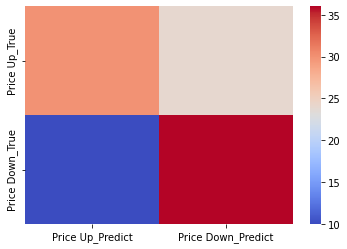

In [46]:
drawConfusion2(LogReg2["confusion"])

In [47]:
LogRegLasso2 = logReg2(X_lasso_train2,y_train2,X_lasso_test2,y_test2)
LogRegLasso2

time: 0.03399968147277832
LogisticRegression Model's Training set score: 0.644
LogisticRegression Model's Test set score: 0.670


{'accuracy': 0.67,
 'time': 0.03399968147277832,
 'roc_auc': 0.681561996779388,
 'f1': 0.667305171892328,
 'confusion': array([[29, 25],
        [ 8, 38]], dtype=int64),
 'trainedModel': LogisticRegression(),
 'y_pred': array([1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  29                  25
Price Down_True                 8                  38


<AxesSubplot:>

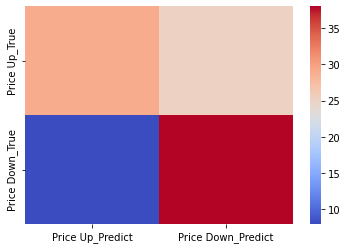

In [48]:
drawConfusion2(LogRegLasso2["confusion"])

In [49]:
LogRegPCA2 = logReg2(X_pca_train2,y_train2,X_pca_test2,y_test2)
LogRegPCA2

time: 0.014914274215698242
LogisticRegression Model's Training set score: 0.644
LogisticRegression Model's Test set score: 0.650


{'accuracy': 0.65,
 'time': 0.014914274215698242,
 'roc_auc': 0.6614331723027376,
 'f1': 0.6471418489767113,
 'confusion': array([[28, 26],
        [ 9, 37]], dtype=int64),
 'trainedModel': LogisticRegression(),
 'y_pred': array([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  28                  26
Price Down_True                 9                  37


<AxesSubplot:>

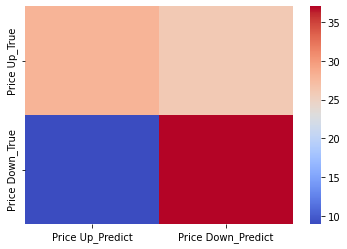

In [50]:
drawConfusion2(LogRegPCA2["confusion"])

## 7.2 DecisionTree

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


#决策树调参
def decTreeTuning2(X_train,y_train,X_test,y_test):
    # max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    # min_samples_split: The minimum number of samples required to split an internal node.
    # min_samples_leaf: The minimum number of samples required to be at a leaf node
    # max_leaf_nodes: The maximum number of leaf nodes
    tree = DecisionTreeClassifier(random_state = 0)
    param_DT = {"max_depth": [10,15],
           "min_samples_split": [10,20,50],}
    grid_tree = GridSearchCV(tree,param_DT,cv=5)
    
    
    result = getLearningResult(grid_tree,X_train,y_train,X_test,y_test)
    grid_tree = result["trainedModel"]
    
    print("\ntree.best_params:",grid_tree.best_params_)
    
    return result

decTreeTuning2(X_train2,y_train2,X_test2,y_test2)

time: 5.8020641803741455
GridSearchCV Model's Training set score: 0.758
GridSearchCV Model's Test set score: 0.590

tree.best_params: {'max_depth': 10, 'min_samples_split': 50}


{'accuracy': 0.59,
 'time': 5.8020641803741455,
 'roc_auc': 0.5897745571658615,
 'f1': 0.5889724310776943,
 'confusion': array([[32, 22],
        [19, 27]], dtype=int64),
 'trainedModel': GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
              param_grid={'max_depth': [10, 15],
                          'min_samples_split': [10, 20, 50]}),
 'y_pred': array([1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.])}

In [78]:
#决策树分类
def decTree2(X_train,y_train,X_test,y_test):
    # max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    # min_samples_split: The minimum number of samples required to split an internal node.
    # min_samples_leaf: The minimum number of samples required to be at a leaf node
    # max_leaf_nodes: The maximum number of leaf nodes
    tree = DecisionTreeClassifier(random_state = 0,max_depth=10,min_samples_split=50)    
    result = getLearningResult(tree,X_train,y_train,X_test,y_test)
    tree = result["trainedModel"]

    
    return result



DecTree2 = decTree2(X_train2,y_train2,X_test2,y_test2)
DecTree2

time: 0.21227669715881348
DecisionTreeClassifier Model's Training set score: 0.758
DecisionTreeClassifier Model's Test set score: 0.590


{'accuracy': 0.59,
 'time': 0.21227669715881348,
 'roc_auc': 0.5897745571658615,
 'f1': 0.5889724310776943,
 'confusion': array([[32, 22],
        [19, 27]], dtype=int64),
 'trainedModel': DecisionTreeClassifier(max_depth=10, min_samples_split=50, random_state=0),
 'y_pred': array([1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  32                  22
Price Down_True                19                  27


<AxesSubplot:>

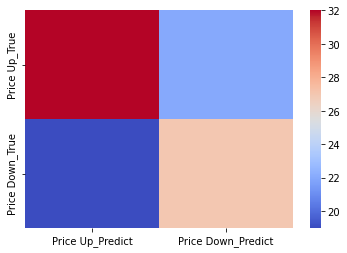

In [79]:
drawConfusion2(DecTree2["confusion"])

In [80]:
DecTreeLasso2 = decTree2(X_lasso_train2,y_train2,X_lasso_test2,y_test2)
DecTreeLasso2

time: 0.015999794006347656
DecisionTreeClassifier Model's Training set score: 0.717
DecisionTreeClassifier Model's Test set score: 0.630


{'accuracy': 0.63,
 'time': 0.015999794006347656,
 'roc_auc': 0.6300322061191627,
 'f1': 0.6290726817042606,
 'confusion': array([[34, 20],
        [17, 29]], dtype=int64),
 'trainedModel': DecisionTreeClassifier(max_depth=10, min_samples_split=50, random_state=0),
 'y_pred': array([1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  34                  20
Price Down_True                17                  29


<AxesSubplot:>

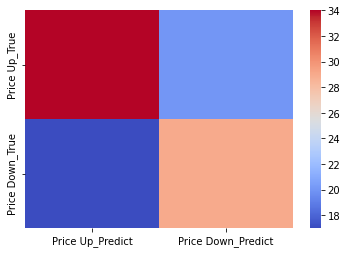

In [81]:
drawConfusion2(DecTreeLasso2["confusion"])

In [82]:
DecTreePCA2 = decTree2(X_pca_train2,y_train2,X_pca_test2,y_test2)
DecTreePCA2

time: 0.06054878234863281
DecisionTreeClassifier Model's Training set score: 0.718
DecisionTreeClassifier Model's Test set score: 0.680


{'accuracy': 0.68,
 'time': 0.06054878234863281,
 'roc_auc': 0.6908212560386473,
 'f1': 0.677938808373591,
 'confusion': array([[30, 24],
        [ 8, 38]], dtype=int64),
 'trainedModel': DecisionTreeClassifier(max_depth=10, min_samples_split=50, random_state=0),
 'y_pred': array([1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
        0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  30                  24
Price Down_True                 8                  38


<AxesSubplot:>

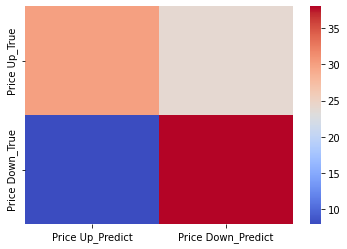

In [83]:
drawConfusion2(DecTreePCA2["confusion"])

## 7.3 KNN分类

In [84]:
from sklearn.neighbors import KNeighborsClassifier


#KNN调参
def kNNTuning2(X_train,y_train,X_test,y_test):
    #n_neighbors: The nearest n neighbors to decide its class
    knn = KNeighborsClassifier()
    param_DT = {"n_neighbors": [80,100,120]}
    grid_knn = GridSearchCV(knn,param_DT,cv=5)
        
    result = getLearningResult(grid_knn,X_train,y_train,X_test,y_test)
    grid_knn = result["trainedModel"]
    
    print("\nknn.best_params:",grid_knn.best_params_)
    
    return result
    
kNNTuning2(X_train2,y_train2,X_test2,y_test2)



time: 1.1393704414367676
GridSearchCV Model's Training set score: 0.624
GridSearchCV Model's Test set score: 0.690

knn.best_params: {'n_neighbors': 120}


{'accuracy': 0.69,
 'time': 1.1393704414367676,
 'roc_auc': 0.6952495974235104,
 'f1': 0.6899689968996898,
 'confusion': array([[34, 20],
        [11, 35]], dtype=int64),
 'trainedModel': GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
              param_grid={'n_neighbors': [80, 100, 120]}),
 'y_pred': array([1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

In [85]:
### KNN分类
def kNN2(X_train,y_train,X_test,y_test):
    #n_neighbors: The nearest n neighbors to decide its class
    knn = KNeighborsClassifier(n_neighbors=120)
      
    result = getLearningResult(knn,X_train,y_train,X_test,y_test)
    grid_knn = result["trainedModel"]

    
    return result
    





KNN2 = kNN2(X_train2,y_train2,X_test2,y_test2)
KNN2

time: 0.0019466876983642578
KNeighborsClassifier Model's Training set score: 0.624
KNeighborsClassifier Model's Test set score: 0.690


{'accuracy': 0.69,
 'time': 0.0019466876983642578,
 'roc_auc': 0.6952495974235104,
 'f1': 0.6899689968996898,
 'confusion': array([[34, 20],
        [11, 35]], dtype=int64),
 'trainedModel': KNeighborsClassifier(n_neighbors=120),
 'y_pred': array([1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  34                  20
Price Down_True                11                  35


<AxesSubplot:>

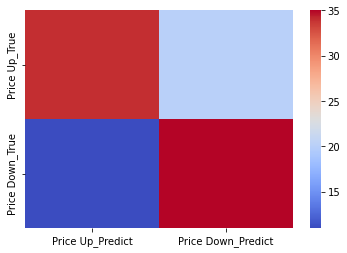

In [86]:
drawConfusion2(KNN2["confusion"])

In [87]:
KNNLasso2 = kNN2(X_lasso_train2,y_train2,X_lasso_test2,y_test2)
KNNLasso2

time: 0.0010001659393310547
KNeighborsClassifier Model's Training set score: 0.622
KNeighborsClassifier Model's Test set score: 0.690


{'accuracy': 0.69,
 'time': 0.0010001659393310547,
 'roc_auc': 0.6968599033816425,
 'f1': 0.6897207486738064,
 'confusion': array([[33, 21],
        [10, 36]], dtype=int64),
 'trainedModel': KNeighborsClassifier(n_neighbors=120),
 'y_pred': array([1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  33                  21
Price Down_True                10                  36


<AxesSubplot:>

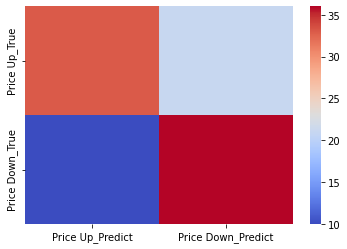

In [88]:
drawConfusion2(KNNLasso2["confusion"])

In [89]:
KNNPCA2 = kNN2(X_pca_train2,y_train2,X_pca_test2,y_test2)
KNNPCA2

time: 0.0
KNeighborsClassifier Model's Training set score: 0.630
KNeighborsClassifier Model's Test set score: 0.700


{'accuracy': 0.7,
 'time': 0.0,
 'roc_auc': 0.7061191626409017,
 'f1': 0.6998799519807923,
 'confusion': array([[34, 20],
        [10, 36]], dtype=int64),
 'trainedModel': KNeighborsClassifier(n_neighbors=120),
 'y_pred': array([1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  34                  20
Price Down_True                10                  36


<AxesSubplot:>

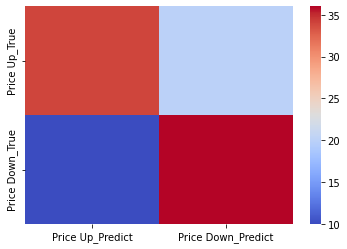

In [90]:
drawConfusion2(KNNPCA2["confusion"])

## 7.4 Naive Bayes分类

In [92]:
#导入NB模型，并对训练集进行训练
from sklearn.naive_bayes import BernoulliNB

def naiveBayes2(X_train,y_train,X_test,y_test):
    nb = BernoulliNB()
    result = getLearningResult(nb,X_train,y_train,X_test,y_test)
    nb = result["trainedModel"]
    return result




NB2 = naiveBayes2(X_train2,y_train2,X_test2,y_test2)
NB2


time: 0.010001420974731445
BernoulliNB Model's Training set score: 0.546
BernoulliNB Model's Test set score: 0.610


{'accuracy': 0.61,
 'time': 0.010001420974731445,
 'roc_auc': 0.6179549114331724,
 'f1': 0.6090225563909775,
 'confusion': array([[28, 26],
        [13, 33]], dtype=int64),
 'trainedModel': BernoulliNB(),
 'y_pred': array([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  28                  26
Price Down_True                13                  33


<AxesSubplot:>

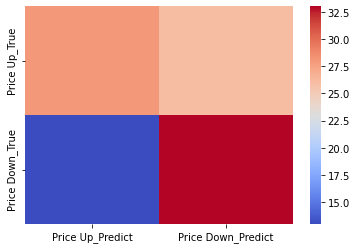

In [93]:
drawConfusion2(NB2["confusion"])

In [94]:
NBLasso2 = naiveBayes2(X_lasso_train2,y_train2,X_lasso_test2,y_test2)
NBLasso2

time: 0.003000020980834961
BernoulliNB Model's Training set score: 0.565
BernoulliNB Model's Test set score: 0.620


{'accuracy': 0.62,
 'time': 0.003000020980834961,
 'roc_auc': 0.6175523349436393,
 'f1': 0.6175523349436394,
 'confusion': array([[35, 19],
        [19, 27]], dtype=int64),
 'trainedModel': BernoulliNB(),
 'y_pred': array([1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  35                  19
Price Down_True                19                  27


<AxesSubplot:>

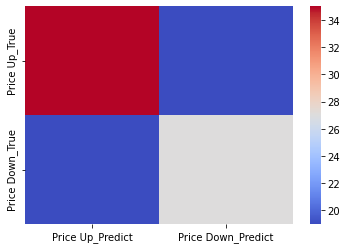

In [95]:
drawConfusion2(NBLasso2["confusion"])

In [96]:
NBPCA2 = naiveBayes2(X_pca_train2,y_train2,X_pca_test2,y_test2)
NBPCA2

time: 0.003008127212524414
BernoulliNB Model's Training set score: 0.619
BernoulliNB Model's Test set score: 0.700


{'accuracy': 0.7,
 'time': 0.003008127212524414,
 'roc_auc': 0.7045088566827697,
 'f1': 0.7000000000000001,
 'confusion': array([[35, 19],
        [11, 35]], dtype=int64),
 'trainedModel': BernoulliNB(),
 'y_pred': array([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  35                  19
Price Down_True                11                  35


<AxesSubplot:>

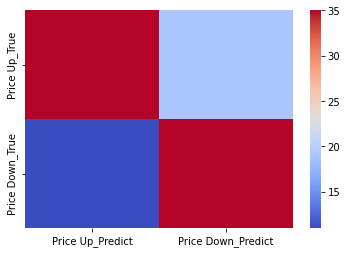

In [97]:
drawConfusion2(NBPCA2["confusion"])

## 7.5 SVM

### 7.5.1 Linear SVM

In [99]:
from sklearn.svm import LinearSVC

def linearSVMTuning2(X_train,y_train,X_test,y_test):
    #define a list of parameters
    params_svc = {'C': [1,10]}
    linear_svc = LinearSVC()
    grid_svc = GridSearchCV(linear_svc, params_svc, cv=3, n_jobs=-1,scoring = 'f1_macro', return_train_score=True)
    
    
    result = getLearningResult(grid_svc,X_train,y_train,X_test,y_test)
    grid_svc = result["trainedModel"]
    
    print(grid_svc.best_params_)
    return result





linearSVMTuning2(X_train2,y_train2,X_test2,y_test2)


time: 5.098562240600586
GridSearchCV Model's Training set score: 0.645
GridSearchCV Model's Test set score: 0.639
{'C': 1}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'accuracy': 0.64,
 'time': 5.098562240600586,
 'roc_auc': 0.6473429951690821,
 'f1': 0.639423076923077,
 'confusion': array([[30, 24],
        [12, 34]], dtype=int64),
 'trainedModel': GridSearchCV(cv=3, estimator=LinearSVC(), n_jobs=-1, param_grid={'C': [1, 10]},
              return_train_score=True, scoring='f1_macro'),
 'y_pred': array([1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

In [100]:
from sklearn.svm import LinearSVC

def linearSVM2(X_train,y_train,X_test,y_test):
    linear_svc = LinearSVC(C=1)
   
        
    result = getLearningResult(linear_svc,X_train,y_train,X_test,y_test)
    linear_svc = result["trainedModel"]
    
    return result





LinearSVM2= linearSVM2(X_train2,y_train2,X_test2,y_test2)
LinearSVM2

time: 1.9506645202636719
LinearSVC Model's Training set score: 0.647
LinearSVC Model's Test set score: 0.640


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'accuracy': 0.64,
 'time': 1.9506645202636719,
 'roc_auc': 0.6473429951690821,
 'f1': 0.639423076923077,
 'confusion': array([[30, 24],
        [12, 34]], dtype=int64),
 'trainedModel': LinearSVC(C=1),
 'y_pred': array([1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  30                  24
Price Down_True                12                  34


<AxesSubplot:>

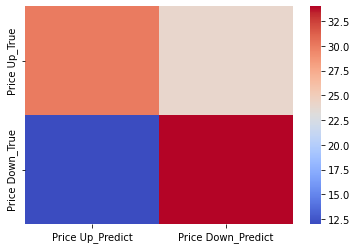

In [101]:
drawConfusion2(LinearSVM2["confusion"])

In [102]:
LinearSVMLasso2 = linearSVM2(X_lasso_train2,y_train2,X_lasso_test2,y_test2)
LinearSVMLasso2

time: 0.043999671936035156
LinearSVC Model's Training set score: 0.645
LinearSVC Model's Test set score: 0.680


{'accuracy': 0.68,
 'time': 0.043999671936035156,
 'roc_auc': 0.6908212560386473,
 'f1': 0.677938808373591,
 'confusion': array([[30, 24],
        [ 8, 38]], dtype=int64),
 'trainedModel': LinearSVC(C=1),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  30                  24
Price Down_True                 8                  38


<AxesSubplot:>

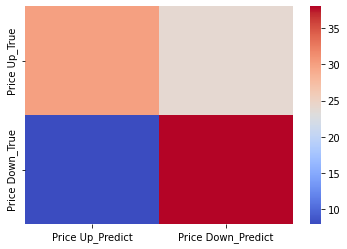

In [103]:
drawConfusion2(LinearSVMLasso2["confusion"])

In [104]:
LinearSVMPCA2 = linearSVM2(X_pca_train2,y_train2,X_pca_test2,y_test2)
LinearSVMPCA2

time: 0.14499330520629883
LinearSVC Model's Training set score: 0.642
LinearSVC Model's Test set score: 0.650


{'accuracy': 0.65,
 'time': 0.14499330520629883,
 'roc_auc': 0.6614331723027376,
 'f1': 0.6471418489767113,
 'confusion': array([[28, 26],
        [ 9, 37]], dtype=int64),
 'trainedModel': LinearSVC(C=1),
 'y_pred': array([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  28                  26
Price Down_True                 9                  37


<AxesSubplot:>

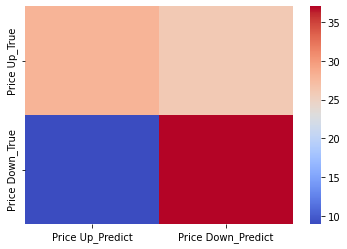

In [105]:
drawConfusion2(LinearSVMPCA2["confusion"])

### 7.5.2 Kernel SVM

In [106]:
from sklearn.svm import SVC

def kernelSVMTuning2(X_train,y_train,X_test,y_test):
    
    svc_kernel = SVC(kernel = 'rbf')
    #define a list of parameters
    param_svc_kernel = {'C': [20,30,30],'gamma':[0.01,0.05,0.1]}
    #apply grid search
    grid_svc_kernel = GridSearchCV(svc_kernel, param_svc_kernel, cv=5, n_jobs=-1, scoring='f1_macro')
    
    
    result = getLearningResult(grid_svc_kernel,X_train,y_train,X_test,y_test)
    grid_svc_kernel = result["trainedModel"]
    
    print(grid_svc_kernel.best_params_)
    return result




kernelSVMTuning2(X_train2,y_train2,X_test2,y_test2)


time: 37.284881353378296
GridSearchCV Model's Training set score: 0.627
GridSearchCV Model's Test set score: 0.699
{'C': 20, 'gamma': 0.01}


{'accuracy': 0.7,
 'time': 37.284881353378296,
 'roc_auc': 0.6996779388083736,
 'f1': 0.6989160979526294,
 'confusion': array([[38, 16],
        [14, 32]], dtype=int64),
 'trainedModel': GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
              param_grid={'C': [20, 30, 30], 'gamma': [0.01, 0.05, 0.1]},
              scoring='f1_macro'),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

In [107]:
from sklearn.svm import SVC

def kernelSVM2(X_train,y_train,X_test,y_test):
    
    svc_kernel = SVC(kernel = 'rbf',C= 20, gamma= 0.01)
 
    
    result = getLearningResult(svc_kernel,X_train,y_train,X_test,y_test)
    grid_svc_kernel = result["trainedModel"]

    return result



KernelSVM2= kernelSVM2(X_train2,y_train2,X_test2,y_test2)
KernelSVM2



time: 1.4080889225006104
SVC Model's Training set score: 0.628
SVC Model's Test set score: 0.700


{'accuracy': 0.7,
 'time': 1.4080889225006104,
 'roc_auc': 0.6996779388083736,
 'f1': 0.6989160979526294,
 'confusion': array([[38, 16],
        [14, 32]], dtype=int64),
 'trainedModel': SVC(C=20, gamma=0.01),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_True  \
Price Up_True                         5                     10   
Price Stationary_True                 9                     58   
Price Down_True                       0                     17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   1  
Price Down_True                         0  


<AxesSubplot:>

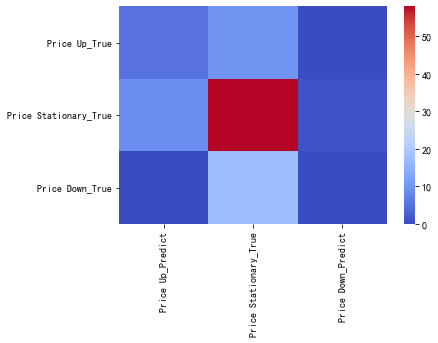

In [419]:
drawConfusion2(KernelSVM2["confusion"])

In [108]:
KernelSVMLasso2= kernelSVM2(X_lasso_train2,y_train2,X_lasso_test2,y_test2)
KernelSVMLasso2

time: 0.6622347831726074
SVC Model's Training set score: 0.627
SVC Model's Test set score: 0.710


{'accuracy': 0.71,
 'time': 0.6622347831726074,
 'roc_auc': 0.7105475040257649,
 'f1': 0.7092731829573935,
 'confusion': array([[38, 16],
        [13, 33]], dtype=int64),
 'trainedModel': SVC(C=20, gamma=0.01),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  38                  16
Price Down_True                13                  33


<AxesSubplot:>

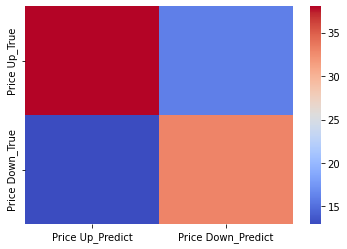

In [109]:
drawConfusion2(KernelSVMLasso2["confusion"])

In [110]:
KernelSVMPCA2 = kernelSVM2(X_pca_train2,y_train2,X_pca_test2,y_test2)
KernelSVMPCA2

time: 0.6825881004333496
SVC Model's Training set score: 0.626
SVC Model's Test set score: 0.700


{'accuracy': 0.7,
 'time': 0.6825881004333496,
 'roc_auc': 0.6996779388083736,
 'f1': 0.6989160979526294,
 'confusion': array([[38, 16],
        [14, 32]], dtype=int64),
 'trainedModel': SVC(C=20, gamma=0.01),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  38                  16
Price Down_True                14                  32


<AxesSubplot:>

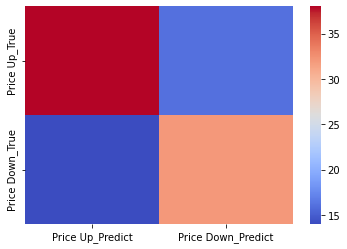

In [111]:
drawConfusion2(KernelSVMPCA2["confusion"])

##  Ensemble Models

## 7.6 Random Forest

In [112]:
from sklearn.ensemble import RandomForestClassifier

def randomForest2(X_train,y_train,X_test,y_test):
    
    rnd_clf = RandomForestClassifier(n_estimators=500, max_depth = 10,min_samples_split = 20, n_jobs=-1, random_state=42)
    # max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    # min_samples_split: The minimum number of samples required to split an internal node.
    # min_samples_leaf: The minimum number of samples required to be at a leaf node
    # max_leaf_nodes: The maximum number of leaf nodes

    result = getLearningResult(rnd_clf,X_train,y_train,X_test,y_test)

        
    return result




RandomForest2 = randomForest2(X_train2,y_train2,X_test2,y_test2)
RandomForest2




time: 0.6723840236663818
RandomForestClassifier Model's Training set score: 0.798
RandomForestClassifier Model's Test set score: 0.720


{'accuracy': 0.72,
 'time': 0.6723840236663818,
 'roc_auc': 0.7230273752012881,
 'f1': 0.7198879551820729,
 'confusion': array([[37, 17],
        [11, 35]], dtype=int64),
 'trainedModel': RandomForestClassifier(max_depth=10, min_samples_split=20, n_estimators=500,
                        n_jobs=-1, random_state=42),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  37                  17
Price Down_True                11                  35


<AxesSubplot:>

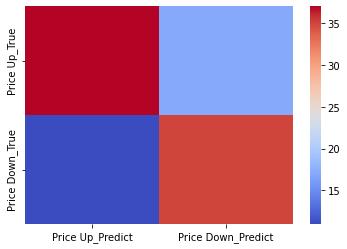

In [113]:
drawConfusion2(RandomForest2["confusion"])

In [114]:
RandomForestLasso2 = randomForest2(X_lasso_train2,y_train2,X_lasso_test2,y_test2)
RandomForestLasso2

time: 0.48494935035705566
RandomForestClassifier Model's Training set score: 0.741
RandomForestClassifier Model's Test set score: 0.670


{'accuracy': 0.67,
 'time': 0.48494935035705566,
 'roc_auc': 0.681561996779388,
 'f1': 0.667305171892328,
 'confusion': array([[29, 25],
        [ 8, 38]], dtype=int64),
 'trainedModel': RandomForestClassifier(max_depth=10, min_samples_split=20, n_estimators=500,
                        n_jobs=-1, random_state=42),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  29                  25
Price Down_True                 8                  38


<AxesSubplot:>

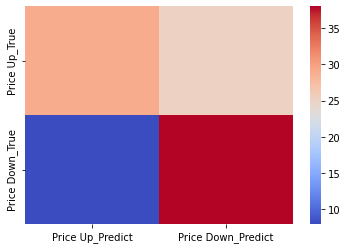

In [115]:
drawConfusion2(RandomForestLasso2["confusion"])

In [116]:
RandomForestPCA2 = randomForest2(X_pca_train2,y_train2,X_pca_test2,y_test2)
RandomForestPCA2

time: 0.6427772045135498
RandomForestClassifier Model's Training set score: 0.795
RandomForestClassifier Model's Test set score: 0.670


{'accuracy': 0.67,
 'time': 0.6427772045135498,
 'roc_auc': 0.6783413848631239,
 'f1': 0.6691729323308271,
 'confusion': array([[31, 23],
        [10, 36]], dtype=int64),
 'trainedModel': RandomForestClassifier(max_depth=10, min_samples_split=20, n_estimators=500,
                        n_jobs=-1, random_state=42),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  31                  23
Price Down_True                10                  36


<AxesSubplot:>

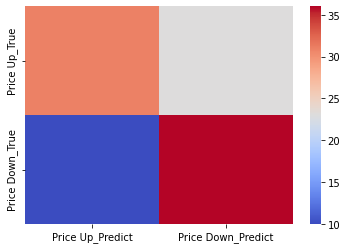

In [117]:
drawConfusion2(RandomForestPCA2["confusion"])

## 7.7 Voting Classifier

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def voting2(X_train,y_train,X_test,y_test):
    
    log_clf = LogisticRegression(solver="liblinear", random_state=42)
    rnd_clf = RandomForestClassifier(n_estimators=50, random_state=42)
    svm_clf = SVC(gamma="auto",  probability=True,random_state=42)
    
    voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting='hard')

    # If ‘hard’, uses predicted class labels for majority rule voting. 
    # Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.
    
    result = getLearningResult(voting_clf,X_train,y_train,X_test,y_test)
    voting_clf = result["trainedModel"]
    
    for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
        
    return result
    



Voting2 = voting2(X_train2,y_train2,X_test2,y_test2)
Voting2


time: 9.921528577804565
VotingClassifier Model's Training set score: 0.712
VotingClassifier Model's Test set score: 0.700
LogisticRegression 0.67
RandomForestClassifier 0.75
SVC 0.71
VotingClassifier 0.7


{'accuracy': 0.7,
 'time': 9.921528577804565,
 'roc_auc': 0.7045088566827697,
 'f1': 0.7000000000000001,
 'confusion': array([[35, 19],
        [11, 35]], dtype=int64),
 'trainedModel': VotingClassifier(estimators=[('lr',
                               LogisticRegression(random_state=42,
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(n_estimators=50,
                                                      random_state=42)),
                              ('svc',
                               SVC(gamma='auto', probability=True,
                                   random_state=42))]),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.,

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  35                  19
Price Down_True                11                  35


<AxesSubplot:>

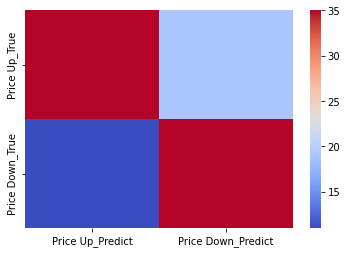

In [120]:
drawConfusion2(Voting2["confusion"])

In [121]:
VotingLasso2 = voting2(X_lasso_train2,y_train2,X_lasso_test2,y_test2)
VotingLasso2

time: 3.507669687271118
VotingClassifier Model's Training set score: 0.706
VotingClassifier Model's Test set score: 0.670
LogisticRegression 0.67
RandomForestClassifier 0.57
SVC 0.71
VotingClassifier 0.67


{'accuracy': 0.67,
 'time': 3.507669687271118,
 'roc_auc': 0.676731078904992,
 'f1': 0.6697027324592133,
 'confusion': array([[32, 22],
        [11, 35]], dtype=int64),
 'trainedModel': VotingClassifier(estimators=[('lr',
                               LogisticRegression(random_state=42,
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(n_estimators=50,
                                                      random_state=42)),
                              ('svc',
                               SVC(gamma='auto', probability=True,
                                   random_state=42))]),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  32                  22
Price Down_True                11                  35


<AxesSubplot:>

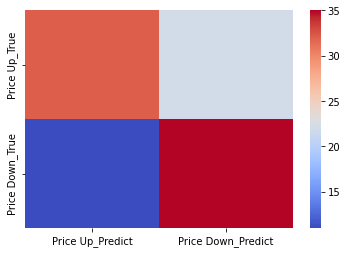

In [122]:
drawConfusion2(VotingLasso2["confusion"])

In [123]:
VotingPCA2 = voting2(X_pca_train2,y_train2,X_pca_test2,y_test2)
VotingPCA2

time: 4.1165549755096436
VotingClassifier Model's Training set score: 0.705
VotingClassifier Model's Test set score: 0.680
LogisticRegression 0.65
RandomForestClassifier 0.7
SVC 0.7
VotingClassifier 0.68


{'accuracy': 0.68,
 'time': 4.1165549755096436,
 'roc_auc': 0.6876006441223832,
 'f1': 0.6794871794871795,
 'confusion': array([[32, 22],
        [10, 36]], dtype=int64),
 'trainedModel': VotingClassifier(estimators=[('lr',
                               LogisticRegression(random_state=42,
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(n_estimators=50,
                                                      random_state=42)),
                              ('svc',
                               SVC(gamma='auto', probability=True,
                                   random_state=42))]),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  32                  22
Price Down_True                10                  36


<AxesSubplot:>

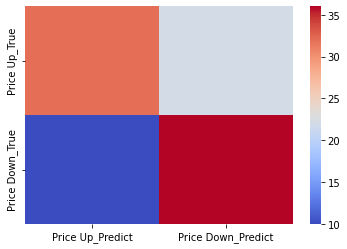

In [124]:
drawConfusion2(VotingPCA2["confusion"])

## 7.8  AdaBoost

In [127]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

def adaBoost2(X_train,y_train,X_test,y_test):
    
    ada_clf = AdaBoostClassifier(
        LogisticRegression(), n_estimators=500,algorithm="SAMME.R", learning_rate=0.01, random_state=42)    
    result = getLearningResult(ada_clf,X_train,y_train,X_test,y_test)
    ada_clf = result["trainedModel"]
        
    return result


AdaBoost2 = adaBoost2(X_train2,y_train2,X_test2,y_test2)
AdaBoost2



time: 5.542864084243774
AdaBoostClassifier Model's Training set score: 0.592
AdaBoostClassifier Model's Test set score: 0.660


{'accuracy': 0.66,
 'time': 5.542864084243774,
 'roc_auc': 0.6674718196457328,
 'f1': 0.6594551282051282,
 'confusion': array([[31, 23],
        [11, 35]], dtype=int64),
 'trainedModel': AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=0.01,
                    n_estimators=500, random_state=42),
 'y_pred': array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  31                  23
Price Down_True                11                  35


<AxesSubplot:>

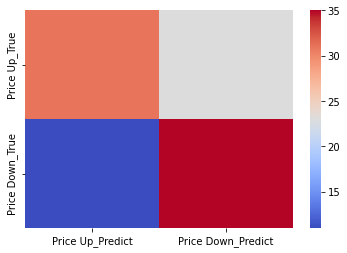

In [128]:
drawConfusion2(AdaBoost2["confusion"])

In [129]:
AdaBoostLasso2 = adaBoost2(X_lasso_train2,y_train2,X_lasso_test2,y_test2)
AdaBoostLasso2

time: 2.737805128097534
AdaBoostClassifier Model's Training set score: 0.560
AdaBoostClassifier Model's Test set score: 0.630


{'accuracy': 0.63,
 'time': 2.737805128097534,
 'roc_auc': 0.6219806763285024,
 'f1': 0.6214833759590792,
 'confusion': array([[39, 15],
        [22, 24]], dtype=int64),
 'trainedModel': AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=0.01,
                    n_estimators=500, random_state=42),
 'y_pred': array([1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  39                  15
Price Down_True                22                  24


<AxesSubplot:>

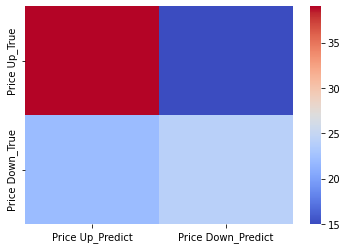

In [130]:
drawConfusion2(AdaBoostLasso2["confusion"])

In [131]:
AdaBoostPCA2 = adaBoost2(X_pca_train2,y_train2,X_pca_test2,y_test2)
AdaBoostPCA2

time: 2.37548828125
AdaBoostClassifier Model's Training set score: 0.593
AdaBoostClassifier Model's Test set score: 0.660


{'accuracy': 0.66,
 'time': 2.37548828125,
 'roc_auc': 0.6674718196457328,
 'f1': 0.6594551282051282,
 'confusion': array([[31, 23],
        [11, 35]], dtype=int64),
 'trainedModel': AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=0.01,
                    n_estimators=500, random_state=42),
 'y_pred': array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])}

The DataFrame of the Confusion Matrix generated is:
                 Price Up_Predict  Price Down_Predict
Price Up_True                  31                  23
Price Down_True                11                  35


<AxesSubplot:>

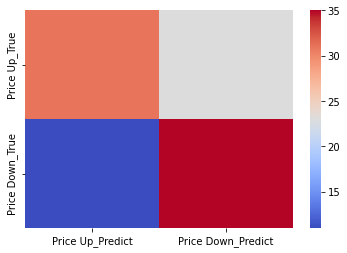

In [132]:
drawConfusion2(AdaBoostPCA2["confusion"])

# 8. 机器学习模型综合比较

## 8.1 原始特征综合比较

In [134]:
#LogReg DecTree KNN NB LinearSVM KernelSVM RandomForest Voting AdaBoost DeepLearning

metrics2 = {"accuracy","time","f1","roc_auc","confusion"}
dat2 = {
    'Logistic Regression':{key: value for key, value in LogReg2.items() if key in metrics2},
    'Decision Tree':{key: value for key, value in DecTree2.items() if key in metrics2},
    'KNN':{key: value for key, value in KNN2.items() if key in metrics2},
    'Naive Bayesian':{key: value for key, value in NB2.items() if key in metrics2},
    'Linear SVM':{key: value for key, value in LinearSVM2.items() if key in metrics2},
    'Kernel SVM':{key: value for key, value in KernelSVM2.items() if key in metrics2},
    'Random Forest':{key: value for key, value in RandomForest2.items() if key in metrics2},
    'Voting Ensemble':{key: value for key, value in Voting2.items() if key in metrics2},
    'AdaBoost':{key: value for key, value in AdaBoost2.items() if key in metrics2},
} 

pd.DataFrame(dat2)





,Logistic Regression,Decision Tree,KNN,Naive Bayesian,Linear SVM,Kernel SVM,Random Forest,Voting Ensemble,AdaBoost
accuracy,0.66,0.59,0.69,0.61,0.64,0.7,0.72,0.7,0.66
time,0.065,0.212277,0.001947,0.010001,1.950665,1.408089,0.672384,9.921529,5.542864
roc_auc,0.669082,0.589775,0.69525,0.617955,0.647343,0.699678,0.723027,0.704509,0.667472
f1,0.658772,0.588972,0.689969,0.609023,0.639423,0.698916,0.719888,0.7,0.659455
confusion,"[[30, 24], [10, 36]]","[[32, 22], [19, 27]]","[[34, 20], [11, 35]]","[[28, 26], [13, 33]]","[[30, 24], [12, 34]]","[[38, 16], [14, 32]]","[[37, 17], [11, 35]]","[[35, 19], [11, 35]]","[[31, 23], [11, 35]]"


## 8.2 Lasso筛选后特征综合比较

In [135]:
#LogReg DecTree KNN NB LinearSVM KernelSVM RandomForest Voting AdaBoost DeepLearning


dat_lasso2 = {
    'Logistic Regression ( Lasso Selection )':{key: value for key, value in LogRegLasso2.items() if key in metrics2},
    'Decision Tree ( Lasso Selection )':{key: value for key, value in DecTreeLasso2.items() if key in metrics2},
    'KNN ( Lasso Selection )':{key: value for key, value in KNNLasso2.items() if key in metrics2},
    'Naive Bayesian ( Lasso Selection )':{key: value for key, value in NBLasso2.items() if key in metrics2},
    'Linear SVM ( Lasso Selection )':{key: value for key, value in LinearSVMLasso2.items() if key in metrics2},
    'Kernel SVM ( Lasso Selection )':{key: value for key, value in KernelSVMLasso2.items() if key in metrics2},
    'Random Forest ( Lasso Selection )':{key: value for key, value in RandomForestLasso2.items() if key in metrics2},
    'Voting Ensemble ( Lasso Selection )':{key: value for key, value in VotingLasso2.items() if key in metrics2},
    'AdaBoost ( Lasso Selection )':{key: value for key, value in AdaBoostLasso2.items() if key in metrics2}
} 

pd.DataFrame(dat_lasso2)

,Logistic Regression ( Lasso Selection ),Decision Tree ( Lasso Selection ),KNN ( Lasso Selection ),Naive Bayesian ( Lasso Selection ),Linear SVM ( Lasso Selection ),Kernel SVM ( Lasso Selection ),Random Forest ( Lasso Selection ),Voting Ensemble ( Lasso Selection ),AdaBoost ( Lasso Selection )
accuracy,0.67,0.63,0.69,0.62,0.68,0.71,0.67,0.67,0.63
time,0.034,0.016,0.001,0.003,0.044,0.662235,0.484949,3.50767,2.737805
roc_auc,0.681562,0.630032,0.69686,0.617552,0.690821,0.710548,0.681562,0.676731,0.621981
f1,0.667305,0.629073,0.689721,0.617552,0.677939,0.709273,0.667305,0.669703,0.621483
confusion,"[[29, 25], [8, 38]]","[[34, 20], [17, 29]]","[[33, 21], [10, 36]]","[[35, 19], [19, 27]]","[[30, 24], [8, 38]]","[[38, 16], [13, 33]]","[[29, 25], [8, 38]]","[[32, 22], [11, 35]]","[[39, 15], [22, 24]]"


## 8.3 PCA降维后特征综合比较

In [137]:
#LogReg DecTree KNN NB LinearSVM KernelSVM RandomForest Voting AdaBoost DeepLearning

dat_pca2 = {
    'Logistic Regression':{key: value for key, value in LogRegPCA2.items() if key in metrics2},
    'Decision Tree':{key: value for key, value in DecTreePCA2.items() if key in metrics2},
    'KNN':{key: value for key, value in KNNPCA2.items() if key in metrics2},
    'Naive Bayesian':{key: value for key, value in NBPCA2.items() if key in metrics2},
    'Linear SVM':{key: value for key, value in LinearSVMPCA2.items() if key in metrics2},
    'Kernel SVM':{key: value for key, value in KernelSVMPCA2.items() if key in metrics2},
    'Random Forest':{key: value for key, value in RandomForestPCA2.items() if key in metrics2},
    'Voting Ensemble':{key: value for key, value in VotingPCA2.items() if key in metrics2},
    'AdaBoost':{key: value for key, value in AdaBoostPCA2.items() if key in metrics2}
} 

pd.DataFrame(dat_pca2)

,Logistic Regression,Decision Tree,KNN,Naive Bayesian,Linear SVM,Kernel SVM,Random Forest,Voting Ensemble,AdaBoost
accuracy,0.65,0.68,0.7,0.7,0.65,0.7,0.67,0.68,0.66
time,0.014914,0.060549,0.0,0.003008,0.144993,0.682588,0.642777,4.116555,2.375488
roc_auc,0.661433,0.690821,0.706119,0.704509,0.661433,0.699678,0.678341,0.687601,0.667472
f1,0.647142,0.677939,0.69988,0.7,0.647142,0.698916,0.669173,0.679487,0.659455
confusion,"[[28, 26], [9, 37]]","[[30, 24], [8, 38]]","[[34, 20], [10, 36]]","[[35, 19], [11, 35]]","[[28, 26], [9, 37]]","[[38, 16], [14, 32]]","[[31, 23], [10, 36]]","[[32, 22], [10, 36]]","[[31, 23], [11, 35]]"


从模型上进行比较：在原数据维度对比可以发现，RandomForest的整体效果是最好的，f1和auc值最高，且时间并不长。接下来就是Voting Ensemble，KernelSVM模型，表现都还行，且时间较短。相反的，NaiveBayesian和简单决策树模型变现较差。

从不同变量筛选方式来看，两个方法效果都比较好，都缩短了时间：且为造成模型预测准确率明显下降，可以在大规模处理，需要提高资源利用率时进行替代。

从多个维度整体来看，表现最好的是原始数据训练得到的RandomForest模型，我们可以以此模型预测盘口股票价格变动方向。

# 总结

这学期的课程给了我一把在金融世界进行建模分析的钥匙，让我看到了Excel，python这两种工具在金融领域的种种应用，学会了如何对现金流企业价值如何建模，对基金产品进行因子分析和对高频股价进行预测并编写策略进行回测，通过这些模型和应用场景，领略了金融的魅力也学会了如何使用工具进行分析，这次期末大作业更是让我有了一个使用机器学习工具独立尝试探索高频股价的机会。有焦虑、有辛苦、更有喜悦和收获，最后再次衷心地感谢老师、助教和所有同学，希望我们都能通过这门课程点亮更多技能点，成为更好的自己！